# iLykei Lecture Series

# University of Chicago

# Advanced Machine Learning and Artificial Intelligence

# Reinforcement Learning

## Notebook 6: Learning Ms. Pac-Man with DQN

## Yuri Balasanov, Mihail Tselishchev, &copy; iLykei 2018-2020

## HomeWork Done By : Surendiran Rangaraj

##### Main text: Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurelien Geron, &copy; Aurelien Geron 2017, O'Reilly Media, Inc


In [1]:
rcc=False
colab=False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import random
import time
import os
import gc

from tensorflow.keras.models import Sequential, clone_model,load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, InputLayer
from tensorflow.keras.callbacks import CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import gym

plt.rcParams['figure.figsize'] = (9, 9)

###### Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
###### your files will be saved in your Google Drive!

In [3]:

import os
# the base Google Drive directory
root_dir = "/content/drive/My Drive/"
if rcc:
    root_dir = "/cloud/msca-gcp/surendiran/"
    # choose where you want your project files to be saved
    project_folder = "pacmanRL/code/"
    data_folder = "pacmanRL/data/"
else:
    if colab:
        root_dir = "/content/drive/My Drive/"
        # choose where you want your project files to be saved
        project_folder = "Colab Notebooks/ADVML/code/"
        data_folder = "Colab Notebooks/ADVML/data/"
    else:
        root_dir = "C:\\Users\\rsure\\Desktop\\Uchicago\\AdvMachineLearning\\"
        # choose where you want your project files to be saved
        project_folder = "Reinforcement Learning\\Pacman_Assignment02\\"
        data_folder = "Reinforcement Learning\\Pacman_Assignment02\\data\\"






In [4]:
# Set your working directory to a folder in your Google Drive. This way, if your notebook times out,
# your files will be saved in your Google Drive!
def set_WD(project_folder):
    # change the OS to use your project folder as the working directory
    os.chdir(root_dir + project_folder)
    print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\nYou can also run !pwd to confirm the current working directory." )


def create_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

In [5]:
create_directory(project_folder)
create_directory(data_folder)
set_WD(project_folder)


Your working directory was changed to C:\Users\rsure\Desktop\Uchicago\AdvMachineLearning\Reinforcement Learning\Pacman_Assignment02\
You can also run !pwd to confirm the current working directory.


# Deep Q-Learning of MS. Pac-Man with Keras

This notebook shows how to implement a deep neural network approach to train an agent to play Ms.Pac-Man Atari game.


## Explore the game

Use [Gym](https://gym.openai.com/) toolkit that provides both game environment and also a convenient renderer of the game.

Create an environment.

In [ ]:
#!python -m atari_py.import_roms "https://drive.google.com/drive/folders/1aZWOt3e5WcnywBtBLoD4r_VuG1r0zCLw?usp=sharing"
#env = gym.make("MsPacman-ram-v0")
#env.action_space  # actions are integers from 0 to 8

# Deep Q-Learning of MS. Pac-Man with Keras

Use Custom Module and states

In [6]:
import json
from mini_pacman import PacmanGame

#path = "/content/drive/My Drive/Colab Notebooks/ADVML/data/"
filenamepath = root_dir+project_folder+"test_params.json"
with open(filenamepath, 'r') as file:
    read_params = json.load(file)
game_params = read_params['params']
env = PacmanGame(**game_params)

In [7]:
game_params

{'field_shape': [8, 8],
 'nmonsters': 2,
 'ndiamonds': 3,
 'nwalls': 10,
 'monster_vision_range': 2,
 'max_moves': 100,
 'diamond_reward': 100,
 'survival_reward': 1}

In [8]:
#env = PacmanGame(field_shape=(10,10), nmonsters=2,
#                 ndiamonds=3, nwalls=4, monster_vision_range=1)

Try to play the game using random strategy:

In [9]:
obs=env.reset()
done = False
score = 0
rewards=[]
game_scores=[]
for one_game in range(100):
    obs = env.reset()
    while not obs['end_game']:    
        action = random.choice(obs['possible_actions'])
        obs = env.make_action(action)
    game_scores.append(obs['total_score'])
print('Mean: ',np.mean(game_scores),'\nMedian: ',np.median(game_scores))
    #env.render()
    #time.sleep(0.01)
   
env.close()


Mean:  43.74 
Median:  7.0


### Observation

In this environment, observation (i.e. current state) is the RAM of the Atari machine, namely a vector of 128 bytes:

In [10]:
obs = env.reset()

Look at that vector:

In [11]:
print(obs)
print(env.get_obs())

{'reward': 0, 'total_score': 0, 'end_game': False, 'player': (1, 4), 'monsters': [(7, 4), (7, 6)], 'diamonds': [(1, 6), (4, 4), (5, 3)], 'walls': [(0, 4), (1, 5), (3, 7), (4, 0), (4, 1), (4, 5), (5, 5), (6, 4), (6, 6), (7, 3)], 'possible_actions': [1, 2, 3, 4, 5, 7, 9]}
{'reward': 0, 'total_score': 0, 'end_game': False, 'player': (1, 4), 'monsters': [(7, 4), (7, 6)], 'diamonds': [(1, 6), (4, 4), (5, 3)], 'walls': [(0, 4), (1, 5), (3, 7), (4, 0), (4, 1), (4, 5), (5, 5), (6, 4), (6, 6), (7, 3)], 'possible_actions': [1, 2, 3, 4, 5, 7, 9]}


Player can control agent using actions from 1 to 9 

In [12]:
from tabulate import tabulate
print(tabulate([[1,'Down-Left'], \
                [2,'Down'], \
                [3,'Down-Right'], \
                [4,'Left'], \
                [5,'No Move'], \
                [6,'Right'], \
                [7,'Up-Left'], \
                [8,'Up'], \
                [9,'Up-Right']], \
               headers = ['Action Code','Move'], \
              tablefmt='orgtbl'))

|   Action Code | Move       |
|---------------+------------|
|             1 | Down-Left  |
|             2 | Down       |
|             3 | Down-Right |
|             4 | Left       |
|             5 | No Move    |
|             6 | Right      |
|             7 | Up-Left    |
|             8 | Up         |
|             9 | Up-Right   |


Represent current state as a vector of features.

In [13]:
def get_state(obs):
    v = []
    x,y = obs['player']
    v.append(x)
    v.append(y)
    for x, y in obs['monsters']:
        v.append(x)
        v.append(y)
    for x, y in obs['diamonds']:
        v.append(x)
        v.append(y)
    for x, y in obs['walls']:
        v.append(x)
        v.append(y)
    return v

In [14]:
print(env.get_obs())

{'reward': 0, 'total_score': 0, 'end_game': False, 'player': (1, 4), 'monsters': [(7, 4), (7, 6)], 'diamonds': [(1, 6), (4, 4), (5, 3)], 'walls': [(0, 4), (1, 5), (3, 7), (4, 0), (4, 1), (4, 5), (5, 5), (6, 4), (6, 6), (7, 3)], 'possible_actions': [1, 2, 3, 4, 5, 7, 9]}


In [15]:
state = get_state(env.get_obs())
print(state)

[1, 4, 7, 4, 7, 6, 1, 6, 4, 4, 5, 3, 0, 4, 1, 5, 3, 7, 4, 0, 4, 1, 4, 5, 5, 5, 6, 4, 6, 6, 7, 3]


Create a deep neural network that takes byte vector as an input and produces Q-values for state-action pairs.

## Creating a DQN-model using Keras

The following model is of the same general type applied to the cartPole problem.

Use vanilla multi-layer dense network with relu activations which computes Q-values $Q(s,a)$ for all states $s$ and actions $a$ (with some discount factor $\gamma$).
This neural network denoted by $Q(s\ |\ \theta)$ takes current state as an input and produces a vector of q-values for all 9 possible actions. Vector $\theta$ corresponds to all trainable parameters.

In [16]:
def create_dqn_model(input_shape, nb_actions, dense_layers, dense_units):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    #for i in range(dense_layers):
    #    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(nb_actions, activation='linear'))
    return model

Create a network using specific input shape and action space size. We call this network *online*.

In [17]:
input_shape = (len(state),)
nb_actions = 9 #obs['possible_actions']
dense_layers = 6
dense_units = 512
print('input_shape: ',input_shape)
print('nb_actions: ',nb_actions)


input_shape:  (32,)
nb_actions:  9


In [19]:
online_network = create_dqn_model(input_shape, nb_actions, dense_layers, dense_units)
online_network.summary()
#target_network = clone_model(online_network)
#target_network.set_weights(online_network.get_weights())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               16896     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 585       
Total params: 255,753
Trainable params: 255,753
Non-trainable params: 0
________________________________________________

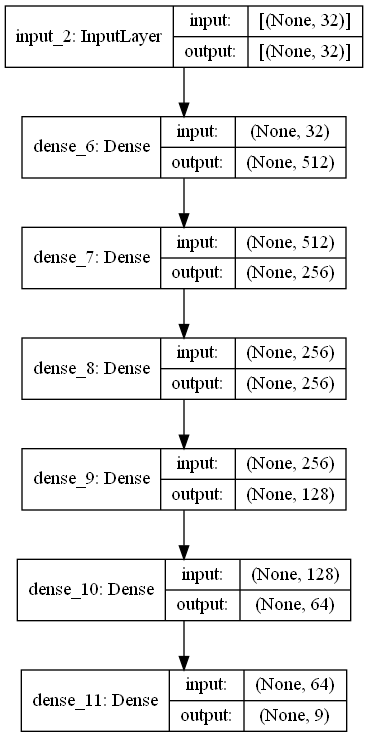

In [20]:
from tensorflow.keras.utils import plot_model
#plot_model(online_network, to_file='online_DenseNetwork.png',show_shapes=True,show_layer_names=True)
plot_model(online_network,show_shapes=True,show_layer_names=True)

**Score based on Random and Naive Strategy**

In [21]:
from mini_pacman import test, random_strategy, naive_strategy
test(strategy=random_strategy, log_file='test_pacman_random_log.json')

Your average score is 37.402, median is 4.0, saved log to 'test_pacman_random_log.json'. Do not forget to upload it for submission!


4.0

In [22]:
test(strategy=naive_strategy, log_file='test_pacman_naive_log.json')

Your average score is 111.314, median is 100.0, saved log to 'test_pacman_naive_log.json'. Do not forget to upload it for submission!


100.0

This network is used to explore states and rewards of Markov decision process according to an $\varepsilon$-greedy exploration strategy:

In [23]:
def epsilon_greedy(q_values, epsilon, n_outputs):
    if random.random() < epsilon:
        return random.choice(n_outputs)  # random action
    else:
        return np.argmax(q_values) + 1         # q-optimal action  ( add 1 to adjust the index(0 to 8) to action(1 to 9))

Online network stores explored information in a *replay memory*, a double-ended queue (deque).

In [24]:
from collections import deque

replay_memory_maxlen = 1000000
replay_memory = deque([], maxlen=replay_memory_maxlen)

So, online network explores the game using $\varepsilon$-greedy strategy and saves experienced transitions in replay memory. 

In order to produce Q-values for $\varepsilon$-greedy strategy, following the proposal of the [original paper by Google DeepMind](https://www.nature.com/articles/nature14236), use another network, called *target network*, to calculate "ground-truth" target for the online network. *Target network*, has the same architecture as online network and is not going to be trained. Instead, weights from the online network are periodically copied to target network.

In [25]:
target_network = clone_model(online_network)
target_network.set_weights(online_network.get_weights())

The target network uses past experience in the form of randomly selected records of the replay memory to predict targets for the online network: 

- Select a random minibatch from replay memory containing tuples $(\text{state},\text{action},\text{reward},\text{next_state})$

- For every tuple $(\text{state},\text{action},\text{reward},\text{next_state})$ from minibatch Q-value function $Q(\text{state},\text{action}\ |\ \theta_{\text{online}})$ is trained on predictions of $Q(\text{next_state}, a\ |\ \theta_\text{target})$ according to Bellman-type equation: 

$$y_\text{target} = \text{reward} + \gamma \cdot \max_a Q(\text{next_state}, a\ |\ \theta_\text{target})$$
if the game continues and $$ y_\text{target} = \text{reward}$$ if the game has ended. 

Note that at this step predictions are made by the target network. This helps preventing situations when online network simultaneously predicts values and creates targets, which might potentially lead to instability of training process.

- For each record in the minibatch targets need to be calculated for only one specific $\text{action}$ output of online network. It is important to ignore all other outputs during optimization (calculating gradients). So, predictions for every record in the minibatch are calculated by online network first, then the values corresponding to the actually selected action are replaced with ones predicted by target network. 

## Double DQN

Approach proposed in the previous section is called **DQN**-approach. 

DQN approach is very powerful and allows to train agents in very complex, very multidimentional environments.

However, [it is known](https://arxiv.org/abs/1509.06461) to overestimate q-values under certain conditions. 

Alternative approach proposed in the [same paper](https://arxiv.org/abs/1509.06461) is called **Double DQN**. 

Instead of taking action that maximizes q-value for target network, they pick an action that maximizes q-value for online network as an optimal one:

$$y_\text{target} = \text{reward} + \gamma \cdot Q\left(\text{next_state}, \arg\max_a Q\left(\text{next_state},a\ |\ \theta_\text{online}\right)\ |\ \theta_\text{target}\right).$$


Create folder for logs and trained weights:

In [26]:
name = 'MsPacman_DQN'  # used in naming files (weights, logs, etc)
if not os.path.exists(name):
    os.makedirs(name)
    
weights_folder = os.path.join(name, 'weights')
if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)

## Training DQN

First, define hyperparameters (Do not forget to change them before moving to cluster):

In [27]:
#n_steps = 500000       # total number of training steps (= n_epochs)
#warmup = 5000
n_steps = 500000
warmup = 12000
                       # start training after warmup iterations
training_interval = 4  # period (in actions) between training steps
save_steps = int(n_steps/100)  # period (in training steps) between storing weights to file
copy_steps = 10000      # period (in training steps) between updating target_network weights
gamma = 0.99999         # discount rate
#skip_start = 90       # skip the start of every game (it's just freezing time before game starts)
batch_size = 128       # size of minibatch that is taken randomly from replay memory every training step
double_dqn = True     # whether to use Double-DQN approach or simple DQN (see above)

# eps-greedy parameters: we slowly decrease epsilon from eps_max to eps_min in eps_decay_steps
eps_max = 1.0
eps_min = 0.05
eps_decay_steps = int(n_steps/2)

learning_rate = 0.0001

Compile online-network with Adam optimizer, mean squared error loss and `mean_q` metric, which measures the maximum of predicted q-values averaged over samples from minibatch (we expect it to increase during training process).

Use standard callbacks:

In [28]:
def mean_q(y_true, y_pred):
    return K.mean(K.max(y_pred, axis=-1))
online_network.compile(optimizer=Adam(learning_rate), loss='mse', metrics=[mean_q])

In [29]:
csv_logger = CSVLogger(os.path.join(name, 'log.csv'), append=True, separator=';')
tensorboard = TensorBoard(log_dir=os.path.join(name, 'tensorboard'), write_graph=False, write_images=False)

In [30]:
import datetime
import pickle
start_time = datetime.datetime.now()
print(start_time)

2021-08-14 12:48:22.287541


In [31]:
tensorboard

In [32]:
csv_logger

In [33]:
#replay_memory[0][4]
np.array(replay_memory).shape

(0,)

In [34]:
from os import listdir
from os.path import isfile, join

weightsPath = root_dir+project_folder+'/'+name+'/weights'
search_string = 'online_weights_model'

def fetchLatest(path):
    f_split = []
    for f in listdir(path):
        if isfile(join(path, f)):
            if search_string in f:
                f_split.append(f.split("_")[3].split(".")[0])
    max_nbr = max(f_split)                
    return max_nbr
            
onlyfiles = fetchLatest(weightsPath)

#lastPrcdStep = !ls -ltr '/content/drive/My Drive/Colab Notebooks/ADVML/code/MsPacman_DQN/weights'  | grep -i 'online_weights_model' | awk -F " " '{print $9}' | tail -1 | cut -d '_' -f 4 | cut -d '.' -f 1

Next chunk of code explores the game, trains online network and periodically copies weights to target network as explained above.

In [ ]:
# counters:
step = 0          # training step counter (= epoch counter)
iteration = 0     # frames counter
episodes = 0      # game episodes counter
done = True       # indicator that env needs to be reset
all_rewards=[]
n_outputs = obs['possible_actions']
episode_scores = []  # collect total scores in this list and log it later
train_existing = False
weights_path = root_dir+project_folder+'/'+name+'/weights'
replmem_filename = 'replay_memory'


if train_existing:
  print("weights_path:", weights_path)
  start_time = datetime.datetime.now()
  print(start_time)
  
  # get the last processed step to restore weights
  lastPrcdStep = fetchLatest(weights_path)
  step = int(' '.join(lastPrcdStep))
  print("Using Loaded weights from step:" , lastPrcdStep)
  online_network.load_weights(os.path.join(weights_folder, 'online_weights_model_{}.h5'.format(step)))
  target_network.load_weights(os.path.join(weights_folder, 'target_weights_model_{}.h5'.format(step)))
  replmem_inpfile = open(replmem_filename,'rb')
  replmem_load = pickle.load(replmem_inpfile)
  replmem_inpfile.close()  
  replay_memory.append(replmem_load)
  print("Loaded replay Memory: ", replay_memory[0][4])
  #target_network.set_weights(online_network.get_weights())

  #n_steps = n_steps - step     # total number of training steps (= n_epochs)
  n_steps = 10000 + step    # total number of training steps (= n_epochs)
  warmup = 5000             # start training after warmup iterations
  gamma = 0.9               # discount rate
  batch_size = 128          # size of minibatch that is taken randomly from replay memory every training step
  double_dqn = True         # whether to use Double-DQN approach or simple DQN (see above)

    # eps-greedy parameters: we slowly decrease epsilon from eps_max to eps_min in eps_decay_steps
  eps_max = 0.8
  eps_min = 0.05
  eps_decay_steps = int(n_steps/4)
  learning_rate = 0.0001
  
print("Starting from step:", step)

while step < n_steps:

    if done:  # game over, restart it
        obs = env.reset()
        old_state = get_state(obs)
        episodes += 1

    # Online network evaluates what to do
    iteration += 1

    # Predict Online Network to calculate q_values
    q_values = online_network.predict(np.array([old_state]))[0]  # calculate q-values using online network

    # select epsilon (which linearly decreases over training steps):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    action = epsilon_greedy(q_values, epsilon, n_outputs)
    #print("Action:",action)
    # Play:

    obs = env.make_action(action)
    reward = obs['reward']
    done = obs['end_game']

    if done:
        episode_scores.append(obs['total_score'])

    next_state = get_state(env.get_obs())

    # Let's memorize what just happened

    all_rewards.append(reward)

    replay_memory.append((state, action, reward, next_state, done))
    state = next_state

    if iteration >= warmup and iteration % training_interval == 0:
        # learning branch
        step += 1

      # Encounter Bad value in replay memory while restoring from pickle file . So added temp fix to skip the bad record and generate sample with only good
      ###REMOVE## after fixing the pickle file
        while True:
          try:
            minibatch = random.sample(replay_memory, batch_size)
            replay_state = np.array([x[0] for x in minibatch])
            replay_action = np.array([x[1] for x in minibatch]) 
            replay_rewards = np.array([x[2] for x in minibatch])
            replay_next_state = np.array([x[3] for x in minibatch])
            replay_done = np.array([x[4] for x in minibatch], dtype=int)
            break
          except:
            x4 = [x[4] for x in minibatch]
            print(x4)
            pass
            #raise Exception("An exception occurred:")

        #print("replay_action :", replay_action)

        # calculate targets (see above for details)
        if double_dqn == False:
            # DQN
            target_for_action = replay_rewards + (1-replay_done) * gamma * \
                                    np.amax(target_network.predict(replay_next_state), axis=1)
        else:
            # Double DQN
            best_actions = np.argmax(online_network.predict(replay_next_state), axis=1)
            target_for_action = replay_rewards + (1-replay_done) * gamma * \
                                    target_network.predict(replay_next_state)[np.arange(batch_size), best_actions]
       
        target = online_network.predict(replay_state)  # targets coincide with predictions ...

        #since valid actions starts from 1. subtract 1 to align action 1 with index 0 and action 9 with index 8 to update target values
        target[np.arange(batch_size), replay_action-1] = target_for_action  #...except for targets with actions from replay
        
        # Train online network
        online_network.fit(replay_state, target, epochs=step, verbose=2, initial_epoch=step-1,
                           callbacks=[csv_logger, tensorboard])

        # Periodically copy online network weights to target network
        if step % copy_steps == 0:
            target_network.set_weights(online_network.get_weights())
        # And save weights
        if step % save_steps == 0:
            #online_network.save_weights(os.path.join(weights_folder, 'online_weights_{}.h5f'.format(step)))
            #target_network.save_weights(os.path.join(weights_folder, 'target_weights_{}.h5f'.format(step)))
            online_network.save(os.path.join(weights_folder, "online_weights_model_{}.h5".format(step)))
            target_network.save(os.path.join(weights_folder, "target_weights_model_{}.h5".format(step)))

            replmem_outfile = open(replmem_filename,'wb')
            pickle.dump(replay_memory,replmem_outfile)
            replmem_outfile.close()
            gc.collect()  # also clean the garbage

Starting from step: 0
4/4 - 1s - loss: 27.7989 - mean_q: 1.2437
Epoch 2/2
4/4 - 0s - loss: 36.3873 - mean_q: 1.3696
Epoch 3/3
4/4 - 0s - loss: 18.0651 - mean_q: 1.5190
Epoch 4/4
4/4 - 0s - loss: 17.5394 - mean_q: 1.7235
Epoch 5/5
4/4 - 0s - loss: 27.0774 - mean_q: 1.9875
Epoch 6/6
4/4 - 0s - loss: 18.2640 - mean_q: 2.1918
Epoch 7/7
4/4 - 0s - loss: 36.1279 - mean_q: 2.2843
Epoch 8/8
4/4 - 0s - loss: 26.5000 - mean_q: 2.3794
Epoch 9/9
4/4 - 0s - loss: 52.8533 - mean_q: 2.6840
Epoch 10/10
4/4 - 0s - loss: 34.7182 - mean_q: 3.0663
Epoch 11/11
4/4 - 0s - loss: 43.3680 - mean_q: 3.4058
Epoch 12/12
4/4 - 0s - loss: 25.4163 - mean_q: 3.6996
Epoch 13/13
4/4 - 0s - loss: 42.7061 - mean_q: 4.1009
Epoch 14/14
4/4 - 0s - loss: 25.6723 - mean_q: 4.4944
Epoch 15/15
4/4 - 0s - loss: 17.0900 - mean_q: 4.7235
Epoch 16/16
4/4 - 0s - loss: 17.3664 - mean_q: 4.9896
Epoch 17/17
4/4 - 1s - loss: 9.1631 - mean_q: 4.9774
Epoch 18/18
4/4 - 0s - loss: 34.4566 - mean_q: 4.9734
Epoch 19/19
4/4 - 0s - loss: 33.826

Epoch 152/152
4/4 - 1s - loss: 0.6515 - mean_q: 4.3671
Epoch 153/153
4/4 - 0s - loss: 57.8198 - mean_q: 4.4649
Epoch 154/154
4/4 - 0s - loss: 8.8745 - mean_q: 4.3656
Epoch 155/155
4/4 - 0s - loss: 41.9186 - mean_q: 4.4261
Epoch 156/156
4/4 - 1s - loss: 17.1351 - mean_q: 4.5581
Epoch 157/157
4/4 - 0s - loss: 41.9395 - mean_q: 4.6446
Epoch 158/158
4/4 - 0s - loss: 25.5587 - mean_q: 4.7902
Epoch 159/159
4/4 - 0s - loss: 9.0386 - mean_q: 4.5847
Epoch 160/160
4/4 - 0s - loss: 16.9737 - mean_q: 4.4461
Epoch 161/161
4/4 - 1s - loss: 33.3522 - mean_q: 4.4059
Epoch 162/162
4/4 - 0s - loss: 42.0447 - mean_q: 4.4738
Epoch 163/163
4/4 - 1s - loss: 41.2356 - mean_q: 4.5347
Epoch 164/164
4/4 - 0s - loss: 41.6756 - mean_q: 4.8342
Epoch 165/165
4/4 - 1s - loss: 17.2802 - mean_q: 5.3691
Epoch 166/166
4/4 - 0s - loss: 26.0921 - mean_q: 5.5691
Epoch 167/167
4/4 - 0s - loss: 9.3343 - mean_q: 5.5654
Epoch 168/168
4/4 - 0s - loss: 9.0136 - mean_q: 5.4242
Epoch 169/169
4/4 - 0s - loss: 24.9809 - mean_q: 5.16

Epoch 299/299
4/4 - 1s - loss: 33.6489 - mean_q: 4.5325
Epoch 300/300
4/4 - 0s - loss: 17.3268 - mean_q: 4.4533
Epoch 301/301
4/4 - 0s - loss: 8.2770 - mean_q: 4.4971
Epoch 302/302
4/4 - 0s - loss: 41.7470 - mean_q: 4.6101
Epoch 303/303
4/4 - 0s - loss: 17.1834 - mean_q: 4.5844
Epoch 304/304
4/4 - 0s - loss: 58.0802 - mean_q: 4.6106
Epoch 305/305
4/4 - 0s - loss: 65.9452 - mean_q: 5.1924
Epoch 306/306
4/4 - 1s - loss: 25.5024 - mean_q: 5.4576
Epoch 307/307
4/4 - 1s - loss: 16.9640 - mean_q: 5.4702
Epoch 308/308
4/4 - 0s - loss: 25.2362 - mean_q: 5.3260
Epoch 309/309
4/4 - 0s - loss: 16.9475 - mean_q: 5.2953
Epoch 310/310
4/4 - 0s - loss: 24.5898 - mean_q: 5.0992
Epoch 311/311
4/4 - 0s - loss: 17.3326 - mean_q: 5.0792
Epoch 312/312
4/4 - 0s - loss: 25.4873 - mean_q: 4.9378
Epoch 313/313
4/4 - 0s - loss: 41.2130 - mean_q: 4.7067
Epoch 314/314
4/4 - 0s - loss: 16.8378 - mean_q: 4.6495
Epoch 315/315
4/4 - 0s - loss: 25.0395 - mean_q: 4.6211
Epoch 316/316
4/4 - 1s - loss: 41.3842 - mean_q: 

Epoch 446/446
4/4 - 0s - loss: 40.4878 - mean_q: 4.6598
Epoch 447/447
4/4 - 1s - loss: 25.2457 - mean_q: 5.1438
Epoch 448/448
4/4 - 0s - loss: 33.6135 - mean_q: 5.3409
Epoch 449/449
4/4 - 0s - loss: 73.4453 - mean_q: 5.5119
Epoch 450/450
4/4 - 3s - loss: 41.0945 - mean_q: 5.9120
Epoch 451/451
4/4 - 0s - loss: 25.6018 - mean_q: 6.1563
Epoch 452/452
4/4 - 0s - loss: 9.2291 - mean_q: 5.9583
Epoch 453/453
4/4 - 0s - loss: 17.4436 - mean_q: 5.5501
Epoch 454/454
4/4 - 0s - loss: 24.6695 - mean_q: 5.3361
Epoch 455/455
4/4 - 0s - loss: 25.4139 - mean_q: 5.2692
Epoch 456/456
4/4 - 1s - loss: 25.2664 - mean_q: 4.9887
Epoch 457/457
4/4 - 0s - loss: 16.7933 - mean_q: 5.1116
Epoch 458/458
4/4 - 0s - loss: 24.1699 - mean_q: 4.8517
Epoch 459/459
4/4 - 2s - loss: 33.3825 - mean_q: 5.1083
Epoch 460/460
4/4 - 0s - loss: 25.0341 - mean_q: 5.0839
Epoch 461/461
4/4 - 1s - loss: 24.7746 - mean_q: 5.3115
Epoch 462/462
4/4 - 0s - loss: 32.4710 - mean_q: 5.5300
Epoch 463/463
4/4 - 1s - loss: 9.0960 - mean_q: 5

Epoch 593/593
4/4 - 1s - loss: 32.9626 - mean_q: 5.7404
Epoch 594/594
4/4 - 0s - loss: 15.6754 - mean_q: 5.6281
Epoch 595/595
4/4 - 0s - loss: 31.6814 - mean_q: 5.9171
Epoch 596/596
4/4 - 0s - loss: 23.6944 - mean_q: 6.1553
Epoch 597/597
4/4 - 0s - loss: 16.7651 - mean_q: 6.7146
Epoch 598/598
4/4 - 0s - loss: 8.1528 - mean_q: 6.0569
Epoch 599/599
4/4 - 0s - loss: 41.1953 - mean_q: 5.8599
Epoch 600/600
4/4 - 0s - loss: 25.3084 - mean_q: 6.3809
Epoch 601/601
4/4 - 1s - loss: 24.7827 - mean_q: 5.5947
Epoch 602/602
4/4 - 0s - loss: 9.9265 - mean_q: 5.7905
Epoch 603/603
4/4 - 0s - loss: 9.2363 - mean_q: 5.2340
Epoch 604/604
4/4 - 0s - loss: 40.6257 - mean_q: 4.4550
Epoch 605/605
4/4 - 0s - loss: 25.1036 - mean_q: 4.6479
Epoch 606/606
4/4 - 0s - loss: 32.8830 - mean_q: 4.7427
Epoch 607/607
4/4 - 0s - loss: 16.5251 - mean_q: 5.0293
Epoch 608/608
4/4 - 0s - loss: 32.1290 - mean_q: 4.8709
Epoch 609/609
4/4 - 0s - loss: 9.1259 - mean_q: 4.9019
Epoch 610/610
4/4 - 0s - loss: 64.4523 - mean_q: 5.1

Epoch 740/740
4/4 - 0s - loss: 23.9140 - mean_q: 6.2647
Epoch 741/741
4/4 - 0s - loss: 9.3074 - mean_q: 5.5574
Epoch 742/742
4/4 - 0s - loss: 7.7673 - mean_q: 5.4158
Epoch 743/743
4/4 - 0s - loss: 38.2411 - mean_q: 5.2916
Epoch 744/744
4/4 - 0s - loss: 39.6512 - mean_q: 5.4804
Epoch 745/745
4/4 - 0s - loss: 16.2416 - mean_q: 5.4395
Epoch 746/746
4/4 - 0s - loss: 0.9996 - mean_q: 5.5389
Epoch 747/747
4/4 - 0s - loss: 32.8527 - mean_q: 5.2137
Epoch 748/748
4/4 - 1s - loss: 24.3505 - mean_q: 5.4678
Epoch 749/749
4/4 - 0s - loss: 15.9658 - mean_q: 5.5533
Epoch 750/750
4/4 - 0s - loss: 40.3446 - mean_q: 5.2421
Epoch 751/751
4/4 - 0s - loss: 23.0862 - mean_q: 5.4410
Epoch 752/752
4/4 - 0s - loss: 48.5727 - mean_q: 5.9751
Epoch 753/753
4/4 - 0s - loss: 38.9594 - mean_q: 6.4016
Epoch 754/754
4/4 - 0s - loss: 15.6253 - mean_q: 6.6376
Epoch 755/755
4/4 - 0s - loss: 22.5296 - mean_q: 5.9366
Epoch 756/756
4/4 - 0s - loss: 24.0477 - mean_q: 6.7659
Epoch 757/757
4/4 - 0s - loss: 23.7627 - mean_q: 6.

Epoch 887/887
4/4 - 0s - loss: 23.4377 - mean_q: 6.7095
Epoch 888/888
4/4 - 0s - loss: 8.8233 - mean_q: 7.2155
Epoch 889/889
4/4 - 0s - loss: 8.3582 - mean_q: 6.1876
Epoch 890/890
4/4 - 0s - loss: 32.4680 - mean_q: 5.5703
Epoch 891/891
4/4 - 1s - loss: 7.8720 - mean_q: 5.1884
Epoch 892/892
4/4 - 0s - loss: 31.7789 - mean_q: 5.5115
Epoch 893/893
4/4 - 1s - loss: 36.9740 - mean_q: 6.4404
Epoch 894/894
4/4 - 0s - loss: 17.3286 - mean_q: 6.6987
Epoch 895/895
4/4 - 0s - loss: 16.0932 - mean_q: 6.9898
Epoch 896/896
4/4 - 0s - loss: 17.0465 - mean_q: 6.2501
Epoch 897/897
4/4 - 0s - loss: 16.4783 - mean_q: 6.2910
Epoch 898/898
4/4 - 0s - loss: 30.7472 - mean_q: 6.5446
Epoch 899/899
4/4 - 1s - loss: 22.2282 - mean_q: 6.9333
Epoch 900/900
4/4 - 0s - loss: 46.7144 - mean_q: 6.1230
Epoch 901/901
4/4 - 0s - loss: 34.6281 - mean_q: 6.6051
Epoch 902/902
4/4 - 0s - loss: 17.1922 - mean_q: 6.7504
Epoch 903/903
4/4 - 1s - loss: 32.6731 - mean_q: 7.0420
Epoch 904/904
4/4 - 0s - loss: 40.5399 - mean_q: 7.

Epoch 1033/1033
4/4 - 0s - loss: 17.4588 - mean_q: 6.1854
Epoch 1034/1034
4/4 - 1s - loss: 38.4196 - mean_q: 6.2277
Epoch 1035/1035
4/4 - 0s - loss: 48.2201 - mean_q: 7.1744
Epoch 1036/1036
4/4 - 0s - loss: 24.8630 - mean_q: 6.8116
Epoch 1037/1037
4/4 - 0s - loss: 32.2698 - mean_q: 6.9731
Epoch 1038/1038
4/4 - 0s - loss: 31.4561 - mean_q: 7.0472
Epoch 1039/1039
4/4 - 0s - loss: 29.0623 - mean_q: 7.1783
Epoch 1040/1040
4/4 - 0s - loss: 24.0733 - mean_q: 6.5295
Epoch 1041/1041
4/4 - 0s - loss: 25.1583 - mean_q: 6.6042
Epoch 1042/1042
4/4 - 0s - loss: 83.6219 - mean_q: 7.5283
Epoch 1043/1043
4/4 - 0s - loss: 15.6739 - mean_q: 8.0099
Epoch 1044/1044
4/4 - 0s - loss: 30.6581 - mean_q: 7.4546
Epoch 1045/1045
4/4 - 0s - loss: 38.7406 - mean_q: 7.1904
Epoch 1046/1046
4/4 - 0s - loss: 29.5039 - mean_q: 7.2553
Epoch 1047/1047
4/4 - 1s - loss: 17.6184 - mean_q: 7.8073
Epoch 1048/1048
4/4 - 0s - loss: 16.2648 - mean_q: 6.8254
Epoch 1049/1049
4/4 - 0s - loss: 31.6714 - mean_q: 7.2194
Epoch 1050/105

Epoch 1175/1175
4/4 - 0s - loss: 32.2309 - mean_q: 7.2449
Epoch 1176/1176
4/4 - 1s - loss: 1.9737 - mean_q: 6.7528
Epoch 1177/1177
4/4 - 0s - loss: 24.5094 - mean_q: 6.3344
Epoch 1178/1178
4/4 - 0s - loss: 15.4662 - mean_q: 5.4167
Epoch 1179/1179
4/4 - 1s - loss: 40.1351 - mean_q: 6.6290
Epoch 1180/1180
4/4 - 0s - loss: 27.8709 - mean_q: 7.2741
Epoch 1181/1181
4/4 - 1s - loss: 9.1256 - mean_q: 7.2904
Epoch 1182/1182
4/4 - 0s - loss: 23.4227 - mean_q: 6.3280
Epoch 1183/1183
4/4 - 0s - loss: 8.9588 - mean_q: 6.4205
Epoch 1184/1184
4/4 - 0s - loss: 9.0931 - mean_q: 7.0303
Epoch 1185/1185
4/4 - 0s - loss: 8.1252 - mean_q: 6.7596
Epoch 1186/1186
4/4 - 1s - loss: 25.6672 - mean_q: 5.9597
Epoch 1187/1187
4/4 - 0s - loss: 15.2075 - mean_q: 5.8730
Epoch 1188/1188
4/4 - 1s - loss: 8.6891 - mean_q: 5.8652
Epoch 1189/1189
4/4 - 0s - loss: 23.4596 - mean_q: 5.6198
Epoch 1190/1190
4/4 - 1s - loss: 45.3164 - mean_q: 5.5503
Epoch 1191/1191
4/4 - 0s - loss: 29.7287 - mean_q: 6.9794
Epoch 1192/1192
4/4 

Epoch 1317/1317
4/4 - 1s - loss: 28.7872 - mean_q: 7.1489
Epoch 1318/1318
4/4 - 0s - loss: 17.7820 - mean_q: 6.8755
Epoch 1319/1319
4/4 - 0s - loss: 2.0825 - mean_q: 6.4730
Epoch 1320/1320
4/4 - 0s - loss: 1.2253 - mean_q: 4.9691
Epoch 1321/1321
4/4 - 0s - loss: 40.6192 - mean_q: 5.1006
Epoch 1322/1322
4/4 - 0s - loss: 30.4482 - mean_q: 6.0263
Epoch 1323/1323
4/4 - 1s - loss: 20.9956 - mean_q: 6.1119
Epoch 1324/1324
4/4 - 0s - loss: 8.9906 - mean_q: 5.6963
Epoch 1325/1325
4/4 - 0s - loss: 23.9648 - mean_q: 5.3914
Epoch 1326/1326
4/4 - 0s - loss: 18.4820 - mean_q: 5.5683
Epoch 1327/1327
4/4 - 1s - loss: 24.1417 - mean_q: 4.9159
Epoch 1328/1328
4/4 - 0s - loss: 46.6188 - mean_q: 5.3199
Epoch 1329/1329
4/4 - 0s - loss: 17.8265 - mean_q: 6.1402
Epoch 1330/1330
4/4 - 0s - loss: 9.9123 - mean_q: 5.8806
Epoch 1331/1331
4/4 - 0s - loss: 38.9532 - mean_q: 5.8586
Epoch 1332/1332
4/4 - 0s - loss: 24.4237 - mean_q: 5.3835
Epoch 1333/1333
4/4 - 0s - loss: 33.5850 - mean_q: 5.6633
Epoch 1334/1334
4/

Epoch 1459/1459
4/4 - 0s - loss: 16.1414 - mean_q: 6.8560
Epoch 1460/1460
4/4 - 0s - loss: 17.3015 - mean_q: 6.2757
Epoch 1461/1461
4/4 - 0s - loss: 21.6714 - mean_q: 6.4026
Epoch 1462/1462
4/4 - 0s - loss: 37.2504 - mean_q: 6.8651
Epoch 1463/1463
4/4 - 1s - loss: 41.9610 - mean_q: 8.5971
Epoch 1464/1464
4/4 - 0s - loss: 20.7496 - mean_q: 7.4021
Epoch 1465/1465
4/4 - 1s - loss: 17.3610 - mean_q: 7.8049
Epoch 1466/1466
4/4 - 0s - loss: 24.5302 - mean_q: 6.5981
Epoch 1467/1467
4/4 - 0s - loss: 15.2036 - mean_q: 6.4995
Epoch 1468/1468
4/4 - 0s - loss: 16.2967 - mean_q: 7.8946
Epoch 1469/1469
4/4 - 0s - loss: 16.7755 - mean_q: 6.5336
Epoch 1470/1470
4/4 - 1s - loss: 18.2910 - mean_q: 7.3516
Epoch 1471/1471
4/4 - 0s - loss: 14.3880 - mean_q: 6.4070
Epoch 1472/1472
4/4 - 1s - loss: 31.7150 - mean_q: 6.5512
Epoch 1473/1473
4/4 - 0s - loss: 30.3430 - mean_q: 6.4946
Epoch 1474/1474
4/4 - 0s - loss: 20.7996 - mean_q: 7.3824
Epoch 1475/1475
4/4 - 0s - loss: 38.3993 - mean_q: 7.4316
Epoch 1476/147

Epoch 1601/1601
4/4 - 0s - loss: 36.0305 - mean_q: 7.6878
Epoch 1602/1602
4/4 - 1s - loss: 34.9142 - mean_q: 7.7452
Epoch 1603/1603
4/4 - 1s - loss: 15.7028 - mean_q: 7.4403
Epoch 1604/1604
4/4 - 0s - loss: 9.4154 - mean_q: 7.7428
Epoch 1605/1605
4/4 - 0s - loss: 29.4296 - mean_q: 7.4158
Epoch 1606/1606
4/4 - 1s - loss: 28.2608 - mean_q: 8.0390
Epoch 1607/1607
4/4 - 0s - loss: 31.6758 - mean_q: 7.6919
Epoch 1608/1608
4/4 - 0s - loss: 31.3747 - mean_q: 8.5357
Epoch 1609/1609
4/4 - 0s - loss: 17.9602 - mean_q: 8.1820
Epoch 1610/1610
4/4 - 0s - loss: 8.5775 - mean_q: 6.9206
Epoch 1611/1611
4/4 - 0s - loss: 26.5310 - mean_q: 6.9383
Epoch 1612/1612
4/4 - 1s - loss: 9.1029 - mean_q: 6.4136
Epoch 1613/1613
4/4 - 0s - loss: 16.3789 - mean_q: 6.3782
Epoch 1614/1614
4/4 - 0s - loss: 22.9627 - mean_q: 6.2178
Epoch 1615/1615
4/4 - 0s - loss: 16.9861 - mean_q: 6.7464
Epoch 1616/1616
4/4 - 0s - loss: 52.8271 - mean_q: 5.7846
Epoch 1617/1617
4/4 - 0s - loss: 28.7062 - mean_q: 7.0466
Epoch 1618/1618
4

Epoch 1743/1743
4/4 - 0s - loss: 22.9286 - mean_q: 6.4126
Epoch 1744/1744
4/4 - 0s - loss: 13.1336 - mean_q: 7.1793
Epoch 1745/1745
4/4 - 0s - loss: 39.0550 - mean_q: 6.1490
Epoch 1746/1746
4/4 - 0s - loss: 18.9908 - mean_q: 7.5545
Epoch 1747/1747
4/4 - 0s - loss: 15.7147 - mean_q: 6.7996
Epoch 1748/1748
4/4 - 0s - loss: 9.6741 - mean_q: 7.1091
Epoch 1749/1749
4/4 - 0s - loss: 8.3069 - mean_q: 5.6170
Epoch 1750/1750
4/4 - 0s - loss: 0.7890 - mean_q: 5.4207
Epoch 1751/1751
4/4 - 0s - loss: 21.9894 - mean_q: 6.2149
Epoch 1752/1752
4/4 - 0s - loss: 1.2696 - mean_q: 5.4542
Epoch 1753/1753
4/4 - 0s - loss: 34.2603 - mean_q: 4.9019
Epoch 1754/1754
4/4 - 0s - loss: 16.0405 - mean_q: 4.8836
Epoch 1755/1755
4/4 - 0s - loss: 12.5032 - mean_q: 4.9776
Epoch 1756/1756
4/4 - 0s - loss: 16.5215 - mean_q: 6.3748
Epoch 1757/1757
4/4 - 0s - loss: 23.0426 - mean_q: 5.5959
Epoch 1758/1758
4/4 - 0s - loss: 1.6794 - mean_q: 5.8260
Epoch 1759/1759
4/4 - 0s - loss: 1.1896 - mean_q: 4.9778
Epoch 1760/1760
4/4 

Epoch 1885/1885
4/4 - 1s - loss: 16.6250 - mean_q: 5.3407
Epoch 1886/1886
4/4 - 0s - loss: 33.2289 - mean_q: 5.9242
Epoch 1887/1887
4/4 - 0s - loss: 1.1325 - mean_q: 6.1805
Epoch 1888/1888
4/4 - 0s - loss: 31.4239 - mean_q: 6.3394
Epoch 1889/1889
4/4 - 0s - loss: 34.1251 - mean_q: 6.3332
Epoch 1890/1890
4/4 - 0s - loss: 32.6984 - mean_q: 6.9003
Epoch 1891/1891
4/4 - 0s - loss: 44.2110 - mean_q: 8.5247
Epoch 1892/1892
4/4 - 0s - loss: 38.7976 - mean_q: 8.7188
Epoch 1893/1893
4/4 - 0s - loss: 8.9079 - mean_q: 7.5316
Epoch 1894/1894
4/4 - 1s - loss: 22.2108 - mean_q: 7.6861
Epoch 1895/1895
4/4 - 0s - loss: 24.3994 - mean_q: 8.3356
Epoch 1896/1896
4/4 - 0s - loss: 14.8493 - mean_q: 8.2055
Epoch 1897/1897
4/4 - 0s - loss: 35.6060 - mean_q: 8.3167
Epoch 1898/1898
4/4 - 0s - loss: 23.5177 - mean_q: 6.6480
Epoch 1899/1899
4/4 - 2s - loss: 22.8756 - mean_q: 6.9328
Epoch 1900/1900
4/4 - 0s - loss: 21.0810 - mean_q: 6.1996
Epoch 1901/1901
4/4 - 0s - loss: 30.1592 - mean_q: 7.2581
Epoch 1902/1902


Epoch 2027/2027
4/4 - 1s - loss: 17.5959 - mean_q: 6.1470
Epoch 2028/2028
4/4 - 0s - loss: 40.2874 - mean_q: 6.4477
Epoch 2029/2029
4/4 - 0s - loss: 8.7140 - mean_q: 6.5595
Epoch 2030/2030
4/4 - 0s - loss: 32.0537 - mean_q: 6.0014
Epoch 2031/2031
4/4 - 0s - loss: 29.0655 - mean_q: 6.5125
Epoch 2032/2032
4/4 - 0s - loss: 0.9544 - mean_q: 5.9484
Epoch 2033/2033
4/4 - 0s - loss: 12.4791 - mean_q: 5.2829
Epoch 2034/2034
4/4 - 0s - loss: 29.3971 - mean_q: 6.3545
Epoch 2035/2035
4/4 - 0s - loss: 21.1994 - mean_q: 6.2842
Epoch 2036/2036
4/4 - 0s - loss: 32.3838 - mean_q: 8.0807
Epoch 2037/2037
4/4 - 0s - loss: 33.6276 - mean_q: 6.2874
Epoch 2038/2038
4/4 - 0s - loss: 16.6686 - mean_q: 6.3548
Epoch 2039/2039
4/4 - 0s - loss: 15.3640 - mean_q: 7.8510
Epoch 2040/2040
4/4 - 0s - loss: 23.3958 - mean_q: 6.9562
Epoch 2041/2041
4/4 - 0s - loss: 14.4322 - mean_q: 7.3521
Epoch 2042/2042
4/4 - 0s - loss: 31.8750 - mean_q: 6.7389
Epoch 2043/2043
4/4 - 1s - loss: 10.1772 - mean_q: 6.3619
Epoch 2044/2044


Epoch 2169/2169
4/4 - 0s - loss: 29.5529 - mean_q: 6.9834
Epoch 2170/2170
4/4 - 1s - loss: 42.8205 - mean_q: 6.8652
Epoch 2171/2171
4/4 - 0s - loss: 27.3462 - mean_q: 7.3225
Epoch 2172/2172
4/4 - 0s - loss: 22.0463 - mean_q: 7.0773
Epoch 2173/2173
4/4 - 0s - loss: 22.4603 - mean_q: 7.3827
Epoch 2174/2174
4/4 - 0s - loss: 40.3355 - mean_q: 8.6798
Epoch 2175/2175
4/4 - 0s - loss: 10.5724 - mean_q: 8.4071
Epoch 2176/2176
4/4 - 0s - loss: 47.1991 - mean_q: 7.9460
Epoch 2177/2177
4/4 - 0s - loss: 38.7559 - mean_q: 6.4204
Epoch 2178/2178
4/4 - 1s - loss: 26.4441 - mean_q: 8.5721
Epoch 2179/2179
4/4 - 1s - loss: 24.9733 - mean_q: 9.0199
Epoch 2180/2180
4/4 - 0s - loss: 7.2114 - mean_q: 6.6723
Epoch 2181/2181
4/4 - 0s - loss: 2.0927 - mean_q: 5.7514
Epoch 2182/2182
4/4 - 3s - loss: 34.5674 - mean_q: 5.7760
Epoch 2183/2183
4/4 - 0s - loss: 19.6153 - mean_q: 6.2996
Epoch 2184/2184
4/4 - 0s - loss: 21.3007 - mean_q: 6.8093
Epoch 2185/2185
4/4 - 0s - loss: 40.0439 - mean_q: 7.7771
Epoch 2186/2186


Epoch 2311/2311
4/4 - 0s - loss: 8.0304 - mean_q: 5.4130
Epoch 2312/2312
4/4 - 2s - loss: 11.5748 - mean_q: 6.4179
Epoch 2313/2313
4/4 - 0s - loss: 15.2719 - mean_q: 5.8809
Epoch 2314/2314
4/4 - 0s - loss: 14.9410 - mean_q: 6.9098
Epoch 2315/2315
4/4 - 1s - loss: 20.2085 - mean_q: 5.2130
Epoch 2316/2316
4/4 - 0s - loss: 49.8287 - mean_q: 7.4474
Epoch 2317/2317
4/4 - 0s - loss: 26.1599 - mean_q: 7.4959
Epoch 2318/2318
4/4 - 0s - loss: 34.1390 - mean_q: 8.6267
Epoch 2319/2319
4/4 - 0s - loss: 11.4154 - mean_q: 6.5841
Epoch 2320/2320
4/4 - 0s - loss: 17.9968 - mean_q: 5.9385
Epoch 2321/2321
4/4 - 1s - loss: 1.7153 - mean_q: 5.9813
Epoch 2322/2322
4/4 - 0s - loss: 9.3727 - mean_q: 5.6666
Epoch 2323/2323
4/4 - 0s - loss: 32.9407 - mean_q: 5.0372
Epoch 2324/2324
4/4 - 1s - loss: 23.3023 - mean_q: 4.7020
Epoch 2325/2325
4/4 - 0s - loss: 24.5424 - mean_q: 4.9634
Epoch 2326/2326
4/4 - 0s - loss: 9.6568 - mean_q: 5.6311
Epoch 2327/2327
4/4 - 0s - loss: 36.0441 - mean_q: 5.5046
Epoch 2328/2328
4/

Epoch 2453/2453
4/4 - 1s - loss: 2.1220 - mean_q: 6.9118
Epoch 2454/2454
4/4 - 0s - loss: 25.8213 - mean_q: 6.2075
Epoch 2455/2455
4/4 - 0s - loss: 6.3695 - mean_q: 6.1195
Epoch 2456/2456
4/4 - 0s - loss: 4.6263 - mean_q: 7.6667
Epoch 2457/2457
4/4 - 0s - loss: 26.6259 - mean_q: 7.9365
Epoch 2458/2458
4/4 - 0s - loss: 41.2388 - mean_q: 7.2511
Epoch 2459/2459
4/4 - 2s - loss: 10.5593 - mean_q: 7.7361
Epoch 2460/2460
4/4 - 0s - loss: 24.7365 - mean_q: 6.8297
Epoch 2461/2461
4/4 - 0s - loss: 34.6192 - mean_q: 8.3755
Epoch 2462/2462
4/4 - 0s - loss: 23.0367 - mean_q: 8.1820
Epoch 2463/2463
4/4 - 0s - loss: 22.7336 - mean_q: 8.3495
Epoch 2464/2464
4/4 - 1s - loss: 43.4199 - mean_q: 8.7903
Epoch 2465/2465
4/4 - 1s - loss: 18.1448 - mean_q: 8.4414
Epoch 2466/2466
4/4 - 0s - loss: 4.1012 - mean_q: 7.1215
Epoch 2467/2467
4/4 - 0s - loss: 22.8362 - mean_q: 6.5520
Epoch 2468/2468
4/4 - 0s - loss: 41.7159 - mean_q: 6.6159
Epoch 2469/2469
4/4 - 0s - loss: 17.6302 - mean_q: 7.2628
Epoch 2470/2470
4/

Epoch 2595/2595
4/4 - 2s - loss: 20.7257 - mean_q: 7.6409
Epoch 2596/2596
4/4 - 0s - loss: 41.4177 - mean_q: 7.6819
Epoch 2597/2597
4/4 - 1s - loss: 12.8828 - mean_q: 7.3411
Epoch 2598/2598
4/4 - 0s - loss: 42.5719 - mean_q: 7.9245
Epoch 2599/2599
4/4 - 0s - loss: 48.3650 - mean_q: 7.5413
Epoch 2600/2600
4/4 - 1s - loss: 46.7355 - mean_q: 7.6424
Epoch 2601/2601
4/4 - 0s - loss: 26.7347 - mean_q: 7.3976
Epoch 2602/2602
4/4 - 0s - loss: 19.6384 - mean_q: 9.2244
Epoch 2603/2603
4/4 - 0s - loss: 15.2752 - mean_q: 7.4916
Epoch 2604/2604
4/4 - 0s - loss: 38.6126 - mean_q: 7.9775
Epoch 2605/2605
4/4 - 0s - loss: 9.5648 - mean_q: 7.8255
Epoch 2606/2606
4/4 - 0s - loss: 28.7347 - mean_q: 8.0553
Epoch 2607/2607
4/4 - 0s - loss: 38.4560 - mean_q: 8.6163
Epoch 2608/2608
4/4 - 0s - loss: 11.6093 - mean_q: 8.1345
Epoch 2609/2609
4/4 - 0s - loss: 19.9665 - mean_q: 7.5693
Epoch 2610/2610
4/4 - 0s - loss: 15.1564 - mean_q: 7.3348
Epoch 2611/2611
4/4 - 0s - loss: 31.5183 - mean_q: 7.9801
Epoch 2612/2612

Epoch 2737/2737
4/4 - 0s - loss: 18.4000 - mean_q: 8.8306
Epoch 2738/2738
4/4 - 0s - loss: 12.7143 - mean_q: 7.3576
Epoch 2739/2739
4/4 - 0s - loss: 18.0963 - mean_q: 7.2989
Epoch 2740/2740
4/4 - 0s - loss: 27.5772 - mean_q: 8.4539
Epoch 2741/2741
4/4 - 0s - loss: 23.1549 - mean_q: 8.7616
Epoch 2742/2742
4/4 - 0s - loss: 38.1119 - mean_q: 6.3835
Epoch 2743/2743
4/4 - 0s - loss: 20.7052 - mean_q: 7.5734
Epoch 2744/2744
4/4 - 0s - loss: 22.4320 - mean_q: 9.6631
Epoch 2745/2745
4/4 - 0s - loss: 11.5535 - mean_q: 7.1021
Epoch 2746/2746
4/4 - 0s - loss: 14.8673 - mean_q: 7.4558
Epoch 2747/2747
4/4 - 0s - loss: 9.6580 - mean_q: 7.5741
Epoch 2748/2748
4/4 - 0s - loss: 29.5433 - mean_q: 7.2163
Epoch 2749/2749
4/4 - 0s - loss: 24.4246 - mean_q: 6.4947
Epoch 2750/2750
4/4 - 0s - loss: 34.9878 - mean_q: 7.7046
Epoch 2751/2751
4/4 - 0s - loss: 19.4460 - mean_q: 9.4880
Epoch 2752/2752
4/4 - 0s - loss: 21.3254 - mean_q: 6.5847
Epoch 2753/2753
4/4 - 0s - loss: 16.1697 - mean_q: 6.3416
Epoch 2754/2754

Epoch 2879/2879
4/4 - 1s - loss: 20.2178 - mean_q: 7.8173
Epoch 2880/2880
4/4 - 0s - loss: 26.3188 - mean_q: 6.0630
Epoch 2881/2881
4/4 - 0s - loss: 15.7443 - mean_q: 5.4535
Epoch 2882/2882
4/4 - 0s - loss: 18.0868 - mean_q: 5.5068
Epoch 2883/2883
4/4 - 0s - loss: 21.0170 - mean_q: 5.6377
Epoch 2884/2884
4/4 - 0s - loss: 23.6519 - mean_q: 4.8396
Epoch 2885/2885
4/4 - 1s - loss: 25.4878 - mean_q: 6.4285
Epoch 2886/2886
4/4 - 0s - loss: 27.1513 - mean_q: 8.9309
Epoch 2887/2887
4/4 - 0s - loss: 8.7990 - mean_q: 6.5170
Epoch 2888/2888
4/4 - 1s - loss: 30.7234 - mean_q: 7.4504
Epoch 2889/2889
4/4 - 0s - loss: 14.0277 - mean_q: 6.2610
Epoch 2890/2890
4/4 - 0s - loss: 1.2478 - mean_q: 5.6180
Epoch 2891/2891
4/4 - 1s - loss: 23.7203 - mean_q: 6.2885
Epoch 2892/2892
4/4 - 0s - loss: 12.0087 - mean_q: 4.9562
Epoch 2893/2893
4/4 - 0s - loss: 15.6902 - mean_q: 5.6451
Epoch 2894/2894
4/4 - 0s - loss: 1.4871 - mean_q: 4.9730
Epoch 2895/2895
4/4 - 1s - loss: 44.1776 - mean_q: 5.6908
Epoch 2896/2896
4

Epoch 3018/3018
4/4 - 0s - loss: 13.7636 - mean_q: 6.9194
Epoch 3019/3019
4/4 - 0s - loss: 2.3317 - mean_q: 5.8384
Epoch 3020/3020
4/4 - 0s - loss: 53.1320 - mean_q: 6.1322
Epoch 3021/3021
4/4 - 0s - loss: 24.7837 - mean_q: 6.3270
Epoch 3022/3022
4/4 - 0s - loss: 18.3704 - mean_q: 6.4911
Epoch 3023/3023
4/4 - 0s - loss: 6.7140 - mean_q: 7.5428
Epoch 3024/3024
4/4 - 0s - loss: 20.6643 - mean_q: 6.3437
Epoch 3025/3025
4/4 - 0s - loss: 4.2963 - mean_q: 5.3648
Epoch 3026/3026
4/4 - 0s - loss: 23.9082 - mean_q: 8.1013
Epoch 3027/3027
4/4 - 0s - loss: 20.9235 - mean_q: 8.5672
Epoch 3028/3028
4/4 - 0s - loss: 17.5556 - mean_q: 6.6657
Epoch 3029/3029
4/4 - 0s - loss: 24.7651 - mean_q: 6.3585
Epoch 3030/3030
4/4 - 0s - loss: 48.5804 - mean_q: 7.8804
Epoch 3031/3031
4/4 - 1s - loss: 1.9931 - mean_q: 6.8373
Epoch 3032/3032
4/4 - 0s - loss: 39.7995 - mean_q: 6.7848
Epoch 3033/3033
4/4 - 0s - loss: 27.7306 - mean_q: 6.9136
Epoch 3034/3034
4/4 - 0s - loss: 36.6761 - mean_q: 7.8115
Epoch 3035/3035
4/

Epoch 3160/3160
4/4 - 0s - loss: 19.2423 - mean_q: 6.1396
Epoch 3161/3161
4/4 - 0s - loss: 21.8455 - mean_q: 6.4027
Epoch 3162/3162
4/4 - 0s - loss: 19.0255 - mean_q: 6.0655
Epoch 3163/3163
4/4 - 0s - loss: 17.2567 - mean_q: 5.4223
Epoch 3164/3164
4/4 - 0s - loss: 24.1097 - mean_q: 6.3481
Epoch 3165/3165
4/4 - 0s - loss: 1.0241 - mean_q: 5.5584
Epoch 3166/3166
4/4 - 1s - loss: 24.8424 - mean_q: 6.1542
Epoch 3167/3167
4/4 - 1s - loss: 17.0151 - mean_q: 6.5573
Epoch 3168/3168
4/4 - 0s - loss: 10.9851 - mean_q: 7.0359
Epoch 3169/3169
4/4 - 0s - loss: 18.2385 - mean_q: 5.8093
Epoch 3170/3170
4/4 - 0s - loss: 26.2120 - mean_q: 5.9932
Epoch 3171/3171
4/4 - 0s - loss: 6.0670 - mean_q: 5.2494
Epoch 3172/3172
4/4 - 0s - loss: 19.0794 - mean_q: 6.1296
Epoch 3173/3173
4/4 - 1s - loss: 33.8265 - mean_q: 6.8071
Epoch 3174/3174
4/4 - 0s - loss: 46.2157 - mean_q: 7.9397
Epoch 3175/3175
4/4 - 0s - loss: 10.9321 - mean_q: 7.7542
Epoch 3176/3176
4/4 - 0s - loss: 20.1114 - mean_q: 7.6949
Epoch 3177/3177


Epoch 3302/3302
4/4 - 0s - loss: 3.8679 - mean_q: 6.1871
Epoch 3303/3303
4/4 - 2s - loss: 23.7853 - mean_q: 5.4932
Epoch 3304/3304
4/4 - 0s - loss: 28.4499 - mean_q: 7.3891
Epoch 3305/3305
4/4 - 0s - loss: 7.8718 - mean_q: 5.6135
Epoch 3306/3306
4/4 - 0s - loss: 36.6985 - mean_q: 5.9076
Epoch 3307/3307
4/4 - 0s - loss: 24.3488 - mean_q: 7.0983
Epoch 3308/3308
4/4 - 0s - loss: 28.2516 - mean_q: 7.4015
Epoch 3309/3309
4/4 - 0s - loss: 16.1391 - mean_q: 6.1880
Epoch 3310/3310
4/4 - 0s - loss: 17.3739 - mean_q: 8.3342
Epoch 3311/3311
4/4 - 0s - loss: 5.7936 - mean_q: 6.4543
Epoch 3312/3312
4/4 - 0s - loss: 21.0642 - mean_q: 6.9207
Epoch 3313/3313
4/4 - 0s - loss: 9.8450 - mean_q: 4.9769
Epoch 3314/3314
4/4 - 0s - loss: 21.2923 - mean_q: 6.2990
Epoch 3315/3315
4/4 - 1s - loss: 29.7276 - mean_q: 6.9561
Epoch 3316/3316
4/4 - 0s - loss: 19.1182 - mean_q: 6.6423
Epoch 3317/3317
4/4 - 0s - loss: 14.6479 - mean_q: 5.1385
Epoch 3318/3318
4/4 - 1s - loss: 15.6876 - mean_q: 5.7831
Epoch 3319/3319
4/

Epoch 3444/3444
4/4 - 0s - loss: 19.1494 - mean_q: 8.0964
Epoch 3445/3445
4/4 - 2s - loss: 21.1567 - mean_q: 6.8202
Epoch 3446/3446
4/4 - 0s - loss: 28.0469 - mean_q: 9.6241
Epoch 3447/3447
4/4 - 0s - loss: 9.3543 - mean_q: 9.0035
Epoch 3448/3448
4/4 - 0s - loss: 25.7717 - mean_q: 6.7279
Epoch 3449/3449
4/4 - 0s - loss: 46.6987 - mean_q: 7.9691
Epoch 3450/3450
4/4 - 0s - loss: 12.8400 - mean_q: 8.2071
Epoch 3451/3451
4/4 - 0s - loss: 21.5911 - mean_q: 9.0277
Epoch 3452/3452
4/4 - 0s - loss: 10.7554 - mean_q: 6.7708
Epoch 3453/3453
4/4 - 0s - loss: 11.0154 - mean_q: 8.2863
Epoch 3454/3454
4/4 - 0s - loss: 19.6645 - mean_q: 8.3386
Epoch 3455/3455
4/4 - 0s - loss: 51.5366 - mean_q: 6.4814
Epoch 3456/3456
4/4 - 1s - loss: 1.4310 - mean_q: 7.7823
Epoch 3457/3457
4/4 - 0s - loss: 17.9326 - mean_q: 7.8485
Epoch 3458/3458
4/4 - 0s - loss: 36.5330 - mean_q: 9.8720
Epoch 3459/3459
4/4 - 0s - loss: 36.2338 - mean_q: 7.4968
Epoch 3460/3460
4/4 - 0s - loss: 36.9197 - mean_q: 8.7210
Epoch 3461/3461


Epoch 3586/3586
4/4 - 0s - loss: 22.1446 - mean_q: 6.5231
Epoch 3587/3587
4/4 - 0s - loss: 25.0980 - mean_q: 6.3029
Epoch 3588/3588
4/4 - 0s - loss: 13.7961 - mean_q: 6.9148
Epoch 3589/3589
4/4 - 0s - loss: 24.5808 - mean_q: 8.3419
Epoch 3590/3590
4/4 - 0s - loss: 8.0352 - mean_q: 7.7820
Epoch 3591/3591
4/4 - 0s - loss: 16.1831 - mean_q: 7.1430
Epoch 3592/3592
4/4 - 0s - loss: 30.8848 - mean_q: 7.9047
Epoch 3593/3593
4/4 - 1s - loss: 12.9594 - mean_q: 9.3632
Epoch 3594/3594
4/4 - 1s - loss: 54.7319 - mean_q: 6.5681
Epoch 3595/3595
4/4 - 1s - loss: 14.6288 - mean_q: 6.5334
Epoch 3596/3596
4/4 - 0s - loss: 24.5528 - mean_q: 7.9135
Epoch 3597/3597
4/4 - 0s - loss: 17.3955 - mean_q: 7.8056
Epoch 3598/3598
4/4 - 0s - loss: 19.2882 - mean_q: 8.4734
Epoch 3599/3599
4/4 - 0s - loss: 24.0268 - mean_q: 6.9799
Epoch 3600/3600
4/4 - 0s - loss: 43.0347 - mean_q: 10.1588
Epoch 3601/3601
4/4 - 0s - loss: 12.8663 - mean_q: 10.8667
Epoch 3602/3602
4/4 - 0s - loss: 36.4493 - mean_q: 8.0227
Epoch 3603/36

Epoch 3728/3728
4/4 - 2s - loss: 30.2495 - mean_q: 7.1052
Epoch 3729/3729
4/4 - 0s - loss: 13.9039 - mean_q: 6.1195
Epoch 3730/3730
4/4 - 0s - loss: 24.1320 - mean_q: 5.2863
Epoch 3731/3731
4/4 - 0s - loss: 29.9931 - mean_q: 6.3180
Epoch 3732/3732
4/4 - 0s - loss: 10.5995 - mean_q: 6.5174
Epoch 3733/3733
4/4 - 0s - loss: 10.8423 - mean_q: 6.8900
Epoch 3734/3734
4/4 - 1s - loss: 8.2005 - mean_q: 4.6995
Epoch 3735/3735
4/4 - 1s - loss: 37.4801 - mean_q: 5.6748
Epoch 3736/3736
4/4 - 0s - loss: 11.0492 - mean_q: 6.0237
Epoch 3737/3737
4/4 - 0s - loss: 19.2932 - mean_q: 6.5957
Epoch 3738/3738
4/4 - 1s - loss: 10.1312 - mean_q: 6.0253
Epoch 3739/3739
4/4 - 0s - loss: 33.2665 - mean_q: 7.2120
Epoch 3740/3740
4/4 - 0s - loss: 17.4401 - mean_q: 6.0139
Epoch 3741/3741
4/4 - 0s - loss: 11.8138 - mean_q: 6.5095
Epoch 3742/3742
4/4 - 0s - loss: 16.5123 - mean_q: 6.1992
Epoch 3743/3743
4/4 - 1s - loss: 16.7365 - mean_q: 4.8393
Epoch 3744/3744
4/4 - 0s - loss: 30.5450 - mean_q: 6.9583
Epoch 3745/3745

Epoch 3870/3870
4/4 - 0s - loss: 22.4819 - mean_q: 5.7847
Epoch 3871/3871
4/4 - 1s - loss: 24.8332 - mean_q: 5.8319
Epoch 3872/3872
4/4 - 0s - loss: 20.1366 - mean_q: 5.3837
Epoch 3873/3873
4/4 - 1s - loss: 23.4125 - mean_q: 6.9127
Epoch 3874/3874
4/4 - 0s - loss: 20.0754 - mean_q: 6.2641
Epoch 3875/3875
4/4 - 0s - loss: 9.5883 - mean_q: 4.7189
Epoch 3876/3876
4/4 - 0s - loss: 15.2943 - mean_q: 5.4416
Epoch 3877/3877
4/4 - 0s - loss: 5.5126 - mean_q: 5.8578
Epoch 3878/3878
4/4 - 0s - loss: 7.5905 - mean_q: 5.4791
Epoch 3879/3879
4/4 - 0s - loss: 29.4078 - mean_q: 6.4570
Epoch 3880/3880
4/4 - 0s - loss: 21.0518 - mean_q: 5.5076
Epoch 3881/3881
4/4 - 1s - loss: 18.3411 - mean_q: 6.0557
Epoch 3882/3882
4/4 - 0s - loss: 46.1076 - mean_q: 7.9717
Epoch 3883/3883
4/4 - 0s - loss: 19.7991 - mean_q: 7.2371
Epoch 3884/3884
4/4 - 0s - loss: 16.2414 - mean_q: 7.2946
Epoch 3885/3885
4/4 - 1s - loss: 5.9209 - mean_q: 6.0172
Epoch 3886/3886
4/4 - 0s - loss: 45.2095 - mean_q: 5.8479
Epoch 3887/3887
4/

Epoch 4012/4012
4/4 - 0s - loss: 13.8727 - mean_q: 6.2615
Epoch 4013/4013
4/4 - 0s - loss: 10.1313 - mean_q: 6.8477
Epoch 4014/4014
4/4 - 0s - loss: 47.1048 - mean_q: 6.7124
Epoch 4015/4015
4/4 - 2s - loss: 24.5052 - mean_q: 6.8429
Epoch 4016/4016
4/4 - 0s - loss: 1.8404 - mean_q: 6.5418
Epoch 4017/4017
4/4 - 0s - loss: 9.7328 - mean_q: 5.3443
Epoch 4018/4018
4/4 - 1s - loss: 9.4042 - mean_q: 5.0455
Epoch 4019/4019
4/4 - 0s - loss: 47.1312 - mean_q: 6.7345
Epoch 4020/4020
4/4 - 1s - loss: 32.5024 - mean_q: 7.0873
Epoch 4021/4021
4/4 - 0s - loss: 8.6219 - mean_q: 7.2126
Epoch 4022/4022
4/4 - 1s - loss: 23.2970 - mean_q: 7.1518
Epoch 4023/4023
4/4 - 0s - loss: 30.6781 - mean_q: 6.9009
Epoch 4024/4024
4/4 - 0s - loss: 23.0992 - mean_q: 9.1895
Epoch 4025/4025
4/4 - 1s - loss: 23.6524 - mean_q: 7.1102
Epoch 4026/4026
4/4 - 0s - loss: 25.7507 - mean_q: 8.0851
Epoch 4027/4027
4/4 - 1s - loss: 13.7376 - mean_q: 7.7665
Epoch 4028/4028
4/4 - 0s - loss: 6.5790 - mean_q: 7.3086
Epoch 4029/4029
4/4

Epoch 4154/4154
4/4 - 0s - loss: 25.8579 - mean_q: 5.7569
Epoch 4155/4155
4/4 - 0s - loss: 12.4922 - mean_q: 8.7983
Epoch 4156/4156
4/4 - 0s - loss: 25.1278 - mean_q: 8.1072
Epoch 4157/4157
4/4 - 1s - loss: 17.2125 - mean_q: 8.7028
Epoch 4158/4158
4/4 - 0s - loss: 18.2318 - mean_q: 7.6674
Epoch 4159/4159
4/4 - 0s - loss: 48.4390 - mean_q: 7.2014
Epoch 4160/4160
4/4 - 0s - loss: 37.4102 - mean_q: 7.1571
Epoch 4161/4161
4/4 - 0s - loss: 16.2857 - mean_q: 7.2580
Epoch 4162/4162
4/4 - 0s - loss: 27.2917 - mean_q: 8.2472
Epoch 4163/4163
4/4 - 1s - loss: 24.8890 - mean_q: 7.0926
Epoch 4164/4164
4/4 - 0s - loss: 17.8556 - mean_q: 7.7793
Epoch 4165/4165
4/4 - 0s - loss: 16.5869 - mean_q: 9.3348
Epoch 4166/4166
4/4 - 0s - loss: 17.2714 - mean_q: 5.9967
Epoch 4167/4167
4/4 - 1s - loss: 13.6595 - mean_q: 6.9427
Epoch 4168/4168
4/4 - 0s - loss: 10.8022 - mean_q: 6.0513
Epoch 4169/4169
4/4 - 0s - loss: 16.4282 - mean_q: 5.5704
Epoch 4170/4170
4/4 - 0s - loss: 46.0695 - mean_q: 7.3681
Epoch 4171/417

Epoch 4296/4296
4/4 - 0s - loss: 43.2847 - mean_q: 7.1490
Epoch 4297/4297
4/4 - 0s - loss: 16.7746 - mean_q: 7.1869
Epoch 4298/4298
4/4 - 0s - loss: 2.2959 - mean_q: 6.2519
Epoch 4299/4299
4/4 - 1s - loss: 7.0501 - mean_q: 7.3203
Epoch 4300/4300
4/4 - 0s - loss: 16.1142 - mean_q: 7.4159
Epoch 4301/4301
4/4 - 0s - loss: 20.7114 - mean_q: 8.4278
Epoch 4302/4302
4/4 - 0s - loss: 50.7393 - mean_q: 7.5505
Epoch 4303/4303
4/4 - 0s - loss: 17.9063 - mean_q: 7.3364
Epoch 4304/4304
4/4 - 1s - loss: 22.9052 - mean_q: 9.5306
Epoch 4305/4305
4/4 - 0s - loss: 33.0739 - mean_q: 8.4192
Epoch 4306/4306
4/4 - 0s - loss: 11.3105 - mean_q: 8.8345
Epoch 4307/4307
4/4 - 0s - loss: 23.4258 - mean_q: 9.0903
Epoch 4308/4308
4/4 - 0s - loss: 33.1387 - mean_q: 7.3249
Epoch 4309/4309
4/4 - 0s - loss: 18.5901 - mean_q: 8.0162
Epoch 4310/4310
4/4 - 1s - loss: 13.6639 - mean_q: 7.5441
Epoch 4311/4311
4/4 - 0s - loss: 17.1275 - mean_q: 7.7036
Epoch 4312/4312
4/4 - 0s - loss: 2.2934 - mean_q: 7.7552
Epoch 4313/4313
4

Epoch 4438/4438
4/4 - 0s - loss: 27.2846 - mean_q: 8.6405
Epoch 4439/4439
4/4 - 0s - loss: 30.9490 - mean_q: 10.4019
Epoch 4440/4440
4/4 - 0s - loss: 35.1398 - mean_q: 11.4537
Epoch 4441/4441
4/4 - 0s - loss: 28.3970 - mean_q: 9.8081
Epoch 4442/4442
4/4 - 0s - loss: 14.1338 - mean_q: 8.6873
Epoch 4443/4443
4/4 - 0s - loss: 35.9595 - mean_q: 8.5188
Epoch 4444/4444
4/4 - 0s - loss: 23.9029 - mean_q: 8.8325
Epoch 4445/4445
4/4 - 0s - loss: 26.4993 - mean_q: 7.8287
Epoch 4446/4446
4/4 - 0s - loss: 30.5695 - mean_q: 8.2841
Epoch 4447/4447
4/4 - 0s - loss: 15.7561 - mean_q: 9.9309
Epoch 4448/4448
4/4 - 0s - loss: 44.8045 - mean_q: 8.4225
Epoch 4449/4449
4/4 - 0s - loss: 2.3861 - mean_q: 8.3324
Epoch 4450/4450
4/4 - 0s - loss: 11.0962 - mean_q: 9.4495
Epoch 4451/4451
4/4 - 0s - loss: 22.7935 - mean_q: 7.7188
Epoch 4452/4452
4/4 - 1s - loss: 3.9720 - mean_q: 7.5890
Epoch 4453/4453
4/4 - 0s - loss: 34.3611 - mean_q: 7.8445
Epoch 4454/4454
4/4 - 0s - loss: 34.2966 - mean_q: 7.1002
Epoch 4455/445

Epoch 4580/4580
4/4 - 1s - loss: 11.8110 - mean_q: 5.8028
Epoch 4581/4581
4/4 - 0s - loss: 8.1132 - mean_q: 5.6050
Epoch 4582/4582
4/4 - 0s - loss: 32.3121 - mean_q: 6.0760
Epoch 4583/4583
4/4 - 0s - loss: 1.8698 - mean_q: 5.8457
Epoch 4584/4584
4/4 - 0s - loss: 14.3128 - mean_q: 4.8082
Epoch 4585/4585
4/4 - 0s - loss: 8.5934 - mean_q: 4.9789
Epoch 4586/4586
4/4 - 0s - loss: 29.4325 - mean_q: 4.7815
Epoch 4587/4587
4/4 - 0s - loss: 15.8079 - mean_q: 6.0554
Epoch 4588/4588
4/4 - 1s - loss: 11.2808 - mean_q: 6.6327
Epoch 4589/4589
4/4 - 0s - loss: 38.2516 - mean_q: 7.9332
Epoch 4590/4590
4/4 - 0s - loss: 9.9176 - mean_q: 6.4258
Epoch 4591/4591
4/4 - 1s - loss: 33.2969 - mean_q: 7.5353
Epoch 4592/4592
4/4 - 0s - loss: 31.9157 - mean_q: 10.1292
Epoch 4593/4593
4/4 - 0s - loss: 9.8276 - mean_q: 8.9469
Epoch 4594/4594
4/4 - 0s - loss: 13.8017 - mean_q: 9.9452
Epoch 4595/4595
4/4 - 0s - loss: 11.3880 - mean_q: 9.4727
Epoch 4596/4596
4/4 - 0s - loss: 14.3396 - mean_q: 7.0004
Epoch 4597/4597
4/

Epoch 4722/4722
4/4 - 0s - loss: 5.4491 - mean_q: 7.4393
Epoch 4723/4723
4/4 - 0s - loss: 1.3307 - mean_q: 5.3250
Epoch 4724/4724
4/4 - 0s - loss: 20.1038 - mean_q: 5.9393
Epoch 4725/4725
4/4 - 0s - loss: 37.2155 - mean_q: 6.3802
Epoch 4726/4726
4/4 - 0s - loss: 18.8168 - mean_q: 6.8582
Epoch 4727/4727
4/4 - 0s - loss: 24.4729 - mean_q: 7.9551
Epoch 4728/4728
4/4 - 0s - loss: 15.4688 - mean_q: 6.1070
Epoch 4729/4729
4/4 - 1s - loss: 15.3143 - mean_q: 9.9700
Epoch 4730/4730
4/4 - 1s - loss: 26.9144 - mean_q: 9.0116
Epoch 4731/4731
4/4 - 0s - loss: 19.5490 - mean_q: 6.9581
Epoch 4732/4732
4/4 - 0s - loss: 19.7247 - mean_q: 10.6218
Epoch 4733/4733
4/4 - 2s - loss: 30.2016 - mean_q: 7.1257
Epoch 4734/4734
4/4 - 0s - loss: 10.9419 - mean_q: 7.4246
Epoch 4735/4735
4/4 - 0s - loss: 4.7354 - mean_q: 6.0204
Epoch 4736/4736
4/4 - 0s - loss: 10.8156 - mean_q: 6.3842
Epoch 4737/4737
4/4 - 0s - loss: 19.0798 - mean_q: 7.1353
Epoch 4738/4738
4/4 - 1s - loss: 13.3167 - mean_q: 7.4010
Epoch 4739/4739


Epoch 4864/4864
4/4 - 0s - loss: 34.1895 - mean_q: 7.6946
Epoch 4865/4865
4/4 - 0s - loss: 11.1189 - mean_q: 6.8852
Epoch 4866/4866
4/4 - 1s - loss: 41.7148 - mean_q: 10.9298
Epoch 4867/4867
4/4 - 0s - loss: 26.8543 - mean_q: 7.2625
Epoch 4868/4868
4/4 - 0s - loss: 21.2122 - mean_q: 7.8970
Epoch 4869/4869
4/4 - 1s - loss: 27.7211 - mean_q: 8.1808
Epoch 4870/4870
4/4 - 0s - loss: 18.0224 - mean_q: 7.8471
Epoch 4871/4871
4/4 - 0s - loss: 25.3309 - mean_q: 8.0636
Epoch 4872/4872
4/4 - 0s - loss: 27.5571 - mean_q: 6.7151
Epoch 4873/4873
4/4 - 0s - loss: 10.9418 - mean_q: 7.4235
Epoch 4874/4874
4/4 - 0s - loss: 15.4611 - mean_q: 7.5140
Epoch 4875/4875
4/4 - 0s - loss: 9.6625 - mean_q: 7.8383
Epoch 4876/4876
4/4 - 0s - loss: 18.9159 - mean_q: 8.0483
Epoch 4877/4877
4/4 - 0s - loss: 14.7082 - mean_q: 6.3437
Epoch 4878/4878
4/4 - 0s - loss: 25.5111 - mean_q: 8.3241
Epoch 4879/4879
4/4 - 0s - loss: 3.6069 - mean_q: 7.7074
Epoch 4880/4880
4/4 - 0s - loss: 26.8668 - mean_q: 8.2463
Epoch 4881/4881

Epoch 5006/5006
4/4 - 1s - loss: 41.6615 - mean_q: 8.3444
Epoch 5007/5007
4/4 - 0s - loss: 11.6465 - mean_q: 7.9083
Epoch 5008/5008
4/4 - 0s - loss: 48.0221 - mean_q: 7.4245
Epoch 5009/5009
4/4 - 0s - loss: 30.3508 - mean_q: 8.3147
Epoch 5010/5010
4/4 - 0s - loss: 17.8820 - mean_q: 8.2623
Epoch 5011/5011
4/4 - 0s - loss: 24.6225 - mean_q: 7.3256
Epoch 5012/5012
4/4 - 1s - loss: 25.3732 - mean_q: 7.6775
Epoch 5013/5013
4/4 - 0s - loss: 17.3049 - mean_q: 7.6531
Epoch 5014/5014
4/4 - 0s - loss: 38.5508 - mean_q: 8.6987
Epoch 5015/5015
4/4 - 0s - loss: 31.9405 - mean_q: 8.1649
Epoch 5016/5016
4/4 - 0s - loss: 11.8258 - mean_q: 9.3680
Epoch 5017/5017
4/4 - 0s - loss: 4.0683 - mean_q: 9.4692
Epoch 5018/5018
4/4 - 0s - loss: 21.8492 - mean_q: 8.2207
Epoch 5019/5019
4/4 - 0s - loss: 10.3968 - mean_q: 8.2027
Epoch 5020/5020
4/4 - 0s - loss: 9.7969 - mean_q: 7.3048
Epoch 5021/5021
4/4 - 0s - loss: 3.3060 - mean_q: 8.1263
Epoch 5022/5022
4/4 - 1s - loss: 31.8196 - mean_q: 8.9494
Epoch 5023/5023
4

Epoch 5148/5148
4/4 - 0s - loss: 5.5021 - mean_q: 5.9151
Epoch 5149/5149
4/4 - 1s - loss: 18.0581 - mean_q: 5.9650
Epoch 5150/5150
4/4 - 1s - loss: 23.7936 - mean_q: 7.2156
Epoch 5151/5151
4/4 - 0s - loss: 1.8448 - mean_q: 6.4693
Epoch 5152/5152
4/4 - 1s - loss: 35.1440 - mean_q: 7.5202
Epoch 5153/5153
4/4 - 0s - loss: 34.4543 - mean_q: 6.8232
Epoch 5154/5154
4/4 - 0s - loss: 21.4512 - mean_q: 6.4284
Epoch 5155/5155
4/4 - 0s - loss: 10.2105 - mean_q: 6.7519
Epoch 5156/5156
4/4 - 2s - loss: 11.0800 - mean_q: 6.8838
Epoch 5157/5157
4/4 - 0s - loss: 24.5694 - mean_q: 5.2721
Epoch 5158/5158
4/4 - 0s - loss: 8.3143 - mean_q: 5.1373
Epoch 5159/5159
4/4 - 0s - loss: 14.8483 - mean_q: 5.2718
Epoch 5160/5160
4/4 - 0s - loss: 33.5553 - mean_q: 7.0442
Epoch 5161/5161
4/4 - 0s - loss: 27.9134 - mean_q: 6.9805
Epoch 5162/5162
4/4 - 2s - loss: 29.2684 - mean_q: 10.9436
Epoch 5163/5163
4/4 - 0s - loss: 15.6945 - mean_q: 9.5561
Epoch 5164/5164
4/4 - 0s - loss: 42.9436 - mean_q: 9.3088
Epoch 5165/5165


Epoch 5290/5290
4/4 - 0s - loss: 49.6425 - mean_q: 7.5638
Epoch 5291/5291
4/4 - 1s - loss: 16.9807 - mean_q: 6.8022
Epoch 5292/5292
4/4 - 0s - loss: 17.3295 - mean_q: 5.9284
Epoch 5293/5293
4/4 - 0s - loss: 15.0760 - mean_q: 7.1904
Epoch 5294/5294
4/4 - 0s - loss: 17.0616 - mean_q: 7.0458
Epoch 5295/5295
4/4 - 0s - loss: 10.3144 - mean_q: 6.9928
Epoch 5296/5296
4/4 - 1s - loss: 27.4357 - mean_q: 7.2912
Epoch 5297/5297
4/4 - 0s - loss: 10.2823 - mean_q: 7.3659
Epoch 5298/5298
4/4 - 0s - loss: 9.5935 - mean_q: 8.5019
Epoch 5299/5299
4/4 - 1s - loss: 44.1055 - mean_q: 7.2575
Epoch 5300/5300
4/4 - 0s - loss: 17.0618 - mean_q: 9.4803
Epoch 5301/5301
4/4 - 0s - loss: 46.9325 - mean_q: 8.3706
Epoch 5302/5302
4/4 - 0s - loss: 22.7575 - mean_q: 8.6302
Epoch 5303/5303
4/4 - 0s - loss: 10.4692 - mean_q: 7.6061
Epoch 5304/5304
4/4 - 0s - loss: 7.5209 - mean_q: 6.6405
Epoch 5305/5305
4/4 - 1s - loss: 10.5094 - mean_q: 6.4355
Epoch 5306/5306
4/4 - 0s - loss: 23.2985 - mean_q: 6.6639
Epoch 5307/5307


Epoch 5432/5432
4/4 - 0s - loss: 34.3196 - mean_q: 6.2360
Epoch 5433/5433
4/4 - 0s - loss: 25.0326 - mean_q: 8.5786
Epoch 5434/5434
4/4 - 0s - loss: 30.4496 - mean_q: 9.1547
Epoch 5435/5435
4/4 - 0s - loss: 23.4081 - mean_q: 9.4932
Epoch 5436/5436
4/4 - 0s - loss: 12.0177 - mean_q: 6.1482
Epoch 5437/5437
4/4 - 0s - loss: 21.8445 - mean_q: 8.7364
Epoch 5438/5438
4/4 - 0s - loss: 17.7722 - mean_q: 6.9776
Epoch 5439/5439
4/4 - 0s - loss: 10.6535 - mean_q: 7.9814
Epoch 5440/5440
4/4 - 1s - loss: 19.0810 - mean_q: 7.2826
Epoch 5441/5441
4/4 - 0s - loss: 34.2804 - mean_q: 6.5668
Epoch 5442/5442
4/4 - 0s - loss: 49.1550 - mean_q: 8.6152
Epoch 5443/5443
4/4 - 0s - loss: 11.8780 - mean_q: 8.5249
Epoch 5444/5444
4/4 - 0s - loss: 11.1052 - mean_q: 7.9457
Epoch 5445/5445
4/4 - 0s - loss: 21.7898 - mean_q: 9.5590
Epoch 5446/5446
4/4 - 0s - loss: 19.9642 - mean_q: 7.5384
Epoch 5447/5447
4/4 - 0s - loss: 31.3223 - mean_q: 10.3043
Epoch 5448/5448
4/4 - 0s - loss: 23.1810 - mean_q: 6.8534
Epoch 5449/54

Epoch 5574/5574
4/4 - 0s - loss: 8.1857 - mean_q: 10.1875
Epoch 5575/5575
4/4 - 0s - loss: 19.7521 - mean_q: 7.5877
Epoch 5576/5576
4/4 - 0s - loss: 30.5331 - mean_q: 8.8503
Epoch 5577/5577
4/4 - 0s - loss: 12.8940 - mean_q: 8.0904
Epoch 5578/5578
4/4 - 0s - loss: 15.3603 - mean_q: 7.4996
Epoch 5579/5579
4/4 - 1s - loss: 22.6287 - mean_q: 7.4523
Epoch 5580/5580
4/4 - 0s - loss: 9.1221 - mean_q: 7.4056
Epoch 5581/5581
4/4 - 0s - loss: 9.7157 - mean_q: 7.4619
Epoch 5582/5582
4/4 - 0s - loss: 2.3223 - mean_q: 6.5048
Epoch 5583/5583
4/4 - 0s - loss: 49.6483 - mean_q: 5.9759
Epoch 5584/5584
4/4 - 0s - loss: 28.4429 - mean_q: 7.2386
Epoch 5585/5585
4/4 - 0s - loss: 42.2071 - mean_q: 7.1353
Epoch 5586/5586
4/4 - 0s - loss: 9.5547 - mean_q: 5.7911
Epoch 5587/5587
4/4 - 1s - loss: 16.9399 - mean_q: 8.0860
Epoch 5588/5588
4/4 - 0s - loss: 15.3440 - mean_q: 7.3838
Epoch 5589/5589
4/4 - 0s - loss: 29.3275 - mean_q: 8.7570
Epoch 5590/5590
4/4 - 0s - loss: 29.6200 - mean_q: 7.0695
Epoch 5591/5591
4/

Epoch 5716/5716
4/4 - 0s - loss: 8.7532 - mean_q: 4.6619
Epoch 5717/5717
4/4 - 0s - loss: 17.2534 - mean_q: 4.2669
Epoch 5718/5718
4/4 - 0s - loss: 25.4683 - mean_q: 3.9970
Epoch 5719/5719
4/4 - 0s - loss: 24.4421 - mean_q: 5.5850
Epoch 5720/5720
4/4 - 0s - loss: 43.7691 - mean_q: 4.9882
Epoch 5721/5721
4/4 - 0s - loss: 0.5352 - mean_q: 4.8099
Epoch 5722/5722
4/4 - 0s - loss: 21.6892 - mean_q: 7.0204
Epoch 5723/5723
4/4 - 0s - loss: 12.7396 - mean_q: 6.7488
Epoch 5724/5724
4/4 - 0s - loss: 7.1721 - mean_q: 6.1087
Epoch 5725/5725
4/4 - 0s - loss: 35.6735 - mean_q: 7.8606
Epoch 5726/5726
4/4 - 0s - loss: 29.7302 - mean_q: 9.4528
Epoch 5727/5727
4/4 - 0s - loss: 11.7687 - mean_q: 6.4225
Epoch 5728/5728
4/4 - 1s - loss: 6.7321 - mean_q: 7.3035
Epoch 5729/5729
4/4 - 0s - loss: 35.7928 - mean_q: 7.9610
Epoch 5730/5730
4/4 - 1s - loss: 13.5993 - mean_q: 7.5308
Epoch 5731/5731
4/4 - 0s - loss: 20.3143 - mean_q: 8.6352
Epoch 5732/5732
4/4 - 0s - loss: 18.4956 - mean_q: 7.9314
Epoch 5733/5733
4/

Epoch 5858/5858
4/4 - 0s - loss: 29.2656 - mean_q: 8.9749
Epoch 5859/5859
4/4 - 0s - loss: 2.4853 - mean_q: 7.1058
Epoch 5860/5860
4/4 - 0s - loss: 14.3422 - mean_q: 5.2479
Epoch 5861/5861
4/4 - 0s - loss: 9.0644 - mean_q: 5.0240
Epoch 5862/5862
4/4 - 0s - loss: 7.1714 - mean_q: 4.8052
Epoch 5863/5863
4/4 - 0s - loss: 9.1558 - mean_q: 4.6475
Epoch 5864/5864
4/4 - 0s - loss: 39.2100 - mean_q: 6.1202
Epoch 5865/5865
4/4 - 0s - loss: 25.9129 - mean_q: 5.0362
Epoch 5866/5866
4/4 - 0s - loss: 17.2113 - mean_q: 6.3297
Epoch 5867/5867
4/4 - 0s - loss: 29.4613 - mean_q: 7.9222
Epoch 5868/5868
4/4 - 0s - loss: 19.2131 - mean_q: 6.5723
Epoch 5869/5869
4/4 - 0s - loss: 22.1263 - mean_q: 8.4915
Epoch 5870/5870
4/4 - 0s - loss: 18.2099 - mean_q: 7.7470
Epoch 5871/5871
4/4 - 0s - loss: 15.5998 - mean_q: 10.4382
Epoch 5872/5872
4/4 - 2s - loss: 14.1746 - mean_q: 9.8179
Epoch 5873/5873
4/4 - 0s - loss: 14.8376 - mean_q: 6.6489
Epoch 5874/5874
4/4 - 0s - loss: 32.9568 - mean_q: 6.4185
Epoch 5875/5875
4

Epoch 6000/6000
4/4 - 0s - loss: 15.4732 - mean_q: 9.0986
Epoch 6001/6001
4/4 - 0s - loss: 25.9825 - mean_q: 9.5717
Epoch 6002/6002
4/4 - 0s - loss: 23.9752 - mean_q: 8.2858
Epoch 6003/6003
4/4 - 1s - loss: 10.3326 - mean_q: 8.4639
Epoch 6004/6004
4/4 - 0s - loss: 51.7565 - mean_q: 8.4424
Epoch 6005/6005
4/4 - 0s - loss: 38.5635 - mean_q: 9.1507
Epoch 6006/6006
4/4 - 0s - loss: 27.1679 - mean_q: 7.5287
Epoch 6007/6007
4/4 - 0s - loss: 25.6023 - mean_q: 11.9859
Epoch 6008/6008
4/4 - 1s - loss: 21.5413 - mean_q: 7.9748
Epoch 6009/6009
4/4 - 0s - loss: 26.4056 - mean_q: 7.9884
Epoch 6010/6010
4/4 - 0s - loss: 8.1246 - mean_q: 8.7698
Epoch 6011/6011
4/4 - 0s - loss: 3.4886 - mean_q: 9.1457
Epoch 6012/6012
4/4 - 0s - loss: 19.0608 - mean_q: 7.5606
Epoch 6013/6013
4/4 - 0s - loss: 20.3379 - mean_q: 8.1603
Epoch 6014/6014
4/4 - 1s - loss: 26.3744 - mean_q: 7.6755
Epoch 6015/6015
4/4 - 0s - loss: 9.2880 - mean_q: 9.5231
Epoch 6016/6016
4/4 - 0s - loss: 42.1040 - mean_q: 7.9445
Epoch 6017/6017


Epoch 6139/6139
4/4 - 0s - loss: 12.2038 - mean_q: 7.0438
Epoch 6140/6140
4/4 - 0s - loss: 20.3971 - mean_q: 7.3024
Epoch 6141/6141
4/4 - 0s - loss: 21.4892 - mean_q: 7.2171
Epoch 6142/6142
4/4 - 1s - loss: 18.3199 - mean_q: 6.1687
Epoch 6143/6143
4/4 - 1s - loss: 18.3609 - mean_q: 7.5537
Epoch 6144/6144
4/4 - 0s - loss: 40.3877 - mean_q: 6.1732
Epoch 6145/6145
4/4 - 0s - loss: 17.0839 - mean_q: 6.9111
Epoch 6146/6146
4/4 - 0s - loss: 30.3903 - mean_q: 9.1122
Epoch 6147/6147
4/4 - 0s - loss: 2.2682 - mean_q: 6.2011
Epoch 6148/6148
4/4 - 0s - loss: 14.0938 - mean_q: 7.3609
Epoch 6149/6149
4/4 - 2s - loss: 48.5807 - mean_q: 6.4116
Epoch 6150/6150
4/4 - 0s - loss: 1.3711 - mean_q: 6.8953
Epoch 6151/6151
4/4 - 0s - loss: 18.6321 - mean_q: 7.3447
Epoch 6152/6152
4/4 - 0s - loss: 24.4919 - mean_q: 8.2756
Epoch 6153/6153
4/4 - 1s - loss: 29.1823 - mean_q: 8.1150
Epoch 6154/6154
4/4 - 1s - loss: 12.4714 - mean_q: 7.3783
Epoch 6155/6155
4/4 - 0s - loss: 12.1061 - mean_q: 8.9544
Epoch 6156/6156


Epoch 6281/6281
4/4 - 0s - loss: 37.1555 - mean_q: 12.5859
Epoch 6282/6282
4/4 - 0s - loss: 5.6753 - mean_q: 12.2089
Epoch 6283/6283
4/4 - 0s - loss: 36.9930 - mean_q: 9.0449
Epoch 6284/6284
4/4 - 0s - loss: 3.8541 - mean_q: 8.5813
Epoch 6285/6285
4/4 - 1s - loss: 17.2047 - mean_q: 9.1602
Epoch 6286/6286
4/4 - 0s - loss: 1.3673 - mean_q: 7.2075
Epoch 6287/6287
4/4 - 1s - loss: 30.1554 - mean_q: 8.1820
Epoch 6288/6288
4/4 - 0s - loss: 11.1979 - mean_q: 6.1059
Epoch 6289/6289
4/4 - 0s - loss: 28.2381 - mean_q: 6.5770
Epoch 6290/6290
4/4 - 0s - loss: 23.3710 - mean_q: 6.8308
Epoch 6291/6291
4/4 - 0s - loss: 19.2452 - mean_q: 6.4783
Epoch 6292/6292
4/4 - 0s - loss: 23.3057 - mean_q: 6.1010
Epoch 6293/6293
4/4 - 0s - loss: 9.2288 - mean_q: 6.1564
Epoch 6294/6294
4/4 - 0s - loss: 19.3057 - mean_q: 8.7114
Epoch 6295/6295
4/4 - 0s - loss: 23.9690 - mean_q: 8.0146
Epoch 6296/6296
4/4 - 0s - loss: 1.1925 - mean_q: 5.7953
Epoch 6297/6297
4/4 - 1s - loss: 17.8496 - mean_q: 7.1339
Epoch 6298/6298
4

Epoch 6423/6423
4/4 - 0s - loss: 4.5365 - mean_q: 7.2171
Epoch 6424/6424
4/4 - 1s - loss: 7.4663 - mean_q: 5.6700
Epoch 6425/6425
4/4 - 0s - loss: 20.8719 - mean_q: 8.5354
Epoch 6426/6426
4/4 - 0s - loss: 11.9010 - mean_q: 9.4502
Epoch 6427/6427
4/4 - 0s - loss: 20.1890 - mean_q: 7.3722
Epoch 6428/6428
4/4 - 0s - loss: 13.0992 - mean_q: 6.6113
Epoch 6429/6429
4/4 - 0s - loss: 44.6611 - mean_q: 7.7163
Epoch 6430/6430
4/4 - 0s - loss: 28.2924 - mean_q: 6.7798
Epoch 6431/6431
4/4 - 0s - loss: 28.7232 - mean_q: 8.8756
Epoch 6432/6432
4/4 - 0s - loss: 9.0396 - mean_q: 6.9907
Epoch 6433/6433
4/4 - 0s - loss: 26.3179 - mean_q: 9.0951
Epoch 6434/6434
4/4 - 0s - loss: 16.6252 - mean_q: 8.0595
Epoch 6435/6435
4/4 - 0s - loss: 17.9207 - mean_q: 6.5643
Epoch 6436/6436
4/4 - 1s - loss: 20.9465 - mean_q: 9.2048
Epoch 6437/6437
4/4 - 0s - loss: 19.2423 - mean_q: 6.9512
Epoch 6438/6438
4/4 - 0s - loss: 21.7180 - mean_q: 6.3842
Epoch 6439/6439
4/4 - 0s - loss: 8.7238 - mean_q: 5.1241
Epoch 6440/6440
4/

Epoch 6565/6565
4/4 - 1s - loss: 25.7725 - mean_q: 6.4168
Epoch 6566/6566
4/4 - 0s - loss: 9.4441 - mean_q: 6.6061
Epoch 6567/6567
4/4 - 0s - loss: 18.9984 - mean_q: 6.4698
Epoch 6568/6568
4/4 - 1s - loss: 17.9401 - mean_q: 5.3649
Epoch 6569/6569
4/4 - 0s - loss: 30.8564 - mean_q: 6.6767
Epoch 6570/6570
4/4 - 0s - loss: 1.2535 - mean_q: 5.8174
Epoch 6571/6571
4/4 - 0s - loss: 21.3840 - mean_q: 7.0924
Epoch 6572/6572
4/4 - 0s - loss: 38.9465 - mean_q: 7.2160
Epoch 6573/6573
4/4 - 0s - loss: 3.5164 - mean_q: 6.8293
Epoch 6574/6574
4/4 - 0s - loss: 23.5387 - mean_q: 5.7774
Epoch 6575/6575
4/4 - 0s - loss: 32.1567 - mean_q: 5.9199
Epoch 6576/6576
4/4 - 0s - loss: 29.7248 - mean_q: 6.4193
Epoch 6577/6577
4/4 - 0s - loss: 18.6527 - mean_q: 6.0079
Epoch 6578/6578
4/4 - 0s - loss: 23.7776 - mean_q: 10.2348
Epoch 6579/6579
4/4 - 0s - loss: 18.5264 - mean_q: 6.3916
Epoch 6580/6580
4/4 - 1s - loss: 10.1678 - mean_q: 6.7045
Epoch 6581/6581
4/4 - 0s - loss: 38.1410 - mean_q: 7.9007
Epoch 6582/6582


Epoch 6707/6707
4/4 - 0s - loss: 17.1909 - mean_q: 5.6179
Epoch 6708/6708
4/4 - 0s - loss: 25.4335 - mean_q: 8.1585
Epoch 6709/6709
4/4 - 0s - loss: 28.8897 - mean_q: 8.6649
Epoch 6710/6710
4/4 - 1s - loss: 4.0969 - mean_q: 8.7265
Epoch 6711/6711
4/4 - 0s - loss: 29.7600 - mean_q: 9.2303
Epoch 6712/6712
4/4 - 1s - loss: 32.2927 - mean_q: 8.0853
Epoch 6713/6713
4/4 - 1s - loss: 11.7051 - mean_q: 6.9615
Epoch 6714/6714
4/4 - 0s - loss: 14.4697 - mean_q: 6.1803
Epoch 6715/6715
4/4 - 0s - loss: 9.2514 - mean_q: 6.1124
Epoch 6716/6716
4/4 - 1s - loss: 7.9821 - mean_q: 6.4758
Epoch 6717/6717
4/4 - 0s - loss: 20.5043 - mean_q: 7.4379
Epoch 6718/6718
4/4 - 1s - loss: 2.5944 - mean_q: 5.7622
Epoch 6719/6719
4/4 - 0s - loss: 10.1482 - mean_q: 7.5274
Epoch 6720/6720
4/4 - 0s - loss: 16.7028 - mean_q: 8.0280
Epoch 6721/6721
4/4 - 0s - loss: 21.5087 - mean_q: 8.2039
Epoch 6722/6722
4/4 - 0s - loss: 17.3183 - mean_q: 7.7938
Epoch 6723/6723
4/4 - 0s - loss: 18.7005 - mean_q: 6.7251
Epoch 6724/6724
4/

Epoch 6849/6849
4/4 - 0s - loss: 26.0745 - mean_q: 6.9172
Epoch 6850/6850
4/4 - 0s - loss: 18.6397 - mean_q: 8.5900
Epoch 6851/6851
4/4 - 0s - loss: 6.4379 - mean_q: 6.7394
Epoch 6852/6852
4/4 - 0s - loss: 21.3261 - mean_q: 8.4656
Epoch 6853/6853
4/4 - 0s - loss: 22.0334 - mean_q: 7.8017
Epoch 6854/6854
4/4 - 0s - loss: 6.2289 - mean_q: 6.8141
Epoch 6855/6855
4/4 - 0s - loss: 39.3250 - mean_q: 7.6532
Epoch 6856/6856
4/4 - 1s - loss: 18.4400 - mean_q: 7.8685
Epoch 6857/6857
4/4 - 0s - loss: 17.2060 - mean_q: 7.8718
Epoch 6858/6858
4/4 - 0s - loss: 28.5839 - mean_q: 7.8782
Epoch 6859/6859
4/4 - 0s - loss: 14.2947 - mean_q: 7.2498
Epoch 6860/6860
4/4 - 0s - loss: 13.7159 - mean_q: 10.1887
Epoch 6861/6861
4/4 - 0s - loss: 5.5429 - mean_q: 7.2509
Epoch 6862/6862
4/4 - 0s - loss: 6.9742 - mean_q: 7.7842
Epoch 6863/6863
4/4 - 0s - loss: 32.4646 - mean_q: 7.6896
Epoch 6864/6864
4/4 - 0s - loss: 2.3249 - mean_q: 6.8231
Epoch 6865/6865
4/4 - 0s - loss: 14.4699 - mean_q: 7.3681
Epoch 6866/6866
4/

Epoch 6991/6991
4/4 - 1s - loss: 10.2214 - mean_q: 7.3311
Epoch 6992/6992
4/4 - 0s - loss: 8.6322 - mean_q: 5.8809
Epoch 6993/6993
4/4 - 1s - loss: 26.8147 - mean_q: 9.1727
Epoch 6994/6994
4/4 - 0s - loss: 15.6613 - mean_q: 6.4719
Epoch 6995/6995
4/4 - 0s - loss: 19.1505 - mean_q: 7.7964
Epoch 6996/6996
4/4 - 0s - loss: 39.4908 - mean_q: 9.9710
Epoch 6997/6997
4/4 - 0s - loss: 24.1321 - mean_q: 8.6117
Epoch 6998/6998
4/4 - 0s - loss: 14.4852 - mean_q: 7.8997
Epoch 6999/6999
4/4 - 0s - loss: 30.1675 - mean_q: 11.7169
Epoch 7000/7000
4/4 - 0s - loss: 12.1741 - mean_q: 7.7502
Epoch 7001/7001
4/4 - 1s - loss: 1.7214 - mean_q: 7.9723
Epoch 7002/7002
4/4 - 0s - loss: 8.2765 - mean_q: 8.0019
Epoch 7003/7003
4/4 - 0s - loss: 18.2903 - mean_q: 7.3439
Epoch 7004/7004
4/4 - 0s - loss: 18.6784 - mean_q: 7.1647
Epoch 7005/7005
4/4 - 0s - loss: 14.0133 - mean_q: 6.1073
Epoch 7006/7006
4/4 - 1s - loss: 30.0494 - mean_q: 8.2785
Epoch 7007/7007
4/4 - 0s - loss: 22.0648 - mean_q: 6.2968
Epoch 7008/7008


Epoch 7133/7133
4/4 - 2s - loss: 0.5303 - mean_q: 5.0085
Epoch 7134/7134
4/4 - 0s - loss: 14.5879 - mean_q: 7.7287
Epoch 7135/7135
4/4 - 0s - loss: 8.6063 - mean_q: 5.2523
Epoch 7136/7136
4/4 - 0s - loss: 18.1815 - mean_q: 6.6193
Epoch 7137/7137
4/4 - 0s - loss: 38.6301 - mean_q: 8.1331
Epoch 7138/7138
4/4 - 1s - loss: 15.9168 - mean_q: 7.4646
Epoch 7139/7139
4/4 - 0s - loss: 55.5683 - mean_q: 7.6858
Epoch 7140/7140
4/4 - 0s - loss: 37.9960 - mean_q: 7.9547
Epoch 7141/7141
4/4 - 0s - loss: 11.0395 - mean_q: 6.1634
Epoch 7142/7142
4/4 - 0s - loss: 9.3140 - mean_q: 7.3799
Epoch 7143/7143
4/4 - 1s - loss: 27.7264 - mean_q: 10.8550
Epoch 7144/7144
4/4 - 0s - loss: 21.2894 - mean_q: 10.4551
Epoch 7145/7145
4/4 - 0s - loss: 21.5103 - mean_q: 8.5264
Epoch 7146/7146
4/4 - 0s - loss: 12.8772 - mean_q: 8.0860
Epoch 7147/7147
4/4 - 1s - loss: 7.5989 - mean_q: 7.0328
Epoch 7148/7148
4/4 - 0s - loss: 27.0858 - mean_q: 11.0981
Epoch 7149/7149
4/4 - 1s - loss: 22.6498 - mean_q: 9.7687
Epoch 7150/7150

Epoch 7275/7275
4/4 - 1s - loss: 6.4711 - mean_q: 7.2295
Epoch 7276/7276
4/4 - 1s - loss: 31.9427 - mean_q: 6.7498
Epoch 7277/7277
4/4 - 0s - loss: 2.4678 - mean_q: 7.0178
Epoch 7278/7278
4/4 - 0s - loss: 38.3978 - mean_q: 7.6361
Epoch 7279/7279
4/4 - 0s - loss: 18.2377 - mean_q: 7.0912
Epoch 7280/7280
4/4 - 0s - loss: 17.5253 - mean_q: 8.1922
Epoch 7281/7281
4/4 - 0s - loss: 15.6927 - mean_q: 8.3802
Epoch 7282/7282
4/4 - 0s - loss: 12.1253 - mean_q: 7.8569
Epoch 7283/7283
4/4 - 0s - loss: 20.5927 - mean_q: 10.4532
Epoch 7284/7284
4/4 - 0s - loss: 1.5440 - mean_q: 8.2813
Epoch 7285/7285
4/4 - 1s - loss: 25.4289 - mean_q: 9.3889
Epoch 7286/7286
4/4 - 0s - loss: 40.1404 - mean_q: 6.9904
Epoch 7287/7287
4/4 - 0s - loss: 21.3339 - mean_q: 8.4761
Epoch 7288/7288
4/4 - 0s - loss: 10.7063 - mean_q: 8.9522
Epoch 7289/7289
4/4 - 0s - loss: 20.2966 - mean_q: 7.3127
Epoch 7290/7290
4/4 - 0s - loss: 28.7418 - mean_q: 7.6017
Epoch 7291/7291
4/4 - 0s - loss: 16.2702 - mean_q: 8.5701
Epoch 7292/7292


Epoch 7417/7417
4/4 - 0s - loss: 0.5454 - mean_q: 5.4791
Epoch 7418/7418
4/4 - 0s - loss: 18.5838 - mean_q: 6.5947
Epoch 7419/7419
4/4 - 0s - loss: 17.5311 - mean_q: 6.8850
Epoch 7420/7420
4/4 - 1s - loss: 39.9559 - mean_q: 5.5795
Epoch 7421/7421
4/4 - 0s - loss: 14.6157 - mean_q: 9.4646
Epoch 7422/7422
4/4 - 0s - loss: 10.6682 - mean_q: 7.3627
Epoch 7423/7423
4/4 - 0s - loss: 34.3995 - mean_q: 7.0797
Epoch 7424/7424
4/4 - 1s - loss: 25.0278 - mean_q: 8.1183
Epoch 7425/7425
4/4 - 0s - loss: 35.9687 - mean_q: 9.1884
Epoch 7426/7426
4/4 - 0s - loss: 20.3170 - mean_q: 6.0840
Epoch 7427/7427
4/4 - 0s - loss: 17.1413 - mean_q: 7.4199
Epoch 7428/7428
4/4 - 0s - loss: 36.8774 - mean_q: 6.9748
Epoch 7429/7429
4/4 - 0s - loss: 13.8964 - mean_q: 5.8943
Epoch 7430/7430
4/4 - 0s - loss: 24.5845 - mean_q: 6.7016
Epoch 7431/7431
4/4 - 0s - loss: 30.7800 - mean_q: 9.7261
Epoch 7432/7432
4/4 - 0s - loss: 12.0909 - mean_q: 8.7657
Epoch 7433/7433
4/4 - 0s - loss: 20.1015 - mean_q: 8.4277
Epoch 7434/7434

Epoch 7559/7559
4/4 - 0s - loss: 9.9141 - mean_q: 7.1835
Epoch 7560/7560
4/4 - 0s - loss: 5.6239 - mean_q: 5.9981
Epoch 7561/7561
4/4 - 0s - loss: 18.8135 - mean_q: 7.5355
Epoch 7562/7562
4/4 - 0s - loss: 7.0153 - mean_q: 6.8894
Epoch 7563/7563
4/4 - 0s - loss: 25.3975 - mean_q: 5.7383
Epoch 7564/7564
4/4 - 0s - loss: 16.5029 - mean_q: 5.9600
Epoch 7565/7565
4/4 - 0s - loss: 7.7105 - mean_q: 6.1665
Epoch 7566/7566
4/4 - 1s - loss: 18.7613 - mean_q: 7.2243
Epoch 7567/7567
4/4 - 0s - loss: 19.5920 - mean_q: 6.3900
Epoch 7568/7568
4/4 - 0s - loss: 26.9939 - mean_q: 8.2042
Epoch 7569/7569
4/4 - 0s - loss: 5.7366 - mean_q: 5.5686
Epoch 7570/7570
4/4 - 0s - loss: 0.8527 - mean_q: 5.3219
Epoch 7571/7571
4/4 - 0s - loss: 20.1340 - mean_q: 6.3550
Epoch 7572/7572
4/4 - 0s - loss: 17.5694 - mean_q: 6.2637
Epoch 7573/7573
4/4 - 0s - loss: 23.9494 - mean_q: 7.0999
Epoch 7574/7574
4/4 - 0s - loss: 31.1218 - mean_q: 7.8541
Epoch 7575/7575
4/4 - 1s - loss: 37.7855 - mean_q: 8.0585
Epoch 7576/7576
4/4 

Epoch 7701/7701
4/4 - 0s - loss: 27.0819 - mean_q: 8.1875
Epoch 7702/7702
4/4 - 0s - loss: 24.1991 - mean_q: 9.7004
Epoch 7703/7703
4/4 - 0s - loss: 19.9516 - mean_q: 8.4200
Epoch 7704/7704
4/4 - 0s - loss: 21.1442 - mean_q: 8.9376
Epoch 7705/7705
4/4 - 1s - loss: 12.5637 - mean_q: 9.0231
Epoch 7706/7706
4/4 - 1s - loss: 13.8805 - mean_q: 8.6307
Epoch 7707/7707
4/4 - 0s - loss: 35.8493 - mean_q: 8.2893
Epoch 7708/7708
4/4 - 1s - loss: 14.8512 - mean_q: 7.8675
Epoch 7709/7709
4/4 - 0s - loss: 26.6682 - mean_q: 8.5364
Epoch 7710/7710
4/4 - 0s - loss: 30.6367 - mean_q: 10.4661
Epoch 7711/7711
4/4 - 0s - loss: 16.5942 - mean_q: 8.1429
Epoch 7712/7712
4/4 - 2s - loss: 8.4677 - mean_q: 7.4681
Epoch 7713/7713
4/4 - 0s - loss: 3.7419 - mean_q: 7.9217
Epoch 7714/7714
4/4 - 0s - loss: 9.0416 - mean_q: 6.3505
Epoch 7715/7715
4/4 - 0s - loss: 24.7574 - mean_q: 6.4189
Epoch 7716/7716
4/4 - 0s - loss: 29.2177 - mean_q: 6.4284
Epoch 7717/7717
4/4 - 0s - loss: 17.6912 - mean_q: 6.0348
Epoch 7718/7718


Epoch 7843/7843
4/4 - 2s - loss: 4.3676 - mean_q: 6.7467
Epoch 7844/7844
4/4 - 0s - loss: 21.5300 - mean_q: 6.5503
Epoch 7845/7845
4/4 - 0s - loss: 18.0897 - mean_q: 7.9001
Epoch 7846/7846
4/4 - 0s - loss: 9.1986 - mean_q: 5.5564
Epoch 7847/7847
4/4 - 0s - loss: 11.4613 - mean_q: 7.0715
Epoch 7848/7848
4/4 - 1s - loss: 15.9484 - mean_q: 8.2890
Epoch 7849/7849
4/4 - 1s - loss: 29.2745 - mean_q: 8.8853
Epoch 7850/7850
4/4 - 0s - loss: 9.6053 - mean_q: 6.5939
Epoch 7851/7851
4/4 - 0s - loss: 19.1978 - mean_q: 6.7763
Epoch 7852/7852
4/4 - 0s - loss: 18.0063 - mean_q: 6.6279
Epoch 7853/7853
4/4 - 1s - loss: 19.9632 - mean_q: 8.8454
Epoch 7854/7854
4/4 - 0s - loss: 37.2489 - mean_q: 6.8389
Epoch 7855/7855
4/4 - 1s - loss: 18.3271 - mean_q: 6.0596
Epoch 7856/7856
4/4 - 0s - loss: 13.2445 - mean_q: 6.3149
Epoch 7857/7857
4/4 - 0s - loss: 35.6879 - mean_q: 7.3982
Epoch 7858/7858
4/4 - 0s - loss: 17.0360 - mean_q: 7.1870
Epoch 7859/7859
4/4 - 1s - loss: 7.2609 - mean_q: 7.7421
Epoch 7860/7860
4/

Epoch 7985/7985
4/4 - 0s - loss: 19.6404 - mean_q: 8.7649
Epoch 7986/7986
4/4 - 0s - loss: 10.7072 - mean_q: 7.2294
Epoch 7987/7987
4/4 - 0s - loss: 31.9464 - mean_q: 9.2749
Epoch 7988/7988
4/4 - 0s - loss: 18.3524 - mean_q: 7.3432
Epoch 7989/7989
4/4 - 1s - loss: 33.1487 - mean_q: 8.7531
Epoch 7990/7990
4/4 - 0s - loss: 16.4434 - mean_q: 7.4761
Epoch 7991/7991
4/4 - 0s - loss: 4.5403 - mean_q: 8.2628
Epoch 7992/7992
4/4 - 0s - loss: 21.7340 - mean_q: 7.4940
Epoch 7993/7993
4/4 - 0s - loss: 6.2673 - mean_q: 8.6059
Epoch 7994/7994
4/4 - 0s - loss: 17.0878 - mean_q: 7.3153
Epoch 7995/7995
4/4 - 0s - loss: 15.6618 - mean_q: 7.8312
Epoch 7996/7996
4/4 - 0s - loss: 19.2238 - mean_q: 9.2444
Epoch 7997/7997
4/4 - 0s - loss: 24.4621 - mean_q: 8.0903
Epoch 7998/7998
4/4 - 0s - loss: 9.9619 - mean_q: 8.9482
Epoch 7999/7999
4/4 - 0s - loss: 10.8160 - mean_q: 9.8293
Epoch 8000/8000
4/4 - 0s - loss: 3.4845 - mean_q: 8.9624
Epoch 8001/8001
4/4 - 1s - loss: 7.9272 - mean_q: 9.3140
Epoch 8002/8002
4/4

Epoch 8127/8127
4/4 - 0s - loss: 10.3426 - mean_q: 8.5724
Epoch 8128/8128
4/4 - 0s - loss: 16.3760 - mean_q: 6.2220
Epoch 8129/8129
4/4 - 1s - loss: 18.0996 - mean_q: 7.0881
Epoch 8130/8130
4/4 - 0s - loss: 23.2909 - mean_q: 7.8114
Epoch 8131/8131
4/4 - 0s - loss: 25.6336 - mean_q: 7.5819
Epoch 8132/8132
4/4 - 0s - loss: 33.2458 - mean_q: 7.5475
Epoch 8133/8133
4/4 - 1s - loss: 19.5255 - mean_q: 7.3604
Epoch 8134/8134
4/4 - 0s - loss: 20.3207 - mean_q: 7.0475
Epoch 8135/8135
4/4 - 0s - loss: 8.5843 - mean_q: 5.5751
Epoch 8136/8136
4/4 - 0s - loss: 23.4482 - mean_q: 8.2376
Epoch 8137/8137
4/4 - 0s - loss: 16.0346 - mean_q: 6.8640
Epoch 8138/8138
4/4 - 1s - loss: 30.4267 - mean_q: 8.7966
Epoch 8139/8139
4/4 - 0s - loss: 7.2477 - mean_q: 7.0930
Epoch 8140/8140
4/4 - 0s - loss: 15.1673 - mean_q: 6.3695
Epoch 8141/8141
4/4 - 0s - loss: 14.6726 - mean_q: 6.2445
Epoch 8142/8142
4/4 - 1s - loss: 30.3013 - mean_q: 8.6100
Epoch 8143/8143
4/4 - 1s - loss: 4.6643 - mean_q: 8.5103
Epoch 8144/8144
4

Epoch 8269/8269
4/4 - 0s - loss: 32.2517 - mean_q: 8.0307
Epoch 8270/8270
4/4 - 0s - loss: 26.3300 - mean_q: 9.0634
Epoch 8271/8271
4/4 - 1s - loss: 37.3693 - mean_q: 9.2273
Epoch 8272/8272
4/4 - 0s - loss: 6.7958 - mean_q: 9.1401
Epoch 8273/8273
4/4 - 0s - loss: 28.5337 - mean_q: 8.3883
Epoch 8274/8274
4/4 - 0s - loss: 29.8731 - mean_q: 8.6802
Epoch 8275/8275
4/4 - 0s - loss: 29.1901 - mean_q: 8.1560
Epoch 8276/8276
4/4 - 0s - loss: 26.8508 - mean_q: 9.1129
Epoch 8277/8277
4/4 - 0s - loss: 21.8913 - mean_q: 8.9134
Epoch 8278/8278
4/4 - 0s - loss: 27.8557 - mean_q: 7.2511
Epoch 8279/8279
4/4 - 0s - loss: 10.1387 - mean_q: 6.4209
Epoch 8280/8280
4/4 - 0s - loss: 28.4416 - mean_q: 8.3709
Epoch 8281/8281
4/4 - 0s - loss: 9.9268 - mean_q: 8.2329
Epoch 8282/8282
4/4 - 0s - loss: 7.8755 - mean_q: 10.2076
Epoch 8283/8283
4/4 - 1s - loss: 20.8989 - mean_q: 6.8711
Epoch 8284/8284
4/4 - 0s - loss: 8.1160 - mean_q: 6.9338
Epoch 8285/8285
4/4 - 0s - loss: 22.6329 - mean_q: 6.4254
Epoch 8286/8286
4

Epoch 8411/8411
4/4 - 0s - loss: 18.5851 - mean_q: 6.4839
Epoch 8412/8412
4/4 - 1s - loss: 3.9850 - mean_q: 6.0771
Epoch 8413/8413
4/4 - 0s - loss: 20.5871 - mean_q: 5.4751
Epoch 8414/8414
4/4 - 0s - loss: 21.5705 - mean_q: 5.7394
Epoch 8415/8415
4/4 - 0s - loss: 17.3967 - mean_q: 5.6599
Epoch 8416/8416
4/4 - 0s - loss: 27.4796 - mean_q: 6.7305
Epoch 8417/8417
4/4 - 0s - loss: 21.4473 - mean_q: 7.3912
Epoch 8418/8418
4/4 - 0s - loss: 8.3748 - mean_q: 5.5262
Epoch 8419/8419
4/4 - 0s - loss: 27.1557 - mean_q: 6.3750
Epoch 8420/8420
4/4 - 0s - loss: 24.6568 - mean_q: 6.6547
Epoch 8421/8421
4/4 - 0s - loss: 8.9289 - mean_q: 5.4928
Epoch 8422/8422
4/4 - 0s - loss: 24.1587 - mean_q: 6.6184
Epoch 8423/8423
4/4 - 0s - loss: 38.9279 - mean_q: 5.2759
Epoch 8424/8424
4/4 - 0s - loss: 34.8410 - mean_q: 5.8990
Epoch 8425/8425
4/4 - 0s - loss: 41.1583 - mean_q: 4.9515
Epoch 8426/8426
4/4 - 0s - loss: 23.3246 - mean_q: 5.7244
Epoch 8427/8427
4/4 - 0s - loss: 30.2319 - mean_q: 6.3110
Epoch 8428/8428
4

Epoch 8553/8553
4/4 - 1s - loss: 22.6606 - mean_q: 8.0842
Epoch 8554/8554
4/4 - 0s - loss: 36.4531 - mean_q: 10.1338
Epoch 8555/8555
4/4 - 0s - loss: 67.2859 - mean_q: 9.3142
Epoch 8556/8556
4/4 - 0s - loss: 45.3528 - mean_q: 12.2623
Epoch 8557/8557
4/4 - 1s - loss: 29.7314 - mean_q: 12.2786
Epoch 8558/8558
4/4 - 0s - loss: 7.7752 - mean_q: 10.8254
Epoch 8559/8559
4/4 - 0s - loss: 17.2881 - mean_q: 7.3879
Epoch 8560/8560
4/4 - 0s - loss: 27.9782 - mean_q: 8.8243
Epoch 8561/8561
4/4 - 0s - loss: 27.0990 - mean_q: 8.9771
Epoch 8562/8562
4/4 - 0s - loss: 33.2939 - mean_q: 9.3672
Epoch 8563/8563
4/4 - 0s - loss: 16.0739 - mean_q: 10.1771
Epoch 8564/8564
4/4 - 1s - loss: 17.0564 - mean_q: 10.9488
Epoch 8565/8565
4/4 - 0s - loss: 4.2358 - mean_q: 8.2152
Epoch 8566/8566
4/4 - 0s - loss: 30.4626 - mean_q: 9.3749
Epoch 8567/8567
4/4 - 0s - loss: 19.1020 - mean_q: 8.1764
Epoch 8568/8568
4/4 - 0s - loss: 16.4707 - mean_q: 8.0068
Epoch 8569/8569
4/4 - 0s - loss: 10.0269 - mean_q: 7.6660
Epoch 8570

Epoch 8695/8695
4/4 - 0s - loss: 14.6855 - mean_q: 7.0285
Epoch 8696/8696
4/4 - 0s - loss: 21.5391 - mean_q: 8.1214
Epoch 8697/8697
4/4 - 1s - loss: 10.7304 - mean_q: 6.8307
Epoch 8698/8698
4/4 - 0s - loss: 8.3206 - mean_q: 8.3550
Epoch 8699/8699
4/4 - 0s - loss: 8.8920 - mean_q: 6.6131
Epoch 8700/8700
4/4 - 0s - loss: 18.6339 - mean_q: 8.1932
Epoch 8701/8701
4/4 - 0s - loss: 8.2811 - mean_q: 6.8600
Epoch 8702/8702
4/4 - 0s - loss: 16.2843 - mean_q: 8.1780
Epoch 8703/8703
4/4 - 0s - loss: 31.4440 - mean_q: 9.0764
Epoch 8704/8704
4/4 - 0s - loss: 37.7231 - mean_q: 8.1356
Epoch 8705/8705
4/4 - 1s - loss: 4.3721 - mean_q: 7.5785
Epoch 8706/8706
4/4 - 0s - loss: 21.5027 - mean_q: 6.9713
Epoch 8707/8707
4/4 - 0s - loss: 18.3511 - mean_q: 5.8356
Epoch 8708/8708
4/4 - 0s - loss: 10.3924 - mean_q: 6.0952
Epoch 8709/8709
4/4 - 1s - loss: 27.4183 - mean_q: 5.0035
Epoch 8710/8710
4/4 - 0s - loss: 26.0485 - mean_q: 5.4463
Epoch 8711/8711
4/4 - 0s - loss: 0.9377 - mean_q: 5.7233
Epoch 8712/8712
4/4

Epoch 8837/8837
4/4 - 1s - loss: 25.1032 - mean_q: 7.9712
Epoch 8838/8838
4/4 - 0s - loss: 22.5982 - mean_q: 6.3869
Epoch 8839/8839
4/4 - 0s - loss: 11.9546 - mean_q: 7.6039
Epoch 8840/8840
4/4 - 0s - loss: 23.8719 - mean_q: 6.0927
Epoch 8841/8841
4/4 - 1s - loss: 11.4059 - mean_q: 7.5781
Epoch 8842/8842
4/4 - 1s - loss: 25.3372 - mean_q: 5.8334
Epoch 8843/8843
4/4 - 0s - loss: 35.0765 - mean_q: 7.3800
Epoch 8844/8844
4/4 - 0s - loss: 11.7892 - mean_q: 9.0551
Epoch 8845/8845
4/4 - 0s - loss: 29.0384 - mean_q: 7.3904
Epoch 8846/8846
4/4 - 0s - loss: 27.9998 - mean_q: 9.3392
Epoch 8847/8847
4/4 - 1s - loss: 29.8306 - mean_q: 8.5822
Epoch 8848/8848
4/4 - 0s - loss: 6.7047 - mean_q: 7.4608
Epoch 8849/8849
4/4 - 0s - loss: 31.3883 - mean_q: 6.8500
Epoch 8850/8850
4/4 - 1s - loss: 8.5435 - mean_q: 7.5095
Epoch 8851/8851
4/4 - 1s - loss: 6.2666 - mean_q: 8.0984
Epoch 8852/8852
4/4 - 0s - loss: 14.1953 - mean_q: 6.0154
Epoch 8853/8853
4/4 - 0s - loss: 15.4015 - mean_q: 6.3430
Epoch 8854/8854
4

Epoch 8979/8979
4/4 - 1s - loss: 1.4913 - mean_q: 6.3326
Epoch 8980/8980
4/4 - 0s - loss: 41.1347 - mean_q: 7.5832
Epoch 8981/8981
4/4 - 0s - loss: 24.0390 - mean_q: 7.4268
Epoch 8982/8982
4/4 - 0s - loss: 13.6672 - mean_q: 8.9588
Epoch 8983/8983
4/4 - 1s - loss: 23.1337 - mean_q: 9.3523
Epoch 8984/8984
4/4 - 0s - loss: 28.1787 - mean_q: 8.0141
Epoch 8985/8985
4/4 - 0s - loss: 18.2749 - mean_q: 8.1262
Epoch 8986/8986
4/4 - 0s - loss: 17.8830 - mean_q: 6.6697
Epoch 8987/8987
4/4 - 0s - loss: 8.8029 - mean_q: 6.4557
Epoch 8988/8988
4/4 - 0s - loss: 9.6005 - mean_q: 6.3623
Epoch 8989/8989
4/4 - 0s - loss: 42.3178 - mean_q: 8.2404
Epoch 8990/8990
4/4 - 0s - loss: 35.6370 - mean_q: 8.5436
Epoch 8991/8991
4/4 - 0s - loss: 9.6003 - mean_q: 6.3082
Epoch 8992/8992
4/4 - 0s - loss: 19.3149 - mean_q: 6.7838
Epoch 8993/8993
4/4 - 0s - loss: 3.9103 - mean_q: 7.4860
Epoch 8994/8994
4/4 - 1s - loss: 13.6453 - mean_q: 8.7121
Epoch 8995/8995
4/4 - 1s - loss: 9.1210 - mean_q: 6.4486
Epoch 8996/8996
4/4 

Epoch 9118/9118
4/4 - 0s - loss: 19.2335 - mean_q: 6.0361
Epoch 9119/9119
4/4 - 0s - loss: 18.9093 - mean_q: 8.2898
Epoch 9120/9120
4/4 - 1s - loss: 26.7355 - mean_q: 6.2641
Epoch 9121/9121
4/4 - 1s - loss: 28.5986 - mean_q: 6.1313
Epoch 9122/9122
4/4 - 0s - loss: 20.1444 - mean_q: 7.7602
Epoch 9123/9123
4/4 - 0s - loss: 18.3326 - mean_q: 5.9308
Epoch 9124/9124
4/4 - 1s - loss: 34.0134 - mean_q: 6.2520
Epoch 9125/9125
4/4 - 0s - loss: 28.3905 - mean_q: 7.8278
Epoch 9126/9126
4/4 - 0s - loss: 8.5406 - mean_q: 6.2217
Epoch 9127/9127
4/4 - 0s - loss: 27.7523 - mean_q: 8.1335
Epoch 9128/9128
4/4 - 0s - loss: 17.2110 - mean_q: 6.2962
Epoch 9129/9129
4/4 - 0s - loss: 16.9785 - mean_q: 6.9392
Epoch 9130/9130
4/4 - 0s - loss: 15.5216 - mean_q: 7.4870
Epoch 9131/9131
4/4 - 1s - loss: 22.9433 - mean_q: 8.2366
Epoch 9132/9132
4/4 - 0s - loss: 14.9237 - mean_q: 7.1523
Epoch 9133/9133
4/4 - 0s - loss: 10.9094 - mean_q: 7.1380
Epoch 9134/9134
4/4 - 0s - loss: 21.9556 - mean_q: 7.1299
Epoch 9135/9135

Epoch 9260/9260
4/4 - 2s - loss: 17.2228 - mean_q: 10.5421
Epoch 9261/9261
4/4 - 0s - loss: 16.4147 - mean_q: 6.7525
Epoch 9262/9262
4/4 - 1s - loss: 21.2456 - mean_q: 9.6359
Epoch 9263/9263
4/4 - 0s - loss: 13.2746 - mean_q: 8.7433
Epoch 9264/9264
4/4 - 1s - loss: 10.3454 - mean_q: 7.6880
Epoch 9265/9265
4/4 - 0s - loss: 6.7960 - mean_q: 9.3328
Epoch 9266/9266
4/4 - 0s - loss: 17.3113 - mean_q: 8.5965
Epoch 9267/9267
4/4 - 0s - loss: 12.5554 - mean_q: 6.7726
Epoch 9268/9268
4/4 - 0s - loss: 8.6136 - mean_q: 7.7087
Epoch 9269/9269
4/4 - 0s - loss: 16.0075 - mean_q: 8.1199
Epoch 9270/9270
4/4 - 2s - loss: 37.8449 - mean_q: 8.6071
Epoch 9271/9271
4/4 - 0s - loss: 21.4558 - mean_q: 7.2584
Epoch 9272/9272
4/4 - 0s - loss: 1.0862 - mean_q: 5.8781
Epoch 9273/9273
4/4 - 0s - loss: 31.5928 - mean_q: 7.1733
Epoch 9274/9274
4/4 - 0s - loss: 8.1074 - mean_q: 8.6242
Epoch 9275/9275
4/4 - 0s - loss: 10.0654 - mean_q: 6.9693
Epoch 9276/9276
4/4 - 1s - loss: 19.6955 - mean_q: 9.1686
Epoch 9277/9277
4

Epoch 9402/9402
4/4 - 0s - loss: 11.8716 - mean_q: 7.2972
Epoch 9403/9403
4/4 - 0s - loss: 8.8337 - mean_q: 6.1572
Epoch 9404/9404
4/4 - 0s - loss: 28.8172 - mean_q: 6.4111
Epoch 9405/9405
4/4 - 0s - loss: 34.7589 - mean_q: 6.9044
Epoch 9406/9406
4/4 - 0s - loss: 18.6665 - mean_q: 7.1272
Epoch 9407/9407
4/4 - 1s - loss: 37.6614 - mean_q: 6.8545
Epoch 9408/9408
4/4 - 0s - loss: 10.0223 - mean_q: 7.3839
Epoch 9409/9409
4/4 - 1s - loss: 9.9781 - mean_q: 8.1868
Epoch 9410/9410
4/4 - 0s - loss: 19.1198 - mean_q: 7.9431
Epoch 9411/9411
4/4 - 0s - loss: 14.8977 - mean_q: 7.6338
Epoch 9412/9412
4/4 - 1s - loss: 17.3519 - mean_q: 6.7269
Epoch 9413/9413
4/4 - 0s - loss: 22.1684 - mean_q: 6.7207
Epoch 9414/9414
4/4 - 0s - loss: 14.1961 - mean_q: 7.4032
Epoch 9415/9415
4/4 - 0s - loss: 14.3688 - mean_q: 9.9984
Epoch 9416/9416
4/4 - 0s - loss: 13.8091 - mean_q: 7.2155
Epoch 9417/9417
4/4 - 1s - loss: 19.9669 - mean_q: 7.8130
Epoch 9418/9418
4/4 - 0s - loss: 12.7719 - mean_q: 8.7177
Epoch 9419/9419


Epoch 9544/9544
4/4 - 2s - loss: 24.9382 - mean_q: 8.5594
Epoch 9545/9545
4/4 - 2s - loss: 17.3796 - mean_q: 6.7085
Epoch 9546/9546
4/4 - 0s - loss: 45.6469 - mean_q: 8.6431
Epoch 9547/9547
4/4 - 4s - loss: 3.8364 - mean_q: 8.1712
Epoch 9548/9548
4/4 - 0s - loss: 8.9282 - mean_q: 10.9074
Epoch 9549/9549
4/4 - 0s - loss: 0.9781 - mean_q: 6.2427
Epoch 9550/9550
4/4 - 0s - loss: 32.0912 - mean_q: 6.9138
Epoch 9551/9551
4/4 - 1s - loss: 6.5353 - mean_q: 7.7719
Epoch 9552/9552
4/4 - 1s - loss: 11.7767 - mean_q: 6.7863
Epoch 9553/9553
4/4 - 1s - loss: 12.5021 - mean_q: 8.4476
Epoch 9554/9554
4/4 - 2s - loss: 7.2752 - mean_q: 7.8711
Epoch 9555/9555
4/4 - 2s - loss: 0.7882 - mean_q: 4.9696
Epoch 9556/9556
4/4 - 1s - loss: 23.7481 - mean_q: 7.6012
Epoch 9557/9557
4/4 - 0s - loss: 21.8480 - mean_q: 7.5967
Epoch 9558/9558
4/4 - 2s - loss: 20.8378 - mean_q: 7.9977
Epoch 9559/9559
4/4 - 0s - loss: 11.8961 - mean_q: 6.8291
Epoch 9560/9560
4/4 - 0s - loss: 51.0544 - mean_q: 8.7235
Epoch 9561/9561
4/4

Epoch 9686/9686
4/4 - 2s - loss: 27.3186 - mean_q: 9.2370
Epoch 9687/9687
4/4 - 0s - loss: 8.2407 - mean_q: 7.0634
Epoch 9688/9688
4/4 - 1s - loss: 13.8729 - mean_q: 5.8831
Epoch 9689/9689
4/4 - 0s - loss: 23.8896 - mean_q: 7.6780
Epoch 9690/9690
4/4 - 0s - loss: 25.6501 - mean_q: 7.9584
Epoch 9691/9691
4/4 - 1s - loss: 26.5979 - mean_q: 9.2611
Epoch 9692/9692
4/4 - 1s - loss: 15.3571 - mean_q: 6.7846
Epoch 9693/9693
4/4 - 0s - loss: 39.5827 - mean_q: 8.0531
Epoch 9694/9694
4/4 - 3s - loss: 1.0579 - mean_q: 7.3309
Epoch 9695/9695
4/4 - 1s - loss: 29.8125 - mean_q: 8.1302
Epoch 9696/9696
4/4 - 5s - loss: 18.3121 - mean_q: 6.8503
Epoch 9697/9697
4/4 - 6s - loss: 23.9575 - mean_q: 6.2717
Epoch 9698/9698
4/4 - 0s - loss: 2.6740 - mean_q: 6.4481
Epoch 9699/9699
4/4 - 2s - loss: 9.0096 - mean_q: 6.4615
Epoch 9700/9700
4/4 - 0s - loss: 8.4757 - mean_q: 7.9039
Epoch 9701/9701
4/4 - 3s - loss: 1.1251 - mean_q: 7.1854
Epoch 9702/9702
4/4 - 0s - loss: 13.2413 - mean_q: 7.6362
Epoch 9703/9703
4/4 

Epoch 9828/9828
4/4 - 1s - loss: 23.3330 - mean_q: 11.2981
Epoch 9829/9829
4/4 - 0s - loss: 28.3452 - mean_q: 9.4135
Epoch 9830/9830
4/4 - 1s - loss: 17.8465 - mean_q: 7.9849
Epoch 9831/9831
4/4 - 2s - loss: 19.2888 - mean_q: 8.9900
Epoch 9832/9832
4/4 - 1s - loss: 19.3407 - mean_q: 8.0457
Epoch 9833/9833
4/4 - 0s - loss: 3.6253 - mean_q: 8.8889
Epoch 9834/9834
4/4 - 0s - loss: 18.7118 - mean_q: 6.8352
Epoch 9835/9835
4/4 - 1s - loss: 17.2400 - mean_q: 6.9050
Epoch 9836/9836
4/4 - 0s - loss: 33.2056 - mean_q: 8.1467
Epoch 9837/9837
4/4 - 0s - loss: 18.5094 - mean_q: 7.7588
Epoch 9838/9838
4/4 - 0s - loss: 5.2941 - mean_q: 9.7076
Epoch 9839/9839
4/4 - 0s - loss: 20.5882 - mean_q: 6.0722
Epoch 9840/9840
4/4 - 0s - loss: 25.9149 - mean_q: 8.6828
Epoch 9841/9841
4/4 - 1s - loss: 11.5538 - mean_q: 8.0296
Epoch 9842/9842
4/4 - 0s - loss: 20.9829 - mean_q: 8.0817
Epoch 9843/9843
4/4 - 0s - loss: 20.2197 - mean_q: 6.7151
Epoch 9844/9844
4/4 - 0s - loss: 16.3098 - mean_q: 9.2821
Epoch 9845/9845

Epoch 9970/9970
4/4 - 0s - loss: 17.4657 - mean_q: 6.1365
Epoch 9971/9971
4/4 - 1s - loss: 4.6423 - mean_q: 5.2989
Epoch 9972/9972
4/4 - 0s - loss: 26.0382 - mean_q: 6.3481
Epoch 9973/9973
4/4 - 1s - loss: 15.4913 - mean_q: 7.2304
Epoch 9974/9974
4/4 - 0s - loss: 22.6458 - mean_q: 8.8579
Epoch 9975/9975
4/4 - 0s - loss: 18.7883 - mean_q: 7.6158
Epoch 9976/9976
4/4 - 1s - loss: 10.7576 - mean_q: 6.5021
Epoch 9977/9977
4/4 - 0s - loss: 2.7902 - mean_q: 6.7512
Epoch 9978/9978
4/4 - 1s - loss: 34.2573 - mean_q: 7.2710
Epoch 9979/9979
4/4 - 0s - loss: 25.6810 - mean_q: 10.9698
Epoch 9980/9980
4/4 - 0s - loss: 29.0371 - mean_q: 7.4517
Epoch 9981/9981
4/4 - 0s - loss: 30.8182 - mean_q: 7.2570
Epoch 9982/9982
4/4 - 0s - loss: 13.4344 - mean_q: 9.2027
Epoch 9983/9983
4/4 - 2s - loss: 25.4043 - mean_q: 8.5819
Epoch 9984/9984
4/4 - 0s - loss: 12.6009 - mean_q: 9.7818
Epoch 9985/9985
4/4 - 0s - loss: 24.6033 - mean_q: 9.7627
Epoch 9986/9986
4/4 - 0s - loss: 19.0278 - mean_q: 7.3995
Epoch 9987/9987

4/4 - 0s - loss: 13.1671 - mean_q: 14.3737
Epoch 10107/10107
4/4 - 0s - loss: 36.3277 - mean_q: 12.6120
Epoch 10108/10108
4/4 - 1s - loss: 19.6702 - mean_q: 13.5180
Epoch 10109/10109
4/4 - 1s - loss: 31.2829 - mean_q: 14.5033
Epoch 10110/10110
4/4 - 0s - loss: 12.4424 - mean_q: 13.2380
Epoch 10111/10111
4/4 - 1s - loss: 13.1304 - mean_q: 16.4481
Epoch 10112/10112
4/4 - 1s - loss: 37.4213 - mean_q: 13.4990
Epoch 10113/10113
4/4 - 0s - loss: 30.2440 - mean_q: 14.4418
Epoch 10114/10114
4/4 - 1s - loss: 5.0840 - mean_q: 13.0038
Epoch 10115/10115
4/4 - 1s - loss: 11.5149 - mean_q: 13.5359
Epoch 10116/10116
4/4 - 0s - loss: 18.0316 - mean_q: 11.7371
Epoch 10117/10117
4/4 - 0s - loss: 30.2860 - mean_q: 12.5899
Epoch 10118/10118
4/4 - 0s - loss: 20.6438 - mean_q: 12.8361
Epoch 10119/10119
4/4 - 0s - loss: 20.8670 - mean_q: 15.0689
Epoch 10120/10120
4/4 - 0s - loss: 48.4364 - mean_q: 13.8864
Epoch 10121/10121
4/4 - 0s - loss: 27.7174 - mean_q: 16.4072
Epoch 10122/10122
4/4 - 2s - loss: 42.2013 

Epoch 10241/10241
4/4 - 0s - loss: 9.8512 - mean_q: 15.8645
Epoch 10242/10242
4/4 - 0s - loss: 15.4752 - mean_q: 14.6282
Epoch 10243/10243
4/4 - 1s - loss: 17.4304 - mean_q: 13.2641
Epoch 10244/10244
4/4 - 0s - loss: 20.4230 - mean_q: 13.3159
Epoch 10245/10245
4/4 - 0s - loss: 39.9561 - mean_q: 14.0852
Epoch 10246/10246
4/4 - 0s - loss: 4.3708 - mean_q: 10.9196
Epoch 10247/10247
4/4 - 0s - loss: 13.2347 - mean_q: 14.7914
Epoch 10248/10248
4/4 - 0s - loss: 14.6655 - mean_q: 11.0462
Epoch 10249/10249
4/4 - 0s - loss: 11.0017 - mean_q: 14.9733
Epoch 10250/10250
4/4 - 0s - loss: 25.0361 - mean_q: 11.8772
Epoch 10251/10251
4/4 - 1s - loss: 18.1756 - mean_q: 12.6111
Epoch 10252/10252
4/4 - 0s - loss: 36.3181 - mean_q: 11.1590
Epoch 10253/10253
4/4 - 3s - loss: 12.1440 - mean_q: 13.1639
Epoch 10254/10254
4/4 - 1s - loss: 35.8373 - mean_q: 13.8103
Epoch 10255/10255
4/4 - 0s - loss: 9.1508 - mean_q: 12.1943
Epoch 10256/10256
4/4 - 0s - loss: 40.8474 - mean_q: 16.5405
Epoch 10257/10257
4/4 - 2s 

Epoch 10376/10376
4/4 - 1s - loss: 45.7589 - mean_q: 12.1937
Epoch 10377/10377
4/4 - 2s - loss: 23.7154 - mean_q: 13.0680
Epoch 10378/10378
4/4 - 0s - loss: 23.5282 - mean_q: 12.5165
Epoch 10379/10379
4/4 - 0s - loss: 47.9058 - mean_q: 12.5581
Epoch 10380/10380
4/4 - 0s - loss: 27.7920 - mean_q: 14.8789
Epoch 10381/10381
4/4 - 0s - loss: 34.6557 - mean_q: 13.7093
Epoch 10382/10382
4/4 - 2s - loss: 27.2632 - mean_q: 12.5392
Epoch 10383/10383
4/4 - 0s - loss: 33.5632 - mean_q: 15.2764
Epoch 10384/10384
4/4 - 0s - loss: 18.9392 - mean_q: 16.8309
Epoch 10385/10385
4/4 - 1s - loss: 27.6700 - mean_q: 13.8062
Epoch 10386/10386
4/4 - 0s - loss: 9.0515 - mean_q: 10.6981
Epoch 10387/10387
4/4 - 1s - loss: 10.9153 - mean_q: 14.8629
Epoch 10388/10388
4/4 - 0s - loss: 32.0096 - mean_q: 12.6252
Epoch 10389/10389
4/4 - 0s - loss: 16.4810 - mean_q: 10.9810
Epoch 10390/10390
4/4 - 0s - loss: 23.3677 - mean_q: 12.4137
Epoch 10391/10391
4/4 - 1s - loss: 14.6695 - mean_q: 12.4474
Epoch 10392/10392
4/4 - 1

Epoch 10511/10511
4/4 - 0s - loss: 34.9006 - mean_q: 13.7453
Epoch 10512/10512
4/4 - 0s - loss: 15.8528 - mean_q: 15.6670
Epoch 10513/10513
4/4 - 1s - loss: 11.5507 - mean_q: 16.0585
Epoch 10514/10514
4/4 - 0s - loss: 32.2416 - mean_q: 13.6354
Epoch 10515/10515
4/4 - 0s - loss: 13.9466 - mean_q: 15.9763
Epoch 10516/10516
4/4 - 0s - loss: 13.0711 - mean_q: 14.2807
Epoch 10517/10517
4/4 - 0s - loss: 9.8738 - mean_q: 13.4690
Epoch 10518/10518
4/4 - 0s - loss: 8.3632 - mean_q: 13.9217
Epoch 10519/10519
4/4 - 1s - loss: 9.1914 - mean_q: 16.0420
Epoch 10520/10520
4/4 - 0s - loss: 36.7092 - mean_q: 13.7189
Epoch 10521/10521
4/4 - 0s - loss: 25.6552 - mean_q: 12.0652
Epoch 10522/10522
4/4 - 1s - loss: 31.9357 - mean_q: 14.5700
Epoch 10523/10523
4/4 - 0s - loss: 28.9515 - mean_q: 15.2366
Epoch 10524/10524
4/4 - 0s - loss: 33.2195 - mean_q: 11.1144
Epoch 10525/10525
4/4 - 0s - loss: 30.7535 - mean_q: 15.8201
Epoch 10526/10526
4/4 - 0s - loss: 4.7934 - mean_q: 11.9495
Epoch 10527/10527
4/4 - 1s -

Epoch 10646/10646
4/4 - 0s - loss: 31.3360 - mean_q: 12.7591
Epoch 10647/10647
4/4 - 0s - loss: 22.2293 - mean_q: 13.0252
Epoch 10648/10648
4/4 - 1s - loss: 16.9402 - mean_q: 11.2533
Epoch 10649/10649
4/4 - 0s - loss: 19.2733 - mean_q: 11.1104
Epoch 10650/10650
4/4 - 0s - loss: 15.2459 - mean_q: 13.4714
Epoch 10651/10651
4/4 - 0s - loss: 24.9896 - mean_q: 15.1790
Epoch 10652/10652
4/4 - 0s - loss: 17.1112 - mean_q: 14.5995
Epoch 10653/10653
4/4 - 0s - loss: 20.7153 - mean_q: 13.7350
Epoch 10654/10654
4/4 - 0s - loss: 28.6205 - mean_q: 15.4746
Epoch 10655/10655
4/4 - 0s - loss: 6.1008 - mean_q: 13.1613
Epoch 10656/10656
4/4 - 0s - loss: 29.8122 - mean_q: 12.6224
Epoch 10657/10657
4/4 - 2s - loss: 19.0836 - mean_q: 11.5937
Epoch 10658/10658
4/4 - 0s - loss: 4.4443 - mean_q: 13.3373
Epoch 10659/10659
4/4 - 0s - loss: 27.4100 - mean_q: 15.0850
Epoch 10660/10660
4/4 - 0s - loss: 32.4883 - mean_q: 12.8287
Epoch 10661/10661
4/4 - 1s - loss: 12.2917 - mean_q: 11.1918
Epoch 10662/10662
4/4 - 0s

Epoch 10781/10781
4/4 - 0s - loss: 12.2127 - mean_q: 13.9644
Epoch 10782/10782
4/4 - 0s - loss: 23.9304 - mean_q: 13.2528
Epoch 10783/10783
4/4 - 0s - loss: 16.7843 - mean_q: 14.4989
Epoch 10784/10784
4/4 - 0s - loss: 31.2929 - mean_q: 13.0411
Epoch 10785/10785
4/4 - 0s - loss: 24.6370 - mean_q: 15.0894
Epoch 10786/10786
4/4 - 1s - loss: 23.0248 - mean_q: 15.6234
Epoch 10787/10787
4/4 - 0s - loss: 18.9747 - mean_q: 15.3668
Epoch 10788/10788
4/4 - 1s - loss: 8.3058 - mean_q: 12.4168
Epoch 10789/10789
4/4 - 0s - loss: 26.3616 - mean_q: 12.5412
Epoch 10790/10790
4/4 - 0s - loss: 29.6188 - mean_q: 13.6366
Epoch 10791/10791
4/4 - 0s - loss: 3.1740 - mean_q: 10.6086
Epoch 10792/10792
4/4 - 1s - loss: 23.4129 - mean_q: 12.8337
Epoch 10793/10793
4/4 - 0s - loss: 19.4157 - mean_q: 12.5966
Epoch 10794/10794
4/4 - 0s - loss: 21.8121 - mean_q: 11.9207
Epoch 10795/10795
4/4 - 0s - loss: 10.1524 - mean_q: 12.1360
Epoch 10796/10796
4/4 - 0s - loss: 23.6423 - mean_q: 11.8333
Epoch 10797/10797
4/4 - 1s

Epoch 10916/10916
4/4 - 0s - loss: 26.2055 - mean_q: 16.3112
Epoch 10917/10917
4/4 - 1s - loss: 18.8267 - mean_q: 13.2710
Epoch 10918/10918
4/4 - 2s - loss: 29.4515 - mean_q: 16.2194
Epoch 10919/10919
4/4 - 0s - loss: 24.9912 - mean_q: 17.4925
Epoch 10920/10920
4/4 - 1s - loss: 24.8341 - mean_q: 15.4443
Epoch 10921/10921
4/4 - 2s - loss: 12.4708 - mean_q: 12.2714
Epoch 10922/10922
4/4 - 0s - loss: 23.1103 - mean_q: 15.9341
Epoch 10923/10923
4/4 - 6s - loss: 3.3359 - mean_q: 13.0846
Epoch 10924/10924
4/4 - 0s - loss: 28.2447 - mean_q: 15.5106
Epoch 10925/10925
4/4 - 1s - loss: 21.1616 - mean_q: 13.6024
Epoch 10926/10926
4/4 - 0s - loss: 5.8476 - mean_q: 13.5824
Epoch 10927/10927
4/4 - 0s - loss: 23.1028 - mean_q: 10.1065
Epoch 10928/10928
4/4 - 1s - loss: 10.1704 - mean_q: 10.8103
Epoch 10929/10929
4/4 - 1s - loss: 24.0027 - mean_q: 12.3484
Epoch 10930/10930
4/4 - 0s - loss: 13.5116 - mean_q: 12.2779
Epoch 10931/10931
4/4 - 0s - loss: 31.5382 - mean_q: 17.3373
Epoch 10932/10932
4/4 - 0s

Epoch 11051/11051
4/4 - 0s - loss: 26.1301 - mean_q: 10.8179
Epoch 11052/11052
4/4 - 1s - loss: 23.9185 - mean_q: 18.1333
Epoch 11053/11053
4/4 - 0s - loss: 49.1898 - mean_q: 14.5532
Epoch 11054/11054
4/4 - 0s - loss: 18.7818 - mean_q: 15.1180
Epoch 11055/11055
4/4 - 0s - loss: 18.7851 - mean_q: 13.7346
Epoch 11056/11056
4/4 - 1s - loss: 40.0635 - mean_q: 10.7388
Epoch 11057/11057
4/4 - 1s - loss: 25.7323 - mean_q: 13.8580
Epoch 11058/11058
4/4 - 0s - loss: 17.7548 - mean_q: 16.0517
Epoch 11059/11059
4/4 - 0s - loss: 21.8258 - mean_q: 13.6167
Epoch 11060/11060
4/4 - 1s - loss: 12.7847 - mean_q: 13.0075
Epoch 11061/11061
4/4 - 0s - loss: 17.6530 - mean_q: 12.5488
Epoch 11062/11062
4/4 - 0s - loss: 12.0052 - mean_q: 12.7581
Epoch 11063/11063
4/4 - 0s - loss: 21.2154 - mean_q: 13.1798
Epoch 11064/11064
4/4 - 0s - loss: 6.8132 - mean_q: 10.5309
Epoch 11065/11065
4/4 - 0s - loss: 29.9862 - mean_q: 14.0424
Epoch 11066/11066
4/4 - 0s - loss: 12.8513 - mean_q: 11.4606
Epoch 11067/11067
4/4 - 1

Epoch 11186/11186
4/4 - 2s - loss: 7.1197 - mean_q: 12.7456
Epoch 11187/11187
4/4 - 0s - loss: 36.6211 - mean_q: 13.1503
Epoch 11188/11188
4/4 - 1s - loss: 34.8531 - mean_q: 14.7287
Epoch 11189/11189
4/4 - 3s - loss: 14.5988 - mean_q: 15.2154
Epoch 11190/11190
4/4 - 0s - loss: 6.9042 - mean_q: 14.7318
Epoch 11191/11191
4/4 - 1s - loss: 32.4039 - mean_q: 12.9241
Epoch 11192/11192
4/4 - 0s - loss: 36.1133 - mean_q: 12.1243
Epoch 11193/11193
4/4 - 0s - loss: 17.4115 - mean_q: 15.0635
Epoch 11194/11194
4/4 - 1s - loss: 21.3927 - mean_q: 15.4849
Epoch 11195/11195
4/4 - 1s - loss: 11.3235 - mean_q: 12.9686
Epoch 11196/11196
4/4 - 0s - loss: 8.7223 - mean_q: 13.5022
Epoch 11197/11197
4/4 - 0s - loss: 9.6845 - mean_q: 12.7933
Epoch 11198/11198
4/4 - 0s - loss: 18.4792 - mean_q: 14.9853
Epoch 11199/11199
4/4 - 1s - loss: 12.5047 - mean_q: 12.8330
Epoch 11200/11200
4/4 - 0s - loss: 17.1802 - mean_q: 15.2368
Epoch 11201/11201
4/4 - 0s - loss: 12.0685 - mean_q: 11.3348
Epoch 11202/11202
4/4 - 0s -

Epoch 11321/11321
4/4 - 0s - loss: 17.4995 - mean_q: 13.2532
Epoch 11322/11322
4/4 - 0s - loss: 34.3830 - mean_q: 11.1719
Epoch 11323/11323
4/4 - 0s - loss: 23.6694 - mean_q: 12.0549
Epoch 11324/11324
4/4 - 0s - loss: 6.0009 - mean_q: 11.9660
Epoch 11325/11325
4/4 - 1s - loss: 13.7450 - mean_q: 16.2711
Epoch 11326/11326
4/4 - 1s - loss: 15.7617 - mean_q: 14.1418
Epoch 11327/11327
4/4 - 0s - loss: 34.9157 - mean_q: 15.9673
Epoch 11328/11328
4/4 - 0s - loss: 2.7421 - mean_q: 11.6802
Epoch 11329/11329
4/4 - 0s - loss: 9.7067 - mean_q: 14.9729
Epoch 11330/11330
4/4 - 0s - loss: 20.5753 - mean_q: 12.3260
Epoch 11331/11331
4/4 - 0s - loss: 21.3180 - mean_q: 12.5640
Epoch 11332/11332
4/4 - 1s - loss: 6.0847 - mean_q: 11.7507
Epoch 11333/11333
4/4 - 0s - loss: 34.6587 - mean_q: 15.0611
Epoch 11334/11334
4/4 - 0s - loss: 10.8729 - mean_q: 13.1230
Epoch 11335/11335
4/4 - 1s - loss: 13.9724 - mean_q: 15.2908
Epoch 11336/11336
4/4 - 0s - loss: 42.8094 - mean_q: 14.2700
Epoch 11337/11337
4/4 - 0s -

Epoch 11456/11456
4/4 - 0s - loss: 16.6955 - mean_q: 15.0475
Epoch 11457/11457
4/4 - 0s - loss: 21.7682 - mean_q: 14.6964
Epoch 11458/11458
4/4 - 0s - loss: 4.5882 - mean_q: 14.4696
Epoch 11459/11459
4/4 - 0s - loss: 33.4960 - mean_q: 14.2322
Epoch 11460/11460
4/4 - 0s - loss: 30.3267 - mean_q: 14.6404
Epoch 11461/11461
4/4 - 0s - loss: 29.7156 - mean_q: 12.3444
Epoch 11462/11462
4/4 - 0s - loss: 20.6615 - mean_q: 10.6257
Epoch 11463/11463
4/4 - 0s - loss: 20.0362 - mean_q: 14.1556
Epoch 11464/11464
4/4 - 0s - loss: 31.6837 - mean_q: 13.4282
Epoch 11465/11465
4/4 - 0s - loss: 16.3191 - mean_q: 11.0859
Epoch 11466/11466
4/4 - 0s - loss: 27.5745 - mean_q: 13.7873
Epoch 11467/11467
4/4 - 0s - loss: 11.6743 - mean_q: 13.5752
Epoch 11468/11468
4/4 - 0s - loss: 40.8733 - mean_q: 13.8355
Epoch 11469/11469
4/4 - 0s - loss: 43.4989 - mean_q: 14.4429
Epoch 11470/11470
4/4 - 0s - loss: 12.7755 - mean_q: 13.7303
Epoch 11471/11471
4/4 - 1s - loss: 40.3795 - mean_q: 13.7235
Epoch 11472/11472
4/4 - 0

Epoch 11591/11591
4/4 - 0s - loss: 24.4042 - mean_q: 15.0467
Epoch 11592/11592
4/4 - 0s - loss: 22.7093 - mean_q: 14.1579
Epoch 11593/11593
4/4 - 0s - loss: 35.2271 - mean_q: 12.0762
Epoch 11594/11594
4/4 - 0s - loss: 14.4273 - mean_q: 14.3152
Epoch 11595/11595
4/4 - 0s - loss: 41.2718 - mean_q: 13.4638
Epoch 11596/11596
4/4 - 0s - loss: 21.6689 - mean_q: 15.5742
Epoch 11597/11597
4/4 - 0s - loss: 49.5874 - mean_q: 16.6455
Epoch 11598/11598
4/4 - 1s - loss: 15.0762 - mean_q: 13.3668
Epoch 11599/11599
4/4 - 0s - loss: 20.7342 - mean_q: 11.4918
Epoch 11600/11600
4/4 - 0s - loss: 23.0642 - mean_q: 13.1361
Epoch 11601/11601
4/4 - 1s - loss: 16.6831 - mean_q: 15.4092
Epoch 11602/11602
4/4 - 0s - loss: 15.2295 - mean_q: 14.1081
Epoch 11603/11603
4/4 - 0s - loss: 25.0738 - mean_q: 16.0561
Epoch 11604/11604
4/4 - 0s - loss: 25.1376 - mean_q: 12.3869
Epoch 11605/11605
4/4 - 0s - loss: 16.4619 - mean_q: 12.7850
Epoch 11606/11606
4/4 - 0s - loss: 11.3162 - mean_q: 15.6340
Epoch 11607/11607
4/4 - 

Epoch 11726/11726
4/4 - 0s - loss: 36.3592 - mean_q: 16.7348
Epoch 11727/11727
4/4 - 0s - loss: 32.4231 - mean_q: 13.6475
Epoch 11728/11728
4/4 - 0s - loss: 11.9745 - mean_q: 11.4722
Epoch 11729/11729
4/4 - 0s - loss: 6.0916 - mean_q: 12.7499
Epoch 11730/11730
4/4 - 0s - loss: 12.3591 - mean_q: 12.3525
Epoch 11731/11731
4/4 - 0s - loss: 10.2132 - mean_q: 10.1067
Epoch 11732/11732
4/4 - 1s - loss: 13.1680 - mean_q: 11.8388
Epoch 11733/11733
4/4 - 0s - loss: 7.7538 - mean_q: 11.6851
Epoch 11734/11734
4/4 - 0s - loss: 11.8052 - mean_q: 10.7638
Epoch 11735/11735
4/4 - 0s - loss: 18.8133 - mean_q: 14.3565
Epoch 11736/11736
4/4 - 0s - loss: 19.6399 - mean_q: 11.9153
Epoch 11737/11737
4/4 - 0s - loss: 27.5371 - mean_q: 12.9056
Epoch 11738/11738
4/4 - 0s - loss: 23.9157 - mean_q: 14.6147
Epoch 11739/11739
4/4 - 0s - loss: 9.2191 - mean_q: 10.0577
Epoch 11740/11740
4/4 - 0s - loss: 9.2695 - mean_q: 10.7201
Epoch 11741/11741
4/4 - 0s - loss: 14.6513 - mean_q: 11.8737
Epoch 11742/11742
4/4 - 0s -

Epoch 11861/11861
4/4 - 0s - loss: 19.9716 - mean_q: 13.2416
Epoch 11862/11862
4/4 - 0s - loss: 22.1969 - mean_q: 11.5181
Epoch 11863/11863
4/4 - 0s - loss: 30.7556 - mean_q: 14.3078
Epoch 11864/11864
4/4 - 1s - loss: 23.4457 - mean_q: 15.4261
Epoch 11865/11865
4/4 - 0s - loss: 8.7569 - mean_q: 13.2655
Epoch 11866/11866
4/4 - 0s - loss: 50.5372 - mean_q: 13.3370
Epoch 11867/11867
4/4 - 1s - loss: 26.9402 - mean_q: 13.8530
Epoch 11868/11868
4/4 - 0s - loss: 20.7673 - mean_q: 17.2942
Epoch 11869/11869
4/4 - 0s - loss: 13.9712 - mean_q: 12.5570
Epoch 11870/11870
4/4 - 0s - loss: 9.2133 - mean_q: 15.0392
Epoch 11871/11871
4/4 - 1s - loss: 35.2779 - mean_q: 11.2021
Epoch 11872/11872
4/4 - 0s - loss: 12.9263 - mean_q: 12.6773
Epoch 11873/11873
4/4 - 0s - loss: 10.1664 - mean_q: 11.4158
Epoch 11874/11874
4/4 - 0s - loss: 16.4885 - mean_q: 12.2503
Epoch 11875/11875
4/4 - 1s - loss: 28.8086 - mean_q: 12.9380
Epoch 11876/11876
4/4 - 1s - loss: 11.8446 - mean_q: 10.8497
Epoch 11877/11877
4/4 - 0s

Epoch 11996/11996
4/4 - 0s - loss: 12.9336 - mean_q: 14.6622
Epoch 11997/11997
4/4 - 1s - loss: 9.4892 - mean_q: 14.7211
Epoch 11998/11998
4/4 - 0s - loss: 11.9562 - mean_q: 14.8046
Epoch 11999/11999
4/4 - 0s - loss: 21.6089 - mean_q: 12.5278
Epoch 12000/12000
4/4 - 0s - loss: 17.4374 - mean_q: 20.1774
Epoch 12001/12001
4/4 - 1s - loss: 25.8345 - mean_q: 14.4512
Epoch 12002/12002
4/4 - 0s - loss: 22.0494 - mean_q: 14.5804
Epoch 12003/12003
4/4 - 0s - loss: 17.1633 - mean_q: 15.4902
Epoch 12004/12004
4/4 - 0s - loss: 33.1544 - mean_q: 13.6824
Epoch 12005/12005
4/4 - 0s - loss: 17.2353 - mean_q: 16.2025
Epoch 12006/12006
4/4 - 0s - loss: 18.9935 - mean_q: 18.4932
Epoch 12007/12007
4/4 - 0s - loss: 29.6042 - mean_q: 14.5719
Epoch 12008/12008
4/4 - 0s - loss: 19.6341 - mean_q: 13.1009
Epoch 12009/12009
4/4 - 1s - loss: 17.4299 - mean_q: 15.1629
Epoch 12010/12010
4/4 - 0s - loss: 22.3497 - mean_q: 12.2638
Epoch 12011/12011
4/4 - 0s - loss: 31.4153 - mean_q: 13.7700
Epoch 12012/12012
4/4 - 0

Epoch 12128/12128
4/4 - 0s - loss: 27.5690 - mean_q: 14.1010
Epoch 12129/12129
4/4 - 0s - loss: 13.1222 - mean_q: 11.0225
Epoch 12130/12130
4/4 - 0s - loss: 11.8142 - mean_q: 9.7884
Epoch 12131/12131
4/4 - 2s - loss: 3.5163 - mean_q: 12.1801
Epoch 12132/12132
4/4 - 0s - loss: 16.4350 - mean_q: 11.6090
Epoch 12133/12133
4/4 - 1s - loss: 35.8528 - mean_q: 12.1841
Epoch 12134/12134
4/4 - 0s - loss: 25.5106 - mean_q: 12.3746
Epoch 12135/12135
4/4 - 0s - loss: 5.0938 - mean_q: 14.8373
Epoch 12136/12136
4/4 - 2s - loss: 34.9688 - mean_q: 14.1158
Epoch 12137/12137
4/4 - 0s - loss: 28.2824 - mean_q: 10.6050
Epoch 12138/12138
4/4 - 0s - loss: 26.3206 - mean_q: 11.7669
Epoch 12139/12139
4/4 - 0s - loss: 18.0156 - mean_q: 11.1250
Epoch 12140/12140
4/4 - 0s - loss: 14.7598 - mean_q: 13.6631
Epoch 12141/12141
4/4 - 1s - loss: 31.2205 - mean_q: 12.6927
Epoch 12142/12142
4/4 - 0s - loss: 17.4065 - mean_q: 12.2313
Epoch 12143/12143
4/4 - 0s - loss: 14.7605 - mean_q: 15.4894
Epoch 12144/12144
4/4 - 0s 

Epoch 12263/12263
4/4 - 0s - loss: 42.1653 - mean_q: 19.2615
Epoch 12264/12264
4/4 - 1s - loss: 27.9864 - mean_q: 13.5056
Epoch 12265/12265
4/4 - 1s - loss: 5.8833 - mean_q: 12.9298
Epoch 12266/12266
4/4 - 0s - loss: 36.5964 - mean_q: 13.4994
Epoch 12267/12267
4/4 - 0s - loss: 12.2035 - mean_q: 10.1538
Epoch 12268/12268
4/4 - 0s - loss: 17.0850 - mean_q: 13.2067
Epoch 12269/12269
4/4 - 0s - loss: 21.1394 - mean_q: 14.3221
Epoch 12270/12270
4/4 - 0s - loss: 20.9368 - mean_q: 12.4365
Epoch 12271/12271
4/4 - 1s - loss: 20.2953 - mean_q: 11.0146
Epoch 12272/12272
4/4 - 0s - loss: 26.7759 - mean_q: 12.6768
Epoch 12273/12273
4/4 - 0s - loss: 13.8983 - mean_q: 14.9709
Epoch 12274/12274
4/4 - 1s - loss: 32.0009 - mean_q: 13.2420
Epoch 12275/12275
4/4 - 0s - loss: 15.1704 - mean_q: 14.0726
Epoch 12276/12276
4/4 - 0s - loss: 26.5374 - mean_q: 12.5273
Epoch 12277/12277
4/4 - 0s - loss: 26.0748 - mean_q: 12.3436
Epoch 12278/12278
4/4 - 0s - loss: 7.5209 - mean_q: 12.5259
Epoch 12279/12279
4/4 - 0s

Epoch 12398/12398
4/4 - 0s - loss: 20.9303 - mean_q: 15.1841
Epoch 12399/12399
4/4 - 1s - loss: 24.8195 - mean_q: 15.6538
Epoch 12400/12400
4/4 - 0s - loss: 27.9454 - mean_q: 18.3640
Epoch 12401/12401
4/4 - 0s - loss: 14.3506 - mean_q: 14.7095
Epoch 12402/12402
4/4 - 1s - loss: 24.7476 - mean_q: 15.9893
Epoch 12403/12403
4/4 - 0s - loss: 34.0022 - mean_q: 14.6206
Epoch 12404/12404
4/4 - 0s - loss: 41.8967 - mean_q: 14.3837
Epoch 12405/12405
4/4 - 1s - loss: 13.9551 - mean_q: 13.1380
Epoch 12406/12406
4/4 - 0s - loss: 19.5014 - mean_q: 13.2294
Epoch 12407/12407
4/4 - 0s - loss: 6.2002 - mean_q: 13.5209
Epoch 12408/12408
4/4 - 0s - loss: 17.1757 - mean_q: 14.9331
Epoch 12409/12409
4/4 - 0s - loss: 11.9729 - mean_q: 12.1237
Epoch 12410/12410
4/4 - 1s - loss: 12.3058 - mean_q: 12.4676
Epoch 12411/12411
4/4 - 0s - loss: 15.5953 - mean_q: 14.1071
Epoch 12412/12412
4/4 - 0s - loss: 22.9557 - mean_q: 16.2616
Epoch 12413/12413
4/4 - 1s - loss: 9.4023 - mean_q: 12.0130
Epoch 12414/12414
4/4 - 1s

Epoch 12533/12533
4/4 - 1s - loss: 20.5095 - mean_q: 15.4224
Epoch 12534/12534
4/4 - 1s - loss: 16.1593 - mean_q: 11.9971
Epoch 12535/12535
4/4 - 0s - loss: 30.5291 - mean_q: 13.1742
Epoch 12536/12536
4/4 - 0s - loss: 16.0574 - mean_q: 13.2965
Epoch 12537/12537
4/4 - 0s - loss: 12.9835 - mean_q: 14.0041
Epoch 12538/12538
4/4 - 0s - loss: 25.8189 - mean_q: 14.1173
Epoch 12539/12539
4/4 - 1s - loss: 19.8768 - mean_q: 13.0458
Epoch 12540/12540
4/4 - 0s - loss: 36.1255 - mean_q: 14.3130
Epoch 12541/12541
4/4 - 0s - loss: 10.3756 - mean_q: 11.4561
Epoch 12542/12542
4/4 - 1s - loss: 20.5068 - mean_q: 14.3523
Epoch 12543/12543
4/4 - 0s - loss: 35.5207 - mean_q: 15.2879
Epoch 12544/12544
4/4 - 0s - loss: 24.2691 - mean_q: 13.6301
Epoch 12545/12545
4/4 - 1s - loss: 29.2244 - mean_q: 17.0091
Epoch 12546/12546
4/4 - 0s - loss: 39.3486 - mean_q: 11.5707
Epoch 12547/12547
4/4 - 0s - loss: 17.4478 - mean_q: 14.2554
Epoch 12548/12548
4/4 - 0s - loss: 3.1766 - mean_q: 9.8195
Epoch 12549/12549
4/4 - 0s

Epoch 12668/12668
4/4 - 0s - loss: 18.1377 - mean_q: 12.1758
Epoch 12669/12669
4/4 - 0s - loss: 33.7472 - mean_q: 11.4574
Epoch 12670/12670
4/4 - 1s - loss: 20.0158 - mean_q: 14.0848
Epoch 12671/12671
4/4 - 0s - loss: 16.7915 - mean_q: 12.9161
Epoch 12672/12672
4/4 - 0s - loss: 10.5046 - mean_q: 12.1823
Epoch 12673/12673
4/4 - 0s - loss: 12.5930 - mean_q: 12.3546
Epoch 12674/12674
4/4 - 0s - loss: 29.3197 - mean_q: 12.9570
Epoch 12675/12675
4/4 - 0s - loss: 43.6428 - mean_q: 12.0236
Epoch 12676/12676
4/4 - 0s - loss: 22.7131 - mean_q: 15.7645
Epoch 12677/12677
4/4 - 0s - loss: 13.0364 - mean_q: 13.6432
Epoch 12678/12678
4/4 - 0s - loss: 28.8076 - mean_q: 15.8765
Epoch 12679/12679
4/4 - 0s - loss: 4.2336 - mean_q: 12.4424
Epoch 12680/12680
4/4 - 0s - loss: 14.6361 - mean_q: 13.0342
Epoch 12681/12681
4/4 - 0s - loss: 21.0412 - mean_q: 11.3758
Epoch 12682/12682
4/4 - 0s - loss: 9.4547 - mean_q: 12.8348
Epoch 12683/12683
4/4 - 0s - loss: 18.3619 - mean_q: 12.7139
Epoch 12684/12684
4/4 - 0s

Epoch 12803/12803
4/4 - 1s - loss: 13.0401 - mean_q: 12.8721
Epoch 12804/12804
4/4 - 0s - loss: 18.5691 - mean_q: 14.4633
Epoch 12805/12805
4/4 - 0s - loss: 31.2882 - mean_q: 12.4701
Epoch 12806/12806
4/4 - 0s - loss: 8.5880 - mean_q: 11.3671
Epoch 12807/12807
4/4 - 0s - loss: 29.5841 - mean_q: 10.3765
Epoch 12808/12808
4/4 - 1s - loss: 39.0594 - mean_q: 12.0957
Epoch 12809/12809
4/4 - 0s - loss: 20.9434 - mean_q: 11.7398
Epoch 12810/12810
4/4 - 0s - loss: 11.7073 - mean_q: 11.6189
Epoch 12811/12811
4/4 - 0s - loss: 13.1451 - mean_q: 13.7401
Epoch 12812/12812
4/4 - 0s - loss: 35.9337 - mean_q: 16.4143
Epoch 12813/12813
4/4 - 0s - loss: 4.5095 - mean_q: 14.6168
Epoch 12814/12814
4/4 - 1s - loss: 21.0449 - mean_q: 14.2631
Epoch 12815/12815
4/4 - 0s - loss: 20.0475 - mean_q: 14.7061
Epoch 12816/12816
4/4 - 0s - loss: 39.7087 - mean_q: 13.1489
Epoch 12817/12817
4/4 - 0s - loss: 10.3335 - mean_q: 9.8333
Epoch 12818/12818
4/4 - 0s - loss: 4.6444 - mean_q: 13.7190
Epoch 12819/12819
4/4 - 1s -

Epoch 12938/12938
4/4 - 1s - loss: 27.1617 - mean_q: 12.5891
Epoch 12939/12939
4/4 - 1s - loss: 5.5320 - mean_q: 13.9101
Epoch 12940/12940
4/4 - 0s - loss: 29.8803 - mean_q: 12.7041
Epoch 12941/12941
4/4 - 0s - loss: 20.9681 - mean_q: 13.4483
Epoch 12942/12942
4/4 - 1s - loss: 13.5144 - mean_q: 14.5343
Epoch 12943/12943
4/4 - 0s - loss: 21.2119 - mean_q: 13.0474
Epoch 12944/12944
4/4 - 0s - loss: 32.1112 - mean_q: 11.0658
Epoch 12945/12945
4/4 - 1s - loss: 22.6869 - mean_q: 14.2765
Epoch 12946/12946
4/4 - 0s - loss: 9.7739 - mean_q: 12.9340
Epoch 12947/12947
4/4 - 0s - loss: 23.5993 - mean_q: 14.7266
Epoch 12948/12948
4/4 - 0s - loss: 32.0935 - mean_q: 13.3378
Epoch 12949/12949
4/4 - 0s - loss: 11.3160 - mean_q: 12.3678
Epoch 12950/12950
4/4 - 0s - loss: 3.0496 - mean_q: 11.3615
Epoch 12951/12951
4/4 - 1s - loss: 23.7366 - mean_q: 14.9918
Epoch 12952/12952
4/4 - 0s - loss: 27.2022 - mean_q: 13.9620
Epoch 12953/12953
4/4 - 2s - loss: 29.0647 - mean_q: 12.8906
Epoch 12954/12954
4/4 - 0s 

Epoch 13073/13073
4/4 - 0s - loss: 12.0871 - mean_q: 13.1598
Epoch 13074/13074
4/4 - 0s - loss: 19.5755 - mean_q: 12.0257
Epoch 13075/13075
4/4 - 1s - loss: 18.9339 - mean_q: 12.5167
Epoch 13076/13076
4/4 - 0s - loss: 18.2477 - mean_q: 12.9560
Epoch 13077/13077
4/4 - 0s - loss: 29.3192 - mean_q: 12.6102
Epoch 13078/13078
4/4 - 0s - loss: 27.5046 - mean_q: 15.8274
Epoch 13079/13079
4/4 - 1s - loss: 24.4304 - mean_q: 14.7897
Epoch 13080/13080
4/4 - 0s - loss: 14.0560 - mean_q: 10.0832
Epoch 13081/13081
4/4 - 0s - loss: 33.2625 - mean_q: 11.7838
Epoch 13082/13082
4/4 - 0s - loss: 11.0232 - mean_q: 11.5733
Epoch 13083/13083
4/4 - 0s - loss: 37.1832 - mean_q: 13.5574
Epoch 13084/13084
4/4 - 1s - loss: 27.1161 - mean_q: 13.3682
Epoch 13085/13085
4/4 - 0s - loss: 24.4072 - mean_q: 12.0504
Epoch 13086/13086
4/4 - 0s - loss: 11.5603 - mean_q: 13.0154
Epoch 13087/13087
4/4 - 1s - loss: 25.3323 - mean_q: 14.7394
Epoch 13088/13088
4/4 - 1s - loss: 28.1959 - mean_q: 13.8599
Epoch 13089/13089
4/4 - 

Epoch 13208/13208
4/4 - 0s - loss: 14.2270 - mean_q: 14.5822
Epoch 13209/13209
4/4 - 0s - loss: 2.9902 - mean_q: 13.4789
Epoch 13210/13210
4/4 - 0s - loss: 16.0993 - mean_q: 11.3118
Epoch 13211/13211
4/4 - 0s - loss: 6.8969 - mean_q: 13.5811
Epoch 13212/13212
4/4 - 0s - loss: 39.8694 - mean_q: 12.4573
Epoch 13213/13213
4/4 - 0s - loss: 28.9743 - mean_q: 13.5695
Epoch 13214/13214
4/4 - 0s - loss: 15.6558 - mean_q: 14.7145
Epoch 13215/13215
4/4 - 0s - loss: 24.4413 - mean_q: 16.1111
Epoch 13216/13216
4/4 - 2s - loss: 27.0891 - mean_q: 11.7735
Epoch 13217/13217
4/4 - 0s - loss: 10.1524 - mean_q: 11.6977
Epoch 13218/13218
4/4 - 0s - loss: 17.1043 - mean_q: 14.6453
Epoch 13219/13219
4/4 - 0s - loss: 19.1837 - mean_q: 11.8271
Epoch 13220/13220
4/4 - 0s - loss: 32.2814 - mean_q: 13.1286
Epoch 13221/13221
4/4 - 1s - loss: 5.3762 - mean_q: 13.2335
Epoch 13222/13222
4/4 - 0s - loss: 12.5400 - mean_q: 14.4130
Epoch 13223/13223
4/4 - 0s - loss: 22.6114 - mean_q: 10.6378
Epoch 13224/13224
4/4 - 0s 

Epoch 13343/13343
4/4 - 0s - loss: 39.6259 - mean_q: 15.4319
Epoch 13344/13344
4/4 - 0s - loss: 13.1590 - mean_q: 12.5496
Epoch 13345/13345
4/4 - 0s - loss: 32.7496 - mean_q: 14.9529
Epoch 13346/13346
4/4 - 0s - loss: 17.8523 - mean_q: 14.0340
Epoch 13347/13347
4/4 - 0s - loss: 3.9060 - mean_q: 14.1407
Epoch 13348/13348
4/4 - 0s - loss: 15.5816 - mean_q: 15.4194
Epoch 13349/13349
4/4 - 0s - loss: 38.7904 - mean_q: 13.2447
Epoch 13350/13350
4/4 - 0s - loss: 10.2158 - mean_q: 14.6153
Epoch 13351/13351
4/4 - 0s - loss: 24.5292 - mean_q: 13.2815
Epoch 13352/13352
4/4 - 0s - loss: 47.7182 - mean_q: 15.5984
Epoch 13353/13353
4/4 - 0s - loss: 35.4600 - mean_q: 15.8769
Epoch 13354/13354
4/4 - 1s - loss: 9.4004 - mean_q: 12.7730
Epoch 13355/13355
4/4 - 0s - loss: 3.4056 - mean_q: 12.2368
Epoch 13356/13356
4/4 - 0s - loss: 12.2504 - mean_q: 14.7725
Epoch 13357/13357
4/4 - 0s - loss: 11.1033 - mean_q: 13.8446
Epoch 13358/13358
4/4 - 0s - loss: 24.6382 - mean_q: 12.9112
Epoch 13359/13359
4/4 - 0s 

Epoch 13478/13478
4/4 - 0s - loss: 22.4616 - mean_q: 13.4796
Epoch 13479/13479
4/4 - 0s - loss: 6.8393 - mean_q: 12.7483
Epoch 13480/13480
4/4 - 0s - loss: 36.9077 - mean_q: 13.7839
Epoch 13481/13481
4/4 - 1s - loss: 23.5429 - mean_q: 11.3022
Epoch 13482/13482
4/4 - 0s - loss: 29.1981 - mean_q: 13.6152
Epoch 13483/13483
4/4 - 0s - loss: 34.3216 - mean_q: 15.6462
Epoch 13484/13484
4/4 - 0s - loss: 14.7052 - mean_q: 12.4621
Epoch 13485/13485
4/4 - 0s - loss: 27.1581 - mean_q: 15.6420
Epoch 13486/13486
4/4 - 0s - loss: 18.5204 - mean_q: 12.4529
Epoch 13487/13487
4/4 - 0s - loss: 50.6294 - mean_q: 15.1363
Epoch 13488/13488
4/4 - 0s - loss: 38.0711 - mean_q: 14.1848
Epoch 13489/13489
4/4 - 0s - loss: 22.4763 - mean_q: 15.8389
Epoch 13490/13490
4/4 - 0s - loss: 13.5207 - mean_q: 13.6055
Epoch 13491/13491
4/4 - 0s - loss: 4.0776 - mean_q: 14.7121
Epoch 13492/13492
4/4 - 0s - loss: 11.7614 - mean_q: 12.4112
Epoch 13493/13493
4/4 - 0s - loss: 16.3599 - mean_q: 14.6956
Epoch 13494/13494
4/4 - 0s

Epoch 13613/13613
4/4 - 1s - loss: 3.7018 - mean_q: 13.0571
Epoch 13614/13614
4/4 - 1s - loss: 12.1439 - mean_q: 11.8420
Epoch 13615/13615
4/4 - 1s - loss: 20.5195 - mean_q: 12.1110
Epoch 13616/13616
4/4 - 0s - loss: 41.5698 - mean_q: 12.3284
Epoch 13617/13617
4/4 - 1s - loss: 16.0781 - mean_q: 11.2667
Epoch 13618/13618
4/4 - 1s - loss: 25.1791 - mean_q: 13.3094
Epoch 13619/13619
4/4 - 0s - loss: 18.6112 - mean_q: 12.3369
Epoch 13620/13620
4/4 - 0s - loss: 47.9687 - mean_q: 15.1419
Epoch 13621/13621
4/4 - 0s - loss: 23.7136 - mean_q: 14.7573
Epoch 13622/13622
4/4 - 1s - loss: 32.0069 - mean_q: 16.2474
Epoch 13623/13623
4/4 - 1s - loss: 9.2641 - mean_q: 12.8148
Epoch 13624/13624
4/4 - 0s - loss: 19.5516 - mean_q: 14.8211
Epoch 13625/13625
4/4 - 0s - loss: 29.4289 - mean_q: 12.8014
Epoch 13626/13626
4/4 - 0s - loss: 15.1210 - mean_q: 12.3147
Epoch 13627/13627
4/4 - 0s - loss: 23.8898 - mean_q: 13.2227
Epoch 13628/13628
4/4 - 0s - loss: 16.7238 - mean_q: 14.1876
Epoch 13629/13629
4/4 - 0s

Epoch 13748/13748
4/4 - 1s - loss: 23.5880 - mean_q: 14.6298
Epoch 13749/13749
4/4 - 0s - loss: 7.9972 - mean_q: 12.9383
Epoch 13750/13750
4/4 - 0s - loss: 14.1791 - mean_q: 13.3406
Epoch 13751/13751
4/4 - 0s - loss: 24.8075 - mean_q: 12.6300
Epoch 13752/13752
4/4 - 0s - loss: 25.6579 - mean_q: 14.0941
Epoch 13753/13753
4/4 - 0s - loss: 19.8811 - mean_q: 15.1484
Epoch 13754/13754
4/4 - 0s - loss: 21.0464 - mean_q: 14.8230
Epoch 13755/13755
4/4 - 0s - loss: 37.1018 - mean_q: 18.0769
Epoch 13756/13756
4/4 - 0s - loss: 9.6908 - mean_q: 13.1543
Epoch 13757/13757
4/4 - 0s - loss: 26.4941 - mean_q: 17.3008
Epoch 13758/13758
4/4 - 0s - loss: 17.0240 - mean_q: 16.2673
Epoch 13759/13759
4/4 - 0s - loss: 26.3454 - mean_q: 14.6639
Epoch 13760/13760
4/4 - 0s - loss: 14.7737 - mean_q: 14.9639
Epoch 13761/13761
4/4 - 1s - loss: 15.1313 - mean_q: 13.2168
Epoch 13762/13762
4/4 - 0s - loss: 23.4397 - mean_q: 11.8460
Epoch 13763/13763
4/4 - 0s - loss: 42.4598 - mean_q: 13.7155
Epoch 13764/13764
4/4 - 0s

Epoch 13883/13883
4/4 - 0s - loss: 17.9990 - mean_q: 12.6342
Epoch 13884/13884
4/4 - 0s - loss: 10.0840 - mean_q: 14.6084
Epoch 13885/13885
4/4 - 0s - loss: 26.3847 - mean_q: 15.5415
Epoch 13886/13886
4/4 - 1s - loss: 20.7907 - mean_q: 11.4613
Epoch 13887/13887
4/4 - 0s - loss: 4.6628 - mean_q: 13.0412
Epoch 13888/13888
4/4 - 0s - loss: 30.1874 - mean_q: 13.5650
Epoch 13889/13889
4/4 - 0s - loss: 5.5277 - mean_q: 11.3807
Epoch 13890/13890
4/4 - 0s - loss: 26.3448 - mean_q: 14.3329
Epoch 13891/13891
4/4 - 0s - loss: 10.1751 - mean_q: 11.8022
Epoch 13892/13892
4/4 - 0s - loss: 12.3533 - mean_q: 11.9041
Epoch 13893/13893
4/4 - 0s - loss: 26.5726 - mean_q: 11.6277
Epoch 13894/13894
4/4 - 0s - loss: 12.0821 - mean_q: 11.5670
Epoch 13895/13895
4/4 - 0s - loss: 12.5671 - mean_q: 11.4158
Epoch 13896/13896
4/4 - 0s - loss: 14.7188 - mean_q: 11.1618
Epoch 13897/13897
4/4 - 0s - loss: 17.8459 - mean_q: 11.4726
Epoch 13898/13898
4/4 - 0s - loss: 14.1415 - mean_q: 11.8441
Epoch 13899/13899
4/4 - 0s

Epoch 14018/14018
4/4 - 0s - loss: 35.8249 - mean_q: 13.4939
Epoch 14019/14019
4/4 - 0s - loss: 20.9438 - mean_q: 12.1757
Epoch 14020/14020
4/4 - 0s - loss: 25.1915 - mean_q: 12.3455
Epoch 14021/14021
4/4 - 1s - loss: 11.6816 - mean_q: 13.3725
Epoch 14022/14022
4/4 - 0s - loss: 18.4606 - mean_q: 14.0611
Epoch 14023/14023
4/4 - 0s - loss: 6.9192 - mean_q: 13.4160
Epoch 14024/14024
4/4 - 0s - loss: 41.6695 - mean_q: 11.1677
Epoch 14025/14025
4/4 - 0s - loss: 8.7565 - mean_q: 10.9819
Epoch 14026/14026
4/4 - 1s - loss: 12.3838 - mean_q: 11.9215
Epoch 14027/14027
4/4 - 0s - loss: 11.5002 - mean_q: 12.5748
Epoch 14028/14028
4/4 - 0s - loss: 4.6775 - mean_q: 13.2269
Epoch 14029/14029
4/4 - 0s - loss: 10.2979 - mean_q: 9.7461
Epoch 14030/14030
4/4 - 0s - loss: 22.6726 - mean_q: 12.6893
Epoch 14031/14031
4/4 - 0s - loss: 7.5397 - mean_q: 11.6501
Epoch 14032/14032
4/4 - 0s - loss: 18.2244 - mean_q: 11.4656
Epoch 14033/14033
4/4 - 1s - loss: 30.8977 - mean_q: 13.8895
Epoch 14034/14034
4/4 - 0s - 

Epoch 14153/14153
4/4 - 0s - loss: 30.6044 - mean_q: 14.4127
Epoch 14154/14154
4/4 - 1s - loss: 32.0884 - mean_q: 19.1421
Epoch 14155/14155
4/4 - 0s - loss: 26.3761 - mean_q: 16.0299
Epoch 14156/14156
4/4 - 0s - loss: 15.2666 - mean_q: 15.8922
Epoch 14157/14157
4/4 - 0s - loss: 22.9383 - mean_q: 12.7152
Epoch 14158/14158
4/4 - 0s - loss: 8.3368 - mean_q: 14.2345
Epoch 14159/14159
4/4 - 0s - loss: 22.7656 - mean_q: 16.7148
Epoch 14160/14160
4/4 - 0s - loss: 28.4979 - mean_q: 11.6176
Epoch 14161/14161
4/4 - 0s - loss: 27.7320 - mean_q: 13.5056
Epoch 14162/14162
4/4 - 0s - loss: 48.7721 - mean_q: 15.3849
Epoch 14163/14163
4/4 - 0s - loss: 29.4378 - mean_q: 16.5106
Epoch 14164/14164
4/4 - 2s - loss: 7.2079 - mean_q: 12.7233
Epoch 14165/14165
4/4 - 1s - loss: 15.1416 - mean_q: 14.2096
Epoch 14166/14166
4/4 - 1s - loss: 16.0550 - mean_q: 13.4311
Epoch 14167/14167
4/4 - 0s - loss: 27.8797 - mean_q: 15.2259
Epoch 14168/14168
4/4 - 0s - loss: 7.9299 - mean_q: 10.9347
Epoch 14169/14169
4/4 - 0s 

Epoch 14288/14288
4/4 - 0s - loss: 11.1090 - mean_q: 14.3903
Epoch 14289/14289
4/4 - 0s - loss: 11.3877 - mean_q: 11.2772
Epoch 14290/14290
4/4 - 1s - loss: 36.4541 - mean_q: 10.7216
Epoch 14291/14291
4/4 - 1s - loss: 27.4673 - mean_q: 10.4436
Epoch 14292/14292
4/4 - 0s - loss: 38.6045 - mean_q: 11.3752
Epoch 14293/14293
4/4 - 1s - loss: 20.6926 - mean_q: 12.8177
Epoch 14294/14294
4/4 - 1s - loss: 7.4903 - mean_q: 13.3685
Epoch 14295/14295
4/4 - 0s - loss: 23.9009 - mean_q: 12.5536
Epoch 14296/14296
4/4 - 1s - loss: 19.3349 - mean_q: 16.5962
Epoch 14297/14297
4/4 - 0s - loss: 39.5145 - mean_q: 12.9706
Epoch 14298/14298
4/4 - 0s - loss: 18.2187 - mean_q: 11.3078
Epoch 14299/14299
4/4 - 0s - loss: 30.1787 - mean_q: 12.8865
Epoch 14300/14300
4/4 - 0s - loss: 18.0373 - mean_q: 15.1324
Epoch 14301/14301
4/4 - 0s - loss: 16.2159 - mean_q: 15.1369
Epoch 14302/14302
4/4 - 1s - loss: 35.7961 - mean_q: 11.8301
Epoch 14303/14303
4/4 - 0s - loss: 24.7348 - mean_q: 16.2762
Epoch 14304/14304
4/4 - 0

Epoch 14423/14423
4/4 - 0s - loss: 33.9424 - mean_q: 12.3025
Epoch 14424/14424
4/4 - 0s - loss: 11.2592 - mean_q: 14.6979
Epoch 14425/14425
4/4 - 1s - loss: 36.0555 - mean_q: 12.6255
Epoch 14426/14426
4/4 - 1s - loss: 20.3534 - mean_q: 15.3926
Epoch 14427/14427
4/4 - 0s - loss: 33.3413 - mean_q: 16.7556
Epoch 14428/14428
4/4 - 0s - loss: 24.2860 - mean_q: 16.0468
Epoch 14429/14429
4/4 - 1s - loss: 4.6327 - mean_q: 13.7934
Epoch 14430/14430
4/4 - 0s - loss: 23.4670 - mean_q: 14.8738
Epoch 14431/14431
4/4 - 0s - loss: 28.4117 - mean_q: 15.5151
Epoch 14432/14432
4/4 - 0s - loss: 4.5643 - mean_q: 13.5172
Epoch 14433/14433
4/4 - 0s - loss: 31.9987 - mean_q: 12.9908
Epoch 14434/14434
4/4 - 0s - loss: 29.5982 - mean_q: 14.0360
Epoch 14435/14435
4/4 - 0s - loss: 37.4202 - mean_q: 17.7661
Epoch 14436/14436
4/4 - 0s - loss: 23.3558 - mean_q: 14.5777
Epoch 14437/14437
4/4 - 2s - loss: 22.3833 - mean_q: 13.7754
Epoch 14438/14438
4/4 - 0s - loss: 5.0944 - mean_q: 13.2049
Epoch 14439/14439
4/4 - 0s 

Epoch 14558/14558
4/4 - 0s - loss: 10.5738 - mean_q: 10.8790
Epoch 14559/14559
4/4 - 1s - loss: 16.6340 - mean_q: 14.1134
Epoch 14560/14560
4/4 - 0s - loss: 36.8794 - mean_q: 15.6118
Epoch 14561/14561
4/4 - 0s - loss: 35.2196 - mean_q: 13.2167
Epoch 14562/14562
4/4 - 0s - loss: 33.4275 - mean_q: 15.2356
Epoch 14563/14563
4/4 - 0s - loss: 13.2569 - mean_q: 14.2056
Epoch 14564/14564
4/4 - 0s - loss: 12.2332 - mean_q: 13.2753
Epoch 14565/14565
4/4 - 0s - loss: 3.3685 - mean_q: 13.5899
Epoch 14566/14566
4/4 - 0s - loss: 13.4891 - mean_q: 14.6355
Epoch 14567/14567
4/4 - 0s - loss: 10.8455 - mean_q: 16.3788
Epoch 14568/14568
4/4 - 0s - loss: 23.5599 - mean_q: 14.0181
Epoch 14569/14569
4/4 - 0s - loss: 3.8182 - mean_q: 12.6910
Epoch 14570/14570
4/4 - 0s - loss: 47.4145 - mean_q: 15.9611
Epoch 14571/14571
4/4 - 0s - loss: 15.3714 - mean_q: 13.1659
Epoch 14572/14572
4/4 - 3s - loss: 16.2350 - mean_q: 9.7367
Epoch 14573/14573
4/4 - 0s - loss: 21.0894 - mean_q: 10.8027
Epoch 14574/14574
4/4 - 1s 

Epoch 14693/14693
4/4 - 0s - loss: 28.2828 - mean_q: 10.9064
Epoch 14694/14694
4/4 - 0s - loss: 4.0818 - mean_q: 14.4019
Epoch 14695/14695
4/4 - 0s - loss: 22.4661 - mean_q: 12.6807
Epoch 14696/14696
4/4 - 0s - loss: 38.0169 - mean_q: 16.6431
Epoch 14697/14697
4/4 - 0s - loss: 19.9338 - mean_q: 11.8056
Epoch 14698/14698
4/4 - 0s - loss: 32.7985 - mean_q: 16.8621
Epoch 14699/14699
4/4 - 0s - loss: 11.7873 - mean_q: 12.3673
Epoch 14700/14700
4/4 - 0s - loss: 7.2873 - mean_q: 13.4276
Epoch 14701/14701
4/4 - 0s - loss: 17.9302 - mean_q: 15.2483
Epoch 14702/14702
4/4 - 0s - loss: 9.9708 - mean_q: 13.9219
Epoch 14703/14703
4/4 - 1s - loss: 34.8373 - mean_q: 13.4502
Epoch 14704/14704
4/4 - 0s - loss: 17.5752 - mean_q: 12.5167
Epoch 14705/14705
4/4 - 0s - loss: 10.0664 - mean_q: 13.6884
Epoch 14706/14706
4/4 - 0s - loss: 19.2243 - mean_q: 15.3094
Epoch 14707/14707
4/4 - 1s - loss: 32.1470 - mean_q: 14.2672
Epoch 14708/14708
4/4 - 0s - loss: 16.1284 - mean_q: 13.7920
Epoch 14709/14709
4/4 - 0s 

Epoch 14828/14828
4/4 - 0s - loss: 14.0800 - mean_q: 13.3319
Epoch 14829/14829
4/4 - 0s - loss: 9.4898 - mean_q: 12.3138
Epoch 14830/14830
4/4 - 0s - loss: 44.1195 - mean_q: 15.7271
Epoch 14831/14831
4/4 - 0s - loss: 12.8373 - mean_q: 14.8468
Epoch 14832/14832
4/4 - 1s - loss: 6.0162 - mean_q: 11.8607
Epoch 14833/14833
4/4 - 0s - loss: 13.1713 - mean_q: 11.2818
Epoch 14834/14834
4/4 - 0s - loss: 8.8753 - mean_q: 11.4049
Epoch 14835/14835
4/4 - 0s - loss: 10.6940 - mean_q: 14.4133
Epoch 14836/14836
4/4 - 0s - loss: 12.2299 - mean_q: 11.9447
Epoch 14837/14837
4/4 - 0s - loss: 15.9121 - mean_q: 11.9372
Epoch 14838/14838
4/4 - 0s - loss: 4.9837 - mean_q: 11.4457
Epoch 14839/14839
4/4 - 0s - loss: 22.4915 - mean_q: 12.3400
Epoch 14840/14840
4/4 - 0s - loss: 22.4606 - mean_q: 13.5840
Epoch 14841/14841
4/4 - 0s - loss: 18.2866 - mean_q: 11.5032
Epoch 14842/14842
4/4 - 1s - loss: 2.3231 - mean_q: 13.1418
Epoch 14843/14843
4/4 - 0s - loss: 14.5525 - mean_q: 12.8583
Epoch 14844/14844
4/4 - 0s - 

Epoch 14963/14963
4/4 - 0s - loss: 30.6031 - mean_q: 13.8918
Epoch 14964/14964
4/4 - 0s - loss: 20.2514 - mean_q: 16.3257
Epoch 14965/14965
4/4 - 0s - loss: 33.8435 - mean_q: 17.8556
Epoch 14966/14966
4/4 - 0s - loss: 21.5467 - mean_q: 12.5466
Epoch 14967/14967
4/4 - 0s - loss: 20.0995 - mean_q: 14.3584
Epoch 14968/14968
4/4 - 0s - loss: 3.1120 - mean_q: 11.6685
Epoch 14969/14969
4/4 - 1s - loss: 37.5396 - mean_q: 12.0321
Epoch 14970/14970
4/4 - 0s - loss: 5.5053 - mean_q: 12.6236
Epoch 14971/14971
4/4 - 0s - loss: 16.0334 - mean_q: 15.5436
Epoch 14972/14972
4/4 - 0s - loss: 29.9901 - mean_q: 11.2579
Epoch 14973/14973
4/4 - 0s - loss: 20.4352 - mean_q: 12.6215
Epoch 14974/14974
4/4 - 0s - loss: 20.4486 - mean_q: 13.4194
Epoch 14975/14975
4/4 - 0s - loss: 15.0738 - mean_q: 10.3675
Epoch 14976/14976
4/4 - 0s - loss: 3.6263 - mean_q: 12.0419
Epoch 14977/14977
4/4 - 0s - loss: 29.5853 - mean_q: 12.2291
Epoch 14978/14978
4/4 - 0s - loss: 24.4526 - mean_q: 11.9071
Epoch 14979/14979
4/4 - 0s 

Epoch 15095/15095
4/4 - 0s - loss: 9.7603 - mean_q: 16.7688
Epoch 15096/15096
4/4 - 0s - loss: 15.2248 - mean_q: 11.3893
Epoch 15097/15097
4/4 - 0s - loss: 15.6757 - mean_q: 15.0731
Epoch 15098/15098
4/4 - 0s - loss: 15.0499 - mean_q: 13.8143
Epoch 15099/15099
4/4 - 0s - loss: 11.2702 - mean_q: 12.0315
Epoch 15100/15100
4/4 - 0s - loss: 33.3633 - mean_q: 12.5821
Epoch 15101/15101
4/4 - 0s - loss: 19.8400 - mean_q: 13.0588
Epoch 15102/15102
4/4 - 0s - loss: 32.6320 - mean_q: 13.7531
Epoch 15103/15103
4/4 - 0s - loss: 21.3854 - mean_q: 12.6397
Epoch 15104/15104
4/4 - 1s - loss: 28.9441 - mean_q: 12.9725
Epoch 15105/15105
4/4 - 0s - loss: 17.1219 - mean_q: 10.9759
Epoch 15106/15106
4/4 - 0s - loss: 7.7868 - mean_q: 13.7955
Epoch 15107/15107
4/4 - 0s - loss: 24.8249 - mean_q: 14.1906
Epoch 15108/15108
4/4 - 0s - loss: 6.0253 - mean_q: 12.0066
Epoch 15109/15109
4/4 - 0s - loss: 31.1527 - mean_q: 13.3316
Epoch 15110/15110
4/4 - 0s - loss: 12.4719 - mean_q: 10.9352
Epoch 15111/15111
4/4 - 0s 

Epoch 15230/15230
4/4 - 0s - loss: 17.7554 - mean_q: 16.7916
Epoch 15231/15231
4/4 - 0s - loss: 38.0715 - mean_q: 15.7808
Epoch 15232/15232
4/4 - 0s - loss: 27.8219 - mean_q: 16.0554
Epoch 15233/15233
4/4 - 0s - loss: 20.7134 - mean_q: 12.5899
Epoch 15234/15234
4/4 - 0s - loss: 14.9784 - mean_q: 15.5460
Epoch 15235/15235
4/4 - 0s - loss: 8.7391 - mean_q: 14.1998
Epoch 15236/15236
4/4 - 0s - loss: 31.7119 - mean_q: 14.2411
Epoch 15237/15237
4/4 - 0s - loss: 35.0856 - mean_q: 12.7790
Epoch 15238/15238
4/4 - 0s - loss: 30.4272 - mean_q: 14.1850
Epoch 15239/15239
4/4 - 0s - loss: 5.4351 - mean_q: 14.2651
Epoch 15240/15240
4/4 - 1s - loss: 20.3516 - mean_q: 15.3868
Epoch 15241/15241
4/4 - 0s - loss: 14.0169 - mean_q: 12.5031
Epoch 15242/15242
4/4 - 1s - loss: 24.8132 - mean_q: 15.4980
Epoch 15243/15243
4/4 - 0s - loss: 33.1394 - mean_q: 16.6191
Epoch 15244/15244
4/4 - 0s - loss: 20.2599 - mean_q: 11.9844
Epoch 15245/15245
4/4 - 2s - loss: 13.0941 - mean_q: 15.6981
Epoch 15246/15246
4/4 - 0s

Epoch 15365/15365
4/4 - 0s - loss: 9.8640 - mean_q: 10.4123
Epoch 15366/15366
4/4 - 0s - loss: 18.8838 - mean_q: 10.8825
Epoch 15367/15367
4/4 - 0s - loss: 21.5226 - mean_q: 11.0424
Epoch 15368/15368
4/4 - 1s - loss: 18.9912 - mean_q: 10.3185
Epoch 15369/15369
4/4 - 0s - loss: 2.8902 - mean_q: 10.9291
Epoch 15370/15370
4/4 - 0s - loss: 31.8488 - mean_q: 9.3916
Epoch 15371/15371
4/4 - 1s - loss: 31.7249 - mean_q: 11.5205
Epoch 15372/15372
4/4 - 0s - loss: 25.6165 - mean_q: 12.4762
Epoch 15373/15373
4/4 - 1s - loss: 6.2834 - mean_q: 10.7540
Epoch 15374/15374
4/4 - 1s - loss: 13.6197 - mean_q: 12.0581
Epoch 15375/15375
4/4 - 0s - loss: 13.4761 - mean_q: 12.6522
Epoch 15376/15376
4/4 - 0s - loss: 11.9966 - mean_q: 14.0157
Epoch 15377/15377
4/4 - 1s - loss: 36.4960 - mean_q: 14.2609
Epoch 15378/15378
4/4 - 0s - loss: 21.2178 - mean_q: 15.1993
Epoch 15379/15379
4/4 - 0s - loss: 35.8889 - mean_q: 9.8995
Epoch 15380/15380
4/4 - 0s - loss: 22.2729 - mean_q: 16.8033
Epoch 15381/15381
4/4 - 1s - 

Epoch 15500/15500
4/4 - 0s - loss: 17.3672 - mean_q: 13.5553
Epoch 15501/15501
4/4 - 0s - loss: 34.9744 - mean_q: 17.5686
Epoch 15502/15502
4/4 - 0s - loss: 38.5058 - mean_q: 15.5916
Epoch 15503/15503
4/4 - 0s - loss: 9.9256 - mean_q: 11.8213
Epoch 15504/15504
4/4 - 1s - loss: 27.4307 - mean_q: 13.8754
Epoch 15505/15505
4/4 - 1s - loss: 3.8545 - mean_q: 11.0154
Epoch 15506/15506
4/4 - 0s - loss: 25.7543 - mean_q: 13.6989
Epoch 15507/15507
4/4 - 0s - loss: 22.8446 - mean_q: 14.2991
Epoch 15508/15508
4/4 - 1s - loss: 27.9751 - mean_q: 12.0189
Epoch 15509/15509
4/4 - 1s - loss: 14.2156 - mean_q: 13.9693
Epoch 15510/15510
4/4 - 0s - loss: 27.5537 - mean_q: 12.9439
Epoch 15511/15511
4/4 - 0s - loss: 16.8966 - mean_q: 10.4412
Epoch 15512/15512
4/4 - 1s - loss: 19.4102 - mean_q: 14.5780
Epoch 15513/15513
4/4 - 0s - loss: 5.2302 - mean_q: 12.5402
Epoch 15514/15514
4/4 - 0s - loss: 27.3681 - mean_q: 12.6663
Epoch 15515/15515
4/4 - 0s - loss: 30.6167 - mean_q: 12.9409
Epoch 15516/15516
4/4 - 0s 

Epoch 15635/15635
4/4 - 0s - loss: 15.9381 - mean_q: 12.9167
Epoch 15636/15636
4/4 - 0s - loss: 21.8999 - mean_q: 13.9830
Epoch 15637/15637
4/4 - 0s - loss: 8.6637 - mean_q: 14.6680
Epoch 15638/15638
4/4 - 0s - loss: 21.1100 - mean_q: 14.4985
Epoch 15639/15639
4/4 - 1s - loss: 20.2028 - mean_q: 12.9984
Epoch 15640/15640
4/4 - 0s - loss: 15.7770 - mean_q: 11.6504
Epoch 15641/15641
4/4 - 0s - loss: 35.8382 - mean_q: 13.5729
Epoch 15642/15642
4/4 - 1s - loss: 37.9610 - mean_q: 13.2349
Epoch 15643/15643
4/4 - 0s - loss: 24.9266 - mean_q: 16.5532
Epoch 15644/15644
4/4 - 0s - loss: 7.1166 - mean_q: 12.3407
Epoch 15645/15645
4/4 - 0s - loss: 24.6441 - mean_q: 15.9475
Epoch 15646/15646
4/4 - 0s - loss: 15.9474 - mean_q: 13.1803
Epoch 15647/15647
4/4 - 0s - loss: 31.9242 - mean_q: 13.4450
Epoch 15648/15648
4/4 - 0s - loss: 25.0443 - mean_q: 13.3985
Epoch 15649/15649
4/4 - 0s - loss: 13.0482 - mean_q: 12.7995
Epoch 15650/15650
4/4 - 0s - loss: 36.2572 - mean_q: 12.8034
Epoch 15651/15651
4/4 - 0s

Epoch 15770/15770
4/4 - 1s - loss: 12.9303 - mean_q: 12.0446
Epoch 15771/15771
4/4 - 1s - loss: 11.8056 - mean_q: 16.2041
Epoch 15772/15772
4/4 - 1s - loss: 30.0107 - mean_q: 13.9656
Epoch 15773/15773
4/4 - 0s - loss: 22.4662 - mean_q: 13.7779
Epoch 15774/15774
4/4 - 0s - loss: 12.2517 - mean_q: 12.6583
Epoch 15775/15775
4/4 - 0s - loss: 34.1597 - mean_q: 11.3767
Epoch 15776/15776
4/4 - 1s - loss: 11.9540 - mean_q: 15.9900
Epoch 15777/15777
4/4 - 0s - loss: 34.1502 - mean_q: 12.1780
Epoch 15778/15778
4/4 - 0s - loss: 18.0482 - mean_q: 14.1112
Epoch 15779/15779
4/4 - 0s - loss: 28.1156 - mean_q: 12.7573
Epoch 15780/15780
4/4 - 0s - loss: 37.5349 - mean_q: 15.0658
Epoch 15781/15781
4/4 - 0s - loss: 21.5552 - mean_q: 13.7601
Epoch 15782/15782
4/4 - 0s - loss: 17.1665 - mean_q: 12.0848
Epoch 15783/15783
4/4 - 0s - loss: 8.8802 - mean_q: 11.6708
Epoch 15784/15784
4/4 - 0s - loss: 20.4577 - mean_q: 13.2005
Epoch 15785/15785
4/4 - 1s - loss: 21.7502 - mean_q: 12.6926
Epoch 15786/15786
4/4 - 0

Epoch 15905/15905
4/4 - 0s - loss: 27.4868 - mean_q: 15.6303
Epoch 15906/15906
4/4 - 0s - loss: 4.7125 - mean_q: 12.2617
Epoch 15907/15907
4/4 - 0s - loss: 11.3611 - mean_q: 12.5318
Epoch 15908/15908
4/4 - 1s - loss: 4.1910 - mean_q: 13.9869
Epoch 15909/15909
4/4 - 0s - loss: 29.8621 - mean_q: 12.2705
Epoch 15910/15910
4/4 - 0s - loss: 5.9435 - mean_q: 12.2006
Epoch 15911/15911
4/4 - 0s - loss: 3.6461 - mean_q: 11.4260
Epoch 15912/15912
4/4 - 0s - loss: 21.5050 - mean_q: 13.4756
Epoch 15913/15913
4/4 - 0s - loss: 26.3131 - mean_q: 14.8287
Epoch 15914/15914
4/4 - 0s - loss: 4.1503 - mean_q: 12.1100
Epoch 15915/15915
4/4 - 1s - loss: 19.6425 - mean_q: 13.3990
Epoch 15916/15916
4/4 - 0s - loss: 12.5088 - mean_q: 12.9450
Epoch 15917/15917
4/4 - 0s - loss: 32.7741 - mean_q: 16.1227
Epoch 15918/15918
4/4 - 0s - loss: 11.7657 - mean_q: 10.6827
Epoch 15919/15919
4/4 - 0s - loss: 14.1071 - mean_q: 13.1240
Epoch 15920/15920
4/4 - 1s - loss: 29.9334 - mean_q: 12.7517
Epoch 15921/15921
4/4 - 0s - 

Epoch 16040/16040
4/4 - 1s - loss: 35.2012 - mean_q: 15.1045
Epoch 16041/16041
4/4 - 0s - loss: 55.1861 - mean_q: 13.5385
Epoch 16042/16042
4/4 - 0s - loss: 18.2235 - mean_q: 15.4461
Epoch 16043/16043
4/4 - 0s - loss: 9.5971 - mean_q: 13.9947
Epoch 16044/16044
4/4 - 0s - loss: 18.3837 - mean_q: 12.1652
Epoch 16045/16045
4/4 - 0s - loss: 25.4275 - mean_q: 11.5267
Epoch 16046/16046
4/4 - 1s - loss: 15.7585 - mean_q: 13.4508
Epoch 16047/16047
4/4 - 0s - loss: 24.3463 - mean_q: 14.0994
Epoch 16048/16048
4/4 - 1s - loss: 32.5713 - mean_q: 11.4650
Epoch 16049/16049
4/4 - 0s - loss: 10.8569 - mean_q: 13.1883
Epoch 16050/16050
4/4 - 0s - loss: 12.6145 - mean_q: 13.4581
Epoch 16051/16051
4/4 - 0s - loss: 2.5764 - mean_q: 11.1713
Epoch 16052/16052
4/4 - 1s - loss: 12.2643 - mean_q: 11.6190
Epoch 16053/16053
4/4 - 0s - loss: 30.1499 - mean_q: 14.9974
Epoch 16054/16054
4/4 - 0s - loss: 19.7776 - mean_q: 13.9058
Epoch 16055/16055
4/4 - 0s - loss: 26.7380 - mean_q: 12.4144
Epoch 16056/16056
4/4 - 0s

Epoch 16175/16175
4/4 - 0s - loss: 15.1380 - mean_q: 13.7002
Epoch 16176/16176
4/4 - 0s - loss: 44.8310 - mean_q: 14.6892
Epoch 16177/16177
4/4 - 1s - loss: 25.4109 - mean_q: 11.9807
Epoch 16178/16178
4/4 - 0s - loss: 24.3803 - mean_q: 14.5107
Epoch 16179/16179
4/4 - 1s - loss: 21.6857 - mean_q: 17.0689
Epoch 16180/16180
4/4 - 0s - loss: 31.6751 - mean_q: 14.3901
Epoch 16181/16181
4/4 - 0s - loss: 19.7473 - mean_q: 16.2418
Epoch 16182/16182
4/4 - 0s - loss: 16.0082 - mean_q: 15.2929
Epoch 16183/16183
4/4 - 0s - loss: 6.5877 - mean_q: 14.0625
Epoch 16184/16184
4/4 - 0s - loss: 8.2772 - mean_q: 12.5352
Epoch 16185/16185
4/4 - 1s - loss: 4.8151 - mean_q: 13.3031
Epoch 16186/16186
4/4 - 0s - loss: 20.3609 - mean_q: 11.9250
Epoch 16187/16187
4/4 - 1s - loss: 43.2495 - mean_q: 13.0764
Epoch 16188/16188
4/4 - 0s - loss: 18.7808 - mean_q: 13.5384
Epoch 16189/16189
4/4 - 0s - loss: 13.4711 - mean_q: 13.2041
Epoch 16190/16190
4/4 - 1s - loss: 31.6782 - mean_q: 12.8667
Epoch 16191/16191
4/4 - 1s 

Epoch 16310/16310
4/4 - 1s - loss: 15.2636 - mean_q: 12.7555
Epoch 16311/16311
4/4 - 0s - loss: 13.4431 - mean_q: 13.1806
Epoch 16312/16312
4/4 - 0s - loss: 20.9404 - mean_q: 15.7349
Epoch 16313/16313
4/4 - 1s - loss: 19.5843 - mean_q: 14.2401
Epoch 16314/16314
4/4 - 1s - loss: 31.7499 - mean_q: 13.0891
Epoch 16315/16315
4/4 - 0s - loss: 7.4060 - mean_q: 14.3941
Epoch 16316/16316
4/4 - 0s - loss: 8.2065 - mean_q: 13.5807
Epoch 16317/16317
4/4 - 0s - loss: 10.7006 - mean_q: 12.6184
Epoch 16318/16318
4/4 - 1s - loss: 18.5911 - mean_q: 14.0841
Epoch 16319/16319
4/4 - 0s - loss: 5.4150 - mean_q: 13.1597
Epoch 16320/16320
4/4 - 0s - loss: 34.8133 - mean_q: 11.6012
Epoch 16321/16321
4/4 - 0s - loss: 8.1059 - mean_q: 13.8202
Epoch 16322/16322
4/4 - 1s - loss: 29.4781 - mean_q: 13.3120
Epoch 16323/16323
4/4 - 1s - loss: 22.2580 - mean_q: 12.7255
Epoch 16324/16324
4/4 - 1s - loss: 19.4261 - mean_q: 14.2050
Epoch 16325/16325
4/4 - 0s - loss: 20.8810 - mean_q: 15.3864
Epoch 16326/16326
4/4 - 1s -

Epoch 16445/16445
4/4 - 0s - loss: 31.9038 - mean_q: 14.9149
Epoch 16446/16446
4/4 - 0s - loss: 41.7901 - mean_q: 13.3133
Epoch 16447/16447
4/4 - 1s - loss: 33.0274 - mean_q: 13.6798
Epoch 16448/16448
4/4 - 0s - loss: 25.8080 - mean_q: 14.2288
Epoch 16449/16449
4/4 - 0s - loss: 10.2392 - mean_q: 15.9131
Epoch 16450/16450
4/4 - 0s - loss: 14.7379 - mean_q: 14.8722
Epoch 16451/16451
4/4 - 0s - loss: 30.5933 - mean_q: 15.8086
Epoch 16452/16452
4/4 - 1s - loss: 4.4370 - mean_q: 12.9482
Epoch 16453/16453
4/4 - 0s - loss: 26.9987 - mean_q: 16.8170
Epoch 16454/16454
4/4 - 0s - loss: 18.4208 - mean_q: 12.5880
Epoch 16455/16455
4/4 - 0s - loss: 36.0247 - mean_q: 14.3561
Epoch 16456/16456
4/4 - 0s - loss: 5.6693 - mean_q: 14.2982
Epoch 16457/16457
4/4 - 1s - loss: 15.5634 - mean_q: 12.2048
Epoch 16458/16458
4/4 - 0s - loss: 30.3291 - mean_q: 13.1486
Epoch 16459/16459
4/4 - 1s - loss: 6.6271 - mean_q: 11.7620
Epoch 16460/16460
4/4 - 0s - loss: 6.8166 - mean_q: 14.0230
Epoch 16461/16461
4/4 - 0s -

Epoch 16580/16580
4/4 - 1s - loss: 7.7647 - mean_q: 12.6231
Epoch 16581/16581
4/4 - 0s - loss: 21.4157 - mean_q: 15.1291
Epoch 16582/16582
4/4 - 0s - loss: 43.2229 - mean_q: 14.7870
Epoch 16583/16583
4/4 - 1s - loss: 28.9797 - mean_q: 13.1291
Epoch 16584/16584
4/4 - 0s - loss: 13.5101 - mean_q: 13.3143
Epoch 16585/16585
4/4 - 1s - loss: 20.2015 - mean_q: 13.1694
Epoch 16586/16586
4/4 - 0s - loss: 37.2112 - mean_q: 14.7785
Epoch 16587/16587
4/4 - 0s - loss: 58.8706 - mean_q: 14.3356
Epoch 16588/16588
4/4 - 0s - loss: 13.5802 - mean_q: 13.1185
Epoch 16589/16589
4/4 - 0s - loss: 13.3185 - mean_q: 14.8784
Epoch 16590/16590
4/4 - 1s - loss: 34.4501 - mean_q: 18.1815
Epoch 16591/16591
4/4 - 1s - loss: 14.5319 - mean_q: 15.7381
Epoch 16592/16592
4/4 - 0s - loss: 33.6185 - mean_q: 15.3132
Epoch 16593/16593
4/4 - 0s - loss: 21.1893 - mean_q: 14.5233
Epoch 16594/16594
4/4 - 0s - loss: 24.2128 - mean_q: 16.9550
Epoch 16595/16595
4/4 - 1s - loss: 24.6873 - mean_q: 12.2699
Epoch 16596/16596
4/4 - 0

Epoch 16715/16715
4/4 - 0s - loss: 9.6651 - mean_q: 12.3511
Epoch 16716/16716
4/4 - 1s - loss: 18.7457 - mean_q: 15.1795
Epoch 16717/16717
4/4 - 0s - loss: 32.9229 - mean_q: 11.2431
Epoch 16718/16718
4/4 - 0s - loss: 21.7955 - mean_q: 15.5507
Epoch 16719/16719
4/4 - 0s - loss: 23.0074 - mean_q: 13.5620
Epoch 16720/16720
4/4 - 0s - loss: 24.6934 - mean_q: 11.0975
Epoch 16721/16721
4/4 - 0s - loss: 17.7819 - mean_q: 15.0621
Epoch 16722/16722
4/4 - 0s - loss: 28.2029 - mean_q: 15.5283
Epoch 16723/16723
4/4 - 0s - loss: 24.6456 - mean_q: 12.5406
Epoch 16724/16724
4/4 - 0s - loss: 27.3844 - mean_q: 10.3505
Epoch 16725/16725
4/4 - 0s - loss: 28.4243 - mean_q: 10.5545
Epoch 16726/16726
4/4 - 0s - loss: 18.5547 - mean_q: 17.5569
Epoch 16727/16727
4/4 - 1s - loss: 26.8695 - mean_q: 12.9383
Epoch 16728/16728
4/4 - 0s - loss: 14.9947 - mean_q: 11.7130
Epoch 16729/16729
4/4 - 0s - loss: 27.8101 - mean_q: 13.3408
Epoch 16730/16730
4/4 - 0s - loss: 24.8483 - mean_q: 16.6790
Epoch 16731/16731
4/4 - 0

Epoch 16850/16850
4/4 - 0s - loss: 15.5413 - mean_q: 12.8233
Epoch 16851/16851
4/4 - 0s - loss: 20.9530 - mean_q: 12.9600
Epoch 16852/16852
4/4 - 0s - loss: 14.7803 - mean_q: 10.6278
Epoch 16853/16853
4/4 - 0s - loss: 9.7133 - mean_q: 12.3013
Epoch 16854/16854
4/4 - 0s - loss: 7.9075 - mean_q: 13.2022
Epoch 16855/16855
4/4 - 0s - loss: 5.3739 - mean_q: 13.6747
Epoch 16856/16856
4/4 - 0s - loss: 22.0255 - mean_q: 12.5581
Epoch 16857/16857
4/4 - 0s - loss: 19.1309 - mean_q: 12.7486
Epoch 16858/16858
4/4 - 1s - loss: 26.5897 - mean_q: 10.2927
Epoch 16859/16859
4/4 - 0s - loss: 10.5999 - mean_q: 9.5926
Epoch 16860/16860
4/4 - 0s - loss: 2.0906 - mean_q: 9.3323
Epoch 16861/16861
4/4 - 0s - loss: 14.9637 - mean_q: 12.5177
Epoch 16862/16862
4/4 - 0s - loss: 9.7491 - mean_q: 12.2994
Epoch 16863/16863
4/4 - 0s - loss: 10.6925 - mean_q: 11.0974
Epoch 16864/16864
4/4 - 0s - loss: 15.9385 - mean_q: 11.8383
Epoch 16865/16865
4/4 - 0s - loss: 17.1032 - mean_q: 13.1807
Epoch 16866/16866
4/4 - 0s - lo

Epoch 16985/16985
4/4 - 0s - loss: 15.4495 - mean_q: 16.8350
Epoch 16986/16986
4/4 - 0s - loss: 14.8043 - mean_q: 14.0736
Epoch 16987/16987
4/4 - 0s - loss: 17.9465 - mean_q: 14.2763
Epoch 16988/16988
4/4 - 0s - loss: 6.4778 - mean_q: 11.7072
Epoch 16989/16989
4/4 - 0s - loss: 25.2603 - mean_q: 13.7522
Epoch 16990/16990
4/4 - 0s - loss: 9.4221 - mean_q: 13.5979
Epoch 16991/16991
4/4 - 0s - loss: 27.0994 - mean_q: 11.6602
Epoch 16992/16992
4/4 - 0s - loss: 33.7037 - mean_q: 13.9909
Epoch 16993/16993
4/4 - 0s - loss: 29.8171 - mean_q: 13.3212
Epoch 16994/16994
4/4 - 0s - loss: 15.5164 - mean_q: 12.3028
Epoch 16995/16995
4/4 - 0s - loss: 20.8547 - mean_q: 13.2666
Epoch 16996/16996
4/4 - 0s - loss: 10.8573 - mean_q: 14.3548
Epoch 16997/16997
4/4 - 0s - loss: 43.9911 - mean_q: 14.1140
Epoch 16998/16998
4/4 - 0s - loss: 4.2084 - mean_q: 12.8226
Epoch 16999/16999
4/4 - 0s - loss: 30.0137 - mean_q: 10.9853
Epoch 17000/17000
4/4 - 0s - loss: 39.7984 - mean_q: 12.6085
Epoch 17001/17001
4/4 - 0s 

Epoch 17120/17120
4/4 - 1s - loss: 42.4377 - mean_q: 12.9525
Epoch 17121/17121
4/4 - 0s - loss: 5.0780 - mean_q: 14.8481
Epoch 17122/17122
4/4 - 0s - loss: 30.5865 - mean_q: 10.9690
Epoch 17123/17123
4/4 - 0s - loss: 28.1447 - mean_q: 14.8417
Epoch 17124/17124
4/4 - 0s - loss: 12.2417 - mean_q: 13.1564
Epoch 17125/17125
4/4 - 0s - loss: 16.3815 - mean_q: 11.7074
Epoch 17126/17126
4/4 - 0s - loss: 34.7478 - mean_q: 13.7163
Epoch 17127/17127
4/4 - 0s - loss: 18.4000 - mean_q: 14.9625
Epoch 17128/17128
4/4 - 1s - loss: 12.3113 - mean_q: 17.5156
Epoch 17129/17129
4/4 - 0s - loss: 23.2111 - mean_q: 12.3383
Epoch 17130/17130
4/4 - 0s - loss: 25.6996 - mean_q: 13.3904
Epoch 17131/17131
4/4 - 0s - loss: 21.0527 - mean_q: 14.7151
Epoch 17132/17132
4/4 - 0s - loss: 8.8302 - mean_q: 11.1669
Epoch 17133/17133
4/4 - 0s - loss: 23.0665 - mean_q: 14.8240
Epoch 17134/17134
4/4 - 0s - loss: 16.9524 - mean_q: 14.9288
Epoch 17135/17135
4/4 - 0s - loss: 25.6384 - mean_q: 17.7936
Epoch 17136/17136
4/4 - 0s

Epoch 17255/17255
4/4 - 0s - loss: 10.0226 - mean_q: 14.9248
Epoch 17256/17256
4/4 - 2s - loss: 11.8990 - mean_q: 14.8403
Epoch 17257/17257
4/4 - 0s - loss: 12.9824 - mean_q: 14.0469
Epoch 17258/17258
4/4 - 1s - loss: 11.0036 - mean_q: 13.7679
Epoch 17259/17259
4/4 - 0s - loss: 8.9657 - mean_q: 13.6571
Epoch 17260/17260
4/4 - 1s - loss: 21.6208 - mean_q: 15.8705
Epoch 17261/17261
4/4 - 1s - loss: 22.8855 - mean_q: 11.0344
Epoch 17262/17262
4/4 - 0s - loss: 16.8498 - mean_q: 15.1778
Epoch 17263/17263
4/4 - 0s - loss: 9.3897 - mean_q: 10.9418
Epoch 17264/17264
4/4 - 0s - loss: 28.5777 - mean_q: 10.9956
Epoch 17265/17265
4/4 - 0s - loss: 16.5521 - mean_q: 12.8276
Epoch 17266/17266
4/4 - 0s - loss: 20.7457 - mean_q: 11.2075
Epoch 17267/17267
4/4 - 0s - loss: 12.3740 - mean_q: 10.5793
Epoch 17268/17268
4/4 - 0s - loss: 26.4510 - mean_q: 10.6073
Epoch 17269/17269
4/4 - 0s - loss: 18.5321 - mean_q: 10.8750
Epoch 17270/17270
4/4 - 1s - loss: 18.1391 - mean_q: 13.1687
Epoch 17271/17271
4/4 - 0s

Epoch 17390/17390
4/4 - 0s - loss: 20.2304 - mean_q: 14.6961
Epoch 17391/17391
4/4 - 0s - loss: 28.8003 - mean_q: 13.9208
Epoch 17392/17392
4/4 - 1s - loss: 30.4519 - mean_q: 16.9699
Epoch 17393/17393
4/4 - 0s - loss: 13.3376 - mean_q: 12.0697
Epoch 17394/17394
4/4 - 0s - loss: 24.1009 - mean_q: 15.1931
Epoch 17395/17395
4/4 - 0s - loss: 18.3621 - mean_q: 11.2155
Epoch 17396/17396
4/4 - 0s - loss: 33.2096 - mean_q: 11.4281
Epoch 17397/17397
4/4 - 0s - loss: 25.6601 - mean_q: 13.5371
Epoch 17398/17398
4/4 - 0s - loss: 17.9482 - mean_q: 15.2324
Epoch 17399/17399
4/4 - 1s - loss: 28.2037 - mean_q: 12.2804
Epoch 17400/17400
4/4 - 0s - loss: 35.0130 - mean_q: 14.7683
Epoch 17401/17401
4/4 - 0s - loss: 23.1552 - mean_q: 16.0202
Epoch 17402/17402
4/4 - 0s - loss: 39.1851 - mean_q: 14.2044
Epoch 17403/17403
4/4 - 0s - loss: 37.7487 - mean_q: 16.0446
Epoch 17404/17404
4/4 - 0s - loss: 12.2858 - mean_q: 13.6111
Epoch 17405/17405
4/4 - 2s - loss: 19.0829 - mean_q: 12.7218
Epoch 17406/17406
4/4 - 

Epoch 17525/17525
4/4 - 0s - loss: 19.6190 - mean_q: 12.2669
Epoch 17526/17526
4/4 - 0s - loss: 26.5916 - mean_q: 11.4329
Epoch 17527/17527
4/4 - 0s - loss: 5.7687 - mean_q: 11.4742
Epoch 17528/17528
4/4 - 0s - loss: 37.4816 - mean_q: 15.2287
Epoch 17529/17529
4/4 - 0s - loss: 9.0699 - mean_q: 10.2581
Epoch 17530/17530
4/4 - 1s - loss: 16.8816 - mean_q: 15.4558
Epoch 17531/17531
4/4 - 0s - loss: 27.4599 - mean_q: 13.7516
Epoch 17532/17532
4/4 - 0s - loss: 23.7469 - mean_q: 13.6043
Epoch 17533/17533
4/4 - 0s - loss: 24.0071 - mean_q: 13.4808
Epoch 17534/17534
4/4 - 0s - loss: 22.4148 - mean_q: 13.5477
Epoch 17535/17535
4/4 - 0s - loss: 31.4499 - mean_q: 12.6619
Epoch 17536/17536
4/4 - 0s - loss: 26.9146 - mean_q: 15.1401
Epoch 17537/17537
4/4 - 0s - loss: 18.1015 - mean_q: 11.8372
Epoch 17538/17538
4/4 - 1s - loss: 12.9277 - mean_q: 11.8412
Epoch 17539/17539
4/4 - 1s - loss: 13.7431 - mean_q: 12.3874
Epoch 17540/17540
4/4 - 0s - loss: 17.4187 - mean_q: 13.7418
Epoch 17541/17541
4/4 - 0s

Epoch 17660/17660
4/4 - 0s - loss: 8.3924 - mean_q: 13.1924
Epoch 17661/17661
4/4 - 0s - loss: 2.9262 - mean_q: 10.1544
Epoch 17662/17662
4/4 - 0s - loss: 14.4554 - mean_q: 11.6858
Epoch 17663/17663
4/4 - 0s - loss: 20.0297 - mean_q: 11.7184
Epoch 17664/17664
4/4 - 0s - loss: 28.0096 - mean_q: 12.9033
Epoch 17665/17665
4/4 - 0s - loss: 10.9519 - mean_q: 11.1485
Epoch 17666/17666
4/4 - 0s - loss: 7.6571 - mean_q: 15.4127
Epoch 17667/17667
4/4 - 0s - loss: 16.5085 - mean_q: 15.4779
Epoch 17668/17668
4/4 - 0s - loss: 36.1725 - mean_q: 13.9087
Epoch 17669/17669
4/4 - 0s - loss: 15.8429 - mean_q: 11.8302
Epoch 17670/17670
4/4 - 0s - loss: 33.1943 - mean_q: 14.1546
Epoch 17671/17671
4/4 - 0s - loss: 16.8696 - mean_q: 13.5864
Epoch 17672/17672
4/4 - 0s - loss: 25.1325 - mean_q: 13.0197
Epoch 17673/17673
4/4 - 0s - loss: 21.4448 - mean_q: 15.7906
Epoch 17674/17674
4/4 - 0s - loss: 10.3885 - mean_q: 11.5086
Epoch 17675/17675
4/4 - 0s - loss: 19.5076 - mean_q: 13.4272
Epoch 17676/17676
4/4 - 0s 

Epoch 17795/17795
4/4 - 0s - loss: 5.8486 - mean_q: 10.8832
Epoch 17796/17796
4/4 - 3s - loss: 7.6628 - mean_q: 11.8047
Epoch 17797/17797
4/4 - 2s - loss: 31.9203 - mean_q: 12.1395
Epoch 17798/17798
4/4 - 0s - loss: 13.8924 - mean_q: 12.2930
Epoch 17799/17799
4/4 - 0s - loss: 15.6361 - mean_q: 11.2706
Epoch 17800/17800
4/4 - 0s - loss: 13.1004 - mean_q: 11.7963
Epoch 17801/17801
4/4 - 1s - loss: 28.8106 - mean_q: 12.5538
Epoch 17802/17802
4/4 - 0s - loss: 13.5145 - mean_q: 11.5461
Epoch 17803/17803
4/4 - 0s - loss: 31.1636 - mean_q: 15.0464
Epoch 17804/17804
4/4 - 0s - loss: 10.3491 - mean_q: 11.9431
Epoch 17805/17805
4/4 - 0s - loss: 20.5802 - mean_q: 14.7735
Epoch 17806/17806
4/4 - 2s - loss: 12.3299 - mean_q: 13.7115
Epoch 17807/17807
4/4 - 0s - loss: 43.3680 - mean_q: 12.7815
Epoch 17808/17808
4/4 - 2s - loss: 10.3884 - mean_q: 12.6641
Epoch 17809/17809
4/4 - 0s - loss: 29.6825 - mean_q: 16.3030
Epoch 17810/17810
4/4 - 2s - loss: 21.5276 - mean_q: 15.2371
Epoch 17811/17811
4/4 - 0s

Epoch 17930/17930
4/4 - 0s - loss: 29.8784 - mean_q: 12.3358
Epoch 17931/17931
4/4 - 1s - loss: 22.1988 - mean_q: 14.9976
Epoch 17932/17932
4/4 - 0s - loss: 19.8575 - mean_q: 13.9760
Epoch 17933/17933
4/4 - 0s - loss: 28.7156 - mean_q: 10.6559
Epoch 17934/17934
4/4 - 0s - loss: 33.5118 - mean_q: 13.1669
Epoch 17935/17935
4/4 - 0s - loss: 37.5845 - mean_q: 12.5771
Epoch 17936/17936
4/4 - 0s - loss: 22.5127 - mean_q: 12.3160
Epoch 17937/17937
4/4 - 0s - loss: 37.3576 - mean_q: 16.4827
Epoch 17938/17938
4/4 - 0s - loss: 14.3761 - mean_q: 14.6147
Epoch 17939/17939
4/4 - 0s - loss: 31.0649 - mean_q: 13.0055
Epoch 17940/17940
4/4 - 1s - loss: 4.8359 - mean_q: 12.6638
Epoch 17941/17941
4/4 - 0s - loss: 17.5638 - mean_q: 11.7875
Epoch 17942/17942
4/4 - 0s - loss: 30.1602 - mean_q: 14.1836
Epoch 17943/17943
4/4 - 0s - loss: 5.4860 - mean_q: 14.1310
Epoch 17944/17944
4/4 - 1s - loss: 13.8074 - mean_q: 13.7882
Epoch 17945/17945
4/4 - 0s - loss: 36.4473 - mean_q: 14.6789
Epoch 17946/17946
4/4 - 0s

Epoch 18062/18062
4/4 - 0s - loss: 35.8744 - mean_q: 16.3557
Epoch 18063/18063
4/4 - 0s - loss: 34.1322 - mean_q: 13.9809
Epoch 18064/18064
4/4 - 0s - loss: 30.1714 - mean_q: 13.2220
Epoch 18065/18065
4/4 - 0s - loss: 24.4044 - mean_q: 12.1362
Epoch 18066/18066
4/4 - 0s - loss: 16.6161 - mean_q: 11.7786
Epoch 18067/18067
4/4 - 0s - loss: 15.9570 - mean_q: 11.4660
Epoch 18068/18068
4/4 - 0s - loss: 16.3054 - mean_q: 15.1627
Epoch 18069/18069
4/4 - 0s - loss: 6.7166 - mean_q: 11.9365
Epoch 18070/18070
4/4 - 0s - loss: 18.6631 - mean_q: 11.6676
Epoch 18071/18071
4/4 - 0s - loss: 37.8789 - mean_q: 12.8585
Epoch 18072/18072
4/4 - 0s - loss: 38.1562 - mean_q: 14.6089
Epoch 18073/18073
4/4 - 0s - loss: 19.0883 - mean_q: 12.1739
Epoch 18074/18074
4/4 - 0s - loss: 17.1816 - mean_q: 13.7159
Epoch 18075/18075
4/4 - 0s - loss: 26.6339 - mean_q: 15.9750
Epoch 18076/18076
4/4 - 0s - loss: 33.3138 - mean_q: 12.8135
Epoch 18077/18077
4/4 - 1s - loss: 36.2618 - mean_q: 14.5089
Epoch 18078/18078
4/4 - 0

Epoch 18197/18197
4/4 - 0s - loss: 25.4524 - mean_q: 13.5862
Epoch 18198/18198
4/4 - 0s - loss: 18.9553 - mean_q: 12.6115
Epoch 18199/18199
4/4 - 1s - loss: 11.8440 - mean_q: 13.8466
Epoch 18200/18200
4/4 - 0s - loss: 8.4094 - mean_q: 10.8300
Epoch 18201/18201
4/4 - 1s - loss: 25.3449 - mean_q: 12.0545
Epoch 18202/18202
4/4 - 0s - loss: 34.9166 - mean_q: 9.7611
Epoch 18203/18203
4/4 - 0s - loss: 55.5453 - mean_q: 13.6776
Epoch 18204/18204
4/4 - 0s - loss: 17.2688 - mean_q: 13.8950
Epoch 18205/18205
4/4 - 1s - loss: 9.0687 - mean_q: 18.6874
Epoch 18206/18206
4/4 - 1s - loss: 13.0145 - mean_q: 16.3765
Epoch 18207/18207
4/4 - 0s - loss: 9.6413 - mean_q: 12.4193
Epoch 18208/18208
4/4 - 0s - loss: 5.7187 - mean_q: 15.5418
Epoch 18209/18209
4/4 - 0s - loss: 17.1283 - mean_q: 15.1863
Epoch 18210/18210
4/4 - 0s - loss: 21.2841 - mean_q: 15.3692
Epoch 18211/18211
4/4 - 1s - loss: 27.8140 - mean_q: 14.2022
Epoch 18212/18212
4/4 - 0s - loss: 18.7349 - mean_q: 13.6322
Epoch 18213/18213
4/4 - 0s - 

Epoch 18332/18332
4/4 - 0s - loss: 12.6532 - mean_q: 14.4738
Epoch 18333/18333
4/4 - 0s - loss: 15.3676 - mean_q: 13.7327
Epoch 18334/18334
4/4 - 0s - loss: 21.6076 - mean_q: 13.7620
Epoch 18335/18335
4/4 - 0s - loss: 9.5548 - mean_q: 16.4265
Epoch 18336/18336
4/4 - 0s - loss: 26.7609 - mean_q: 13.5619
Epoch 18337/18337
4/4 - 0s - loss: 2.9270 - mean_q: 11.8773
Epoch 18338/18338
4/4 - 0s - loss: 13.3214 - mean_q: 12.9621
Epoch 18339/18339
4/4 - 0s - loss: 29.0101 - mean_q: 12.6755
Epoch 18340/18340
4/4 - 0s - loss: 19.7777 - mean_q: 12.5334
Epoch 18341/18341
4/4 - 2s - loss: 5.1479 - mean_q: 15.3889
Epoch 18342/18342
4/4 - 0s - loss: 15.0281 - mean_q: 10.5772
Epoch 18343/18343
4/4 - 1s - loss: 9.6869 - mean_q: 11.7842
Epoch 18344/18344
4/4 - 0s - loss: 23.7137 - mean_q: 13.8337
Epoch 18345/18345
4/4 - 0s - loss: 10.5259 - mean_q: 11.5572
Epoch 18346/18346
4/4 - 1s - loss: 18.3838 - mean_q: 15.1948
Epoch 18347/18347
4/4 - 0s - loss: 12.2729 - mean_q: 13.0722
Epoch 18348/18348
4/4 - 0s -

Epoch 18467/18467
4/4 - 0s - loss: 17.8345 - mean_q: 11.7571
Epoch 18468/18468
4/4 - 1s - loss: 35.1398 - mean_q: 13.9333
Epoch 18469/18469
4/4 - 1s - loss: 37.4746 - mean_q: 14.1107
Epoch 18470/18470
4/4 - 0s - loss: 12.6294 - mean_q: 13.5665
Epoch 18471/18471
4/4 - 0s - loss: 7.3295 - mean_q: 13.4105
Epoch 18472/18472
4/4 - 0s - loss: 29.9447 - mean_q: 16.2891
Epoch 18473/18473
4/4 - 0s - loss: 12.6256 - mean_q: 15.6234
Epoch 18474/18474
4/4 - 0s - loss: 37.2600 - mean_q: 17.4217
Epoch 18475/18475
4/4 - 1s - loss: 16.7202 - mean_q: 11.9111
Epoch 18476/18476
4/4 - 0s - loss: 26.1190 - mean_q: 15.2586
Epoch 18477/18477
4/4 - 0s - loss: 9.6022 - mean_q: 14.8384
Epoch 18478/18478
4/4 - 1s - loss: 20.1732 - mean_q: 15.5795
Epoch 18479/18479
4/4 - 0s - loss: 33.3951 - mean_q: 12.5251
Epoch 18480/18480
4/4 - 0s - loss: 3.6181 - mean_q: 13.2823
Epoch 18481/18481
4/4 - 0s - loss: 11.1541 - mean_q: 16.3030
Epoch 18482/18482
4/4 - 0s - loss: 13.1834 - mean_q: 12.6920
Epoch 18483/18483
4/4 - 0s 

Epoch 18602/18602
4/4 - 0s - loss: 19.7142 - mean_q: 11.1401
Epoch 18603/18603
4/4 - 0s - loss: 45.9975 - mean_q: 13.7366
Epoch 18604/18604
4/4 - 0s - loss: 37.7115 - mean_q: 15.6444
Epoch 18605/18605
4/4 - 0s - loss: 14.0175 - mean_q: 13.8657
Epoch 18606/18606
4/4 - 0s - loss: 13.8949 - mean_q: 15.9397
Epoch 18607/18607
4/4 - 0s - loss: 18.1018 - mean_q: 13.0256
Epoch 18608/18608
4/4 - 0s - loss: 18.2580 - mean_q: 16.6977
Epoch 18609/18609
4/4 - 0s - loss: 5.6814 - mean_q: 14.8415
Epoch 18610/18610
4/4 - 0s - loss: 59.4146 - mean_q: 15.0933
Epoch 18611/18611
4/4 - 1s - loss: 48.1446 - mean_q: 13.1602
Epoch 18612/18612
4/4 - 0s - loss: 21.8208 - mean_q: 17.4649
Epoch 18613/18613
4/4 - 0s - loss: 19.0974 - mean_q: 12.9168
Epoch 18614/18614
4/4 - 1s - loss: 26.8224 - mean_q: 12.7857
Epoch 18615/18615
4/4 - 0s - loss: 27.4167 - mean_q: 18.0201
Epoch 18616/18616
4/4 - 0s - loss: 11.7831 - mean_q: 14.9267
Epoch 18617/18617
4/4 - 0s - loss: 12.8890 - mean_q: 16.0139
Epoch 18618/18618
4/4 - 1

Epoch 18737/18737
4/4 - 1s - loss: 15.7068 - mean_q: 12.1245
Epoch 18738/18738
4/4 - 0s - loss: 18.4295 - mean_q: 13.1229
Epoch 18739/18739
4/4 - 0s - loss: 15.7815 - mean_q: 13.4896
Epoch 18740/18740
4/4 - 0s - loss: 8.8832 - mean_q: 11.2725
Epoch 18741/18741
4/4 - 1s - loss: 32.0525 - mean_q: 13.5096
Epoch 18742/18742
4/4 - 0s - loss: 25.5951 - mean_q: 14.1350
Epoch 18743/18743
4/4 - 0s - loss: 13.4294 - mean_q: 11.3709
Epoch 18744/18744
4/4 - 0s - loss: 23.9886 - mean_q: 12.1293
Epoch 18745/18745
4/4 - 1s - loss: 19.9622 - mean_q: 10.8675
Epoch 18746/18746
4/4 - 3s - loss: 3.9370 - mean_q: 15.5598
Epoch 18747/18747
4/4 - 0s - loss: 27.6607 - mean_q: 13.2559
Epoch 18748/18748
4/4 - 0s - loss: 17.0539 - mean_q: 10.1448
Epoch 18749/18749
4/4 - 0s - loss: 38.5769 - mean_q: 16.5408
Epoch 18750/18750
4/4 - 4s - loss: 30.5632 - mean_q: 13.9987
Epoch 18751/18751
4/4 - 0s - loss: 12.1439 - mean_q: 12.2965
Epoch 18752/18752
4/4 - 4s - loss: 35.7548 - mean_q: 13.3726
Epoch 18753/18753
4/4 - 1s

Epoch 18872/18872
4/4 - 0s - loss: 13.0910 - mean_q: 11.6989
Epoch 18873/18873
4/4 - 0s - loss: 49.4339 - mean_q: 12.1109
Epoch 18874/18874
4/4 - 0s - loss: 12.8655 - mean_q: 10.9836
Epoch 18875/18875
4/4 - 0s - loss: 17.0715 - mean_q: 13.7673
Epoch 18876/18876
4/4 - 0s - loss: 30.2274 - mean_q: 13.0044
Epoch 18877/18877
4/4 - 0s - loss: 15.9705 - mean_q: 14.0385
Epoch 18878/18878
4/4 - 0s - loss: 7.4319 - mean_q: 12.7778
Epoch 18879/18879
4/4 - 1s - loss: 24.1693 - mean_q: 11.5694
Epoch 18880/18880
4/4 - 0s - loss: 17.9635 - mean_q: 14.9650
Epoch 18881/18881
4/4 - 0s - loss: 9.7892 - mean_q: 11.5858
Epoch 18882/18882
4/4 - 0s - loss: 31.2877 - mean_q: 12.7590
Epoch 18883/18883
4/4 - 0s - loss: 8.6048 - mean_q: 15.5439
Epoch 18884/18884
4/4 - 0s - loss: 20.2602 - mean_q: 15.0086
Epoch 18885/18885
4/4 - 0s - loss: 15.5852 - mean_q: 10.7025
Epoch 18886/18886
4/4 - 0s - loss: 16.6776 - mean_q: 14.4247
Epoch 18887/18887
4/4 - 0s - loss: 30.9518 - mean_q: 11.8891
Epoch 18888/18888
4/4 - 0s 

Epoch 19007/19007
4/4 - 0s - loss: 13.3576 - mean_q: 12.8282
Epoch 19008/19008
4/4 - 0s - loss: 24.7534 - mean_q: 12.2019
Epoch 19009/19009
4/4 - 0s - loss: 8.1901 - mean_q: 12.8123
Epoch 19010/19010
4/4 - 0s - loss: 22.3016 - mean_q: 11.8507
Epoch 19011/19011
4/4 - 0s - loss: 28.4393 - mean_q: 12.0460
Epoch 19012/19012
4/4 - 1s - loss: 42.2008 - mean_q: 11.6605
Epoch 19013/19013
4/4 - 1s - loss: 42.5459 - mean_q: 10.9968
Epoch 19014/19014
4/4 - 0s - loss: 20.2734 - mean_q: 13.0581
Epoch 19015/19015
4/4 - 0s - loss: 19.6301 - mean_q: 14.2478
Epoch 19016/19016
4/4 - 1s - loss: 24.6110 - mean_q: 14.1263
Epoch 19017/19017
4/4 - 0s - loss: 18.2267 - mean_q: 12.4014
Epoch 19018/19018
4/4 - 0s - loss: 11.0592 - mean_q: 12.0925
Epoch 19019/19019
4/4 - 0s - loss: 48.6921 - mean_q: 12.8389
Epoch 19020/19020
4/4 - 0s - loss: 14.6796 - mean_q: 12.0249
Epoch 19021/19021
4/4 - 0s - loss: 31.3365 - mean_q: 11.6002
Epoch 19022/19022
4/4 - 0s - loss: 42.6043 - mean_q: 13.4783
Epoch 19023/19023
4/4 - 0

Epoch 19142/19142
4/4 - 0s - loss: 23.0724 - mean_q: 12.8770
Epoch 19143/19143
4/4 - 0s - loss: 31.0577 - mean_q: 15.5774
Epoch 19144/19144
4/4 - 0s - loss: 46.6317 - mean_q: 14.4765
Epoch 19145/19145
4/4 - 0s - loss: 18.0866 - mean_q: 15.8611
Epoch 19146/19146
4/4 - 1s - loss: 29.9209 - mean_q: 12.1274
Epoch 19147/19147
4/4 - 1s - loss: 5.5445 - mean_q: 12.2002
Epoch 19148/19148
4/4 - 0s - loss: 49.9002 - mean_q: 14.7256
Epoch 19149/19149
4/4 - 0s - loss: 13.3939 - mean_q: 13.7548
Epoch 19150/19150
4/4 - 0s - loss: 17.4572 - mean_q: 13.3052
Epoch 19151/19151
4/4 - 0s - loss: 21.5336 - mean_q: 14.1013
Epoch 19152/19152
4/4 - 0s - loss: 8.0477 - mean_q: 12.1845
Epoch 19153/19153
4/4 - 0s - loss: 19.2244 - mean_q: 13.0906
Epoch 19154/19154
4/4 - 0s - loss: 18.7892 - mean_q: 14.9329
Epoch 19155/19155
4/4 - 0s - loss: 27.3643 - mean_q: 13.7436
Epoch 19156/19156
4/4 - 0s - loss: 34.0393 - mean_q: 11.6863
Epoch 19157/19157
4/4 - 0s - loss: 20.3304 - mean_q: 13.9423
Epoch 19158/19158
4/4 - 1s

Epoch 19277/19277
4/4 - 0s - loss: 31.6501 - mean_q: 16.4578
Epoch 19278/19278
4/4 - 0s - loss: 8.4330 - mean_q: 13.6038
Epoch 19279/19279
4/4 - 1s - loss: 10.4379 - mean_q: 13.4757
Epoch 19280/19280
4/4 - 0s - loss: 10.3958 - mean_q: 13.3755
Epoch 19281/19281
4/4 - 1s - loss: 20.1374 - mean_q: 14.0332
Epoch 19282/19282
4/4 - 0s - loss: 17.1956 - mean_q: 11.3936
Epoch 19283/19283
4/4 - 0s - loss: 20.2444 - mean_q: 14.0484
Epoch 19284/19284
4/4 - 1s - loss: 10.5261 - mean_q: 12.8799
Epoch 19285/19285
4/4 - 0s - loss: 5.0385 - mean_q: 10.8908
Epoch 19286/19286
4/4 - 0s - loss: 10.0049 - mean_q: 14.3254
Epoch 19287/19287
4/4 - 1s - loss: 30.0145 - mean_q: 13.3424
Epoch 19288/19288
4/4 - 0s - loss: 17.4914 - mean_q: 14.2290
Epoch 19289/19289
4/4 - 0s - loss: 16.2406 - mean_q: 12.5664
Epoch 19290/19290
4/4 - 0s - loss: 30.9054 - mean_q: 11.2130
Epoch 19291/19291
4/4 - 0s - loss: 4.8209 - mean_q: 12.3453
Epoch 19292/19292
4/4 - 0s - loss: 20.8517 - mean_q: 14.5046
Epoch 19293/19293
4/4 - 0s 

Epoch 19412/19412
4/4 - 0s - loss: 16.5912 - mean_q: 14.8411
Epoch 19413/19413
4/4 - 0s - loss: 10.5335 - mean_q: 11.2241
Epoch 19414/19414
4/4 - 0s - loss: 14.7983 - mean_q: 14.6826
Epoch 19415/19415
4/4 - 0s - loss: 22.8118 - mean_q: 13.8391
Epoch 19416/19416
4/4 - 0s - loss: 23.8617 - mean_q: 13.0170
Epoch 19417/19417
4/4 - 0s - loss: 19.8197 - mean_q: 15.8373
Epoch 19418/19418
4/4 - 0s - loss: 9.1006 - mean_q: 13.9215
Epoch 19419/19419
4/4 - 1s - loss: 30.2607 - mean_q: 14.0460
Epoch 19420/19420
4/4 - 0s - loss: 34.3569 - mean_q: 15.2064
Epoch 19421/19421
4/4 - 1s - loss: 30.7444 - mean_q: 16.4772
Epoch 19422/19422
4/4 - 0s - loss: 23.3359 - mean_q: 14.0928
Epoch 19423/19423
4/4 - 0s - loss: 19.9338 - mean_q: 13.1389
Epoch 19424/19424
4/4 - 0s - loss: 18.2698 - mean_q: 13.7147
Epoch 19425/19425
4/4 - 0s - loss: 21.7710 - mean_q: 11.5499
Epoch 19426/19426
4/4 - 0s - loss: 24.1521 - mean_q: 13.2484
Epoch 19427/19427
4/4 - 0s - loss: 29.6305 - mean_q: 15.0476
Epoch 19428/19428
4/4 - 0

Epoch 19547/19547
4/4 - 1s - loss: 21.0875 - mean_q: 12.7988
Epoch 19548/19548
4/4 - 0s - loss: 28.7040 - mean_q: 13.8069
Epoch 19549/19549
4/4 - 0s - loss: 22.0794 - mean_q: 12.2586
Epoch 19550/19550
4/4 - 0s - loss: 10.0611 - mean_q: 13.8733
Epoch 19551/19551
4/4 - 0s - loss: 26.1940 - mean_q: 11.9386
Epoch 19552/19552
4/4 - 0s - loss: 15.7124 - mean_q: 14.6594
Epoch 19553/19553
4/4 - 1s - loss: 30.3166 - mean_q: 13.8930
Epoch 19554/19554
4/4 - 0s - loss: 11.6347 - mean_q: 13.6367
Epoch 19555/19555
4/4 - 0s - loss: 27.7538 - mean_q: 16.8919
Epoch 19556/19556
4/4 - 0s - loss: 25.8031 - mean_q: 10.6493
Epoch 19557/19557
4/4 - 0s - loss: 11.8078 - mean_q: 13.5761
Epoch 19558/19558
4/4 - 1s - loss: 23.5198 - mean_q: 15.6968
Epoch 19559/19559
4/4 - 1s - loss: 15.8795 - mean_q: 11.9535
Epoch 19560/19560
4/4 - 0s - loss: 30.1999 - mean_q: 12.4415
Epoch 19561/19561
4/4 - 1s - loss: 14.1338 - mean_q: 16.8109
Epoch 19562/19562
4/4 - 0s - loss: 26.5519 - mean_q: 14.0293
Epoch 19563/19563
4/4 - 

Epoch 19682/19682
4/4 - 0s - loss: 29.6699 - mean_q: 12.8026
Epoch 19683/19683
4/4 - 0s - loss: 10.9555 - mean_q: 11.7446
Epoch 19684/19684
4/4 - 0s - loss: 25.2459 - mean_q: 10.9445
Epoch 19685/19685
4/4 - 0s - loss: 17.1135 - mean_q: 14.3324
Epoch 19686/19686
4/4 - 0s - loss: 9.0781 - mean_q: 14.3707
Epoch 19687/19687
4/4 - 0s - loss: 13.3458 - mean_q: 11.8406
Epoch 19688/19688
4/4 - 0s - loss: 12.2363 - mean_q: 12.6539
Epoch 19689/19689
4/4 - 0s - loss: 33.0415 - mean_q: 14.9173
Epoch 19690/19690
4/4 - 0s - loss: 8.7316 - mean_q: 14.7101
Epoch 19691/19691
4/4 - 1s - loss: 23.4730 - mean_q: 14.4218
Epoch 19692/19692
4/4 - 0s - loss: 9.2157 - mean_q: 13.8034
Epoch 19693/19693
4/4 - 0s - loss: 17.6131 - mean_q: 12.3640
Epoch 19694/19694
4/4 - 0s - loss: 29.6198 - mean_q: 18.0986
Epoch 19695/19695
4/4 - 0s - loss: 27.1834 - mean_q: 15.4956
Epoch 19696/19696
4/4 - 0s - loss: 26.5754 - mean_q: 10.9484
Epoch 19697/19697
4/4 - 2s - loss: 21.6431 - mean_q: 12.1323
Epoch 19698/19698
4/4 - 1s 

Epoch 19817/19817
4/4 - 0s - loss: 17.1918 - mean_q: 14.0152
Epoch 19818/19818
4/4 - 0s - loss: 4.8889 - mean_q: 12.8608
Epoch 19819/19819
4/4 - 0s - loss: 31.6328 - mean_q: 13.6884
Epoch 19820/19820
4/4 - 0s - loss: 11.0010 - mean_q: 11.4846
Epoch 19821/19821
4/4 - 1s - loss: 19.1329 - mean_q: 14.5129
Epoch 19822/19822
4/4 - 0s - loss: 4.3134 - mean_q: 14.0616
Epoch 19823/19823
4/4 - 0s - loss: 13.9336 - mean_q: 17.2255
Epoch 19824/19824
4/4 - 1s - loss: 43.7731 - mean_q: 14.2146
Epoch 19825/19825
4/4 - 0s - loss: 20.7113 - mean_q: 10.7127
Epoch 19826/19826
4/4 - 0s - loss: 18.7452 - mean_q: 11.3356
Epoch 19827/19827
4/4 - 0s - loss: 25.7268 - mean_q: 16.1883
Epoch 19828/19828
4/4 - 1s - loss: 3.2927 - mean_q: 12.4049
Epoch 19829/19829
4/4 - 0s - loss: 28.9505 - mean_q: 12.5832
Epoch 19830/19830
4/4 - 0s - loss: 40.5610 - mean_q: 16.3575
Epoch 19831/19831
4/4 - 0s - loss: 22.9257 - mean_q: 12.6129
Epoch 19832/19832
4/4 - 0s - loss: 29.0939 - mean_q: 15.8213
Epoch 19833/19833
4/4 - 0s 

Epoch 19952/19952
4/4 - 0s - loss: 47.0477 - mean_q: 13.4483
Epoch 19953/19953
4/4 - 0s - loss: 10.1675 - mean_q: 13.3107
Epoch 19954/19954
4/4 - 0s - loss: 8.9847 - mean_q: 14.2447
Epoch 19955/19955
4/4 - 0s - loss: 27.0860 - mean_q: 14.0400
Epoch 19956/19956
4/4 - 0s - loss: 8.8289 - mean_q: 14.2554
Epoch 19957/19957
4/4 - 0s - loss: 11.1255 - mean_q: 12.1675
Epoch 19958/19958
4/4 - 0s - loss: 18.9551 - mean_q: 10.4020
Epoch 19959/19959
4/4 - 0s - loss: 33.8650 - mean_q: 13.6761
Epoch 19960/19960
4/4 - 1s - loss: 18.3346 - mean_q: 11.0517
Epoch 19961/19961
4/4 - 0s - loss: 22.6068 - mean_q: 15.5214
Epoch 19962/19962
4/4 - 0s - loss: 49.4056 - mean_q: 11.7015
Epoch 19963/19963
4/4 - 0s - loss: 14.7127 - mean_q: 13.3724
Epoch 19964/19964
4/4 - 0s - loss: 36.7194 - mean_q: 13.3730
Epoch 19965/19965
4/4 - 0s - loss: 31.8427 - mean_q: 14.5658
Epoch 19966/19966
4/4 - 0s - loss: 23.1933 - mean_q: 12.7854
Epoch 19967/19967
4/4 - 0s - loss: 30.7772 - mean_q: 15.6632
Epoch 19968/19968
4/4 - 0s

Epoch 20087/20087
4/4 - 0s - loss: 4.6781 - mean_q: 18.5073
Epoch 20088/20088
4/4 - 0s - loss: 10.9137 - mean_q: 19.3874
Epoch 20089/20089
4/4 - 1s - loss: 14.2748 - mean_q: 19.4722
Epoch 20090/20090
4/4 - 0s - loss: 36.0537 - mean_q: 17.6788
Epoch 20091/20091
4/4 - 0s - loss: 12.0303 - mean_q: 21.3395
Epoch 20092/20092
4/4 - 0s - loss: 44.2242 - mean_q: 21.6802
Epoch 20093/20093
4/4 - 1s - loss: 48.0432 - mean_q: 23.7415
Epoch 20094/20094
4/4 - 1s - loss: 33.8919 - mean_q: 19.7236
Epoch 20095/20095
4/4 - 0s - loss: 38.8209 - mean_q: 23.5862
Epoch 20096/20096
4/4 - 0s - loss: 42.2328 - mean_q: 21.9412
Epoch 20097/20097
4/4 - 0s - loss: 24.1231 - mean_q: 26.3373
Epoch 20098/20098
4/4 - 0s - loss: 19.7886 - mean_q: 19.3335
Epoch 20099/20099
4/4 - 0s - loss: 24.2732 - mean_q: 24.9012
Epoch 20100/20100
4/4 - 1s - loss: 20.7436 - mean_q: 22.7970
Epoch 20101/20101
4/4 - 1s - loss: 31.9676 - mean_q: 21.6414
Epoch 20102/20102
4/4 - 0s - loss: 38.7893 - mean_q: 20.0636
Epoch 20103/20103
4/4 - 3

Epoch 20222/20222
4/4 - 0s - loss: 15.8222 - mean_q: 22.8637
Epoch 20223/20223
4/4 - 2s - loss: 43.1852 - mean_q: 23.5052
Epoch 20224/20224
4/4 - 2s - loss: 37.8753 - mean_q: 20.0543
Epoch 20225/20225
4/4 - 1s - loss: 11.6002 - mean_q: 19.1157
Epoch 20226/20226
4/4 - 0s - loss: 14.8652 - mean_q: 20.5200
Epoch 20227/20227
4/4 - 1s - loss: 21.9065 - mean_q: 22.7601
Epoch 20228/20228
4/4 - 5s - loss: 25.1468 - mean_q: 23.1695
Epoch 20229/20229
4/4 - 1s - loss: 20.1084 - mean_q: 20.3133
Epoch 20230/20230
4/4 - 2s - loss: 61.4028 - mean_q: 20.4303
Epoch 20231/20231
4/4 - 0s - loss: 51.1958 - mean_q: 17.5686
Epoch 20232/20232
4/4 - 0s - loss: 23.0734 - mean_q: 23.1555
Epoch 20233/20233
4/4 - 4s - loss: 35.6876 - mean_q: 18.5366
Epoch 20234/20234
4/4 - 3s - loss: 25.7018 - mean_q: 17.7623
Epoch 20235/20235
4/4 - 1s - loss: 15.4848 - mean_q: 18.3748
Epoch 20236/20236
4/4 - 3s - loss: 8.0576 - mean_q: 17.1086
Epoch 20237/20237
4/4 - 3s - loss: 18.5363 - mean_q: 20.8694
Epoch 20238/20238
4/4 - 2

Epoch 20357/20357
4/4 - 0s - loss: 21.9937 - mean_q: 24.1288
Epoch 20358/20358
4/4 - 0s - loss: 53.9355 - mean_q: 21.2041
Epoch 20359/20359
4/4 - 1s - loss: 25.6628 - mean_q: 21.6909
Epoch 20360/20360
4/4 - 0s - loss: 29.8755 - mean_q: 19.7076
Epoch 20361/20361
4/4 - 1s - loss: 16.5484 - mean_q: 17.8195
Epoch 20362/20362
4/4 - 0s - loss: 13.6987 - mean_q: 16.4157
Epoch 20363/20363
4/4 - 0s - loss: 33.6749 - mean_q: 17.9507
Epoch 20364/20364
4/4 - 0s - loss: 52.0532 - mean_q: 18.9659
Epoch 20365/20365
4/4 - 0s - loss: 31.4803 - mean_q: 21.7110
Epoch 20366/20366
4/4 - 0s - loss: 18.6017 - mean_q: 21.3716
Epoch 20367/20367
4/4 - 0s - loss: 22.9392 - mean_q: 18.3050
Epoch 20368/20368
4/4 - 0s - loss: 35.2327 - mean_q: 28.0012
Epoch 20369/20369
4/4 - 0s - loss: 20.0876 - mean_q: 19.4470
Epoch 20370/20370
4/4 - 0s - loss: 5.1158 - mean_q: 18.3831
Epoch 20371/20371
4/4 - 1s - loss: 30.4347 - mean_q: 20.7235
Epoch 20372/20372
4/4 - 0s - loss: 35.7080 - mean_q: 21.7888
Epoch 20373/20373
4/4 - 0

Epoch 20492/20492
4/4 - 2s - loss: 30.3111 - mean_q: 23.5573
Epoch 20493/20493
4/4 - 5s - loss: 56.2454 - mean_q: 19.0984
Epoch 20494/20494
4/4 - 5s - loss: 24.3963 - mean_q: 22.8371
Epoch 20495/20495
4/4 - 1s - loss: 50.2313 - mean_q: 19.2069
Epoch 20496/20496
4/4 - 3s - loss: 13.8753 - mean_q: 22.5667
Epoch 20497/20497
4/4 - 4s - loss: 27.1288 - mean_q: 18.8177
Epoch 20498/20498
4/4 - 1s - loss: 49.6897 - mean_q: 20.3583
Epoch 20499/20499
4/4 - 2s - loss: 29.0553 - mean_q: 18.3903
Epoch 20500/20500
4/4 - 9s - loss: 42.5559 - mean_q: 19.5311
Epoch 20501/20501
4/4 - 2s - loss: 20.6386 - mean_q: 19.6227
Epoch 20502/20502
4/4 - 26s - loss: 18.6792 - mean_q: 19.8723
Epoch 20503/20503
4/4 - 3s - loss: 24.0273 - mean_q: 21.7462
Epoch 20504/20504
4/4 - 0s - loss: 18.6572 - mean_q: 19.4575
Epoch 20505/20505
4/4 - 1s - loss: 20.2722 - mean_q: 22.6206
Epoch 20506/20506
4/4 - 2s - loss: 29.0842 - mean_q: 17.4918
Epoch 20507/20507
4/4 - 1s - loss: 39.8433 - mean_q: 18.2674
Epoch 20508/20508
4/4 -

Epoch 20627/20627
4/4 - 2s - loss: 27.0005 - mean_q: 20.7585
Epoch 20628/20628
4/4 - 1s - loss: 24.0751 - mean_q: 23.7548
Epoch 20629/20629
4/4 - 2s - loss: 38.5562 - mean_q: 25.9341
Epoch 20630/20630
4/4 - 1s - loss: 44.6677 - mean_q: 22.2225
Epoch 20631/20631
4/4 - 0s - loss: 16.9788 - mean_q: 22.8522
Epoch 20632/20632
4/4 - 2s - loss: 9.4335 - mean_q: 20.2165
Epoch 20633/20633
4/4 - 0s - loss: 31.3746 - mean_q: 18.7721
Epoch 20634/20634
4/4 - 0s - loss: 17.2996 - mean_q: 19.5253
Epoch 20635/20635
4/4 - 1s - loss: 23.8529 - mean_q: 23.4738
Epoch 20636/20636
4/4 - 1s - loss: 27.6066 - mean_q: 18.9197
Epoch 20637/20637
4/4 - 0s - loss: 41.1717 - mean_q: 21.0415
Epoch 20638/20638
4/4 - 2s - loss: 39.2585 - mean_q: 20.8291
Epoch 20639/20639
4/4 - 0s - loss: 27.2981 - mean_q: 21.6897
Epoch 20640/20640
4/4 - 0s - loss: 37.8255 - mean_q: 17.6852
Epoch 20641/20641
4/4 - 1s - loss: 23.8027 - mean_q: 26.2018
Epoch 20642/20642
4/4 - 2s - loss: 34.0454 - mean_q: 20.7547
Epoch 20643/20643
4/4 - 1

Epoch 20762/20762
4/4 - 3s - loss: 28.5528 - mean_q: 24.1103
Epoch 20763/20763
4/4 - 2s - loss: 30.6311 - mean_q: 18.9258
Epoch 20764/20764
4/4 - 1s - loss: 7.1560 - mean_q: 20.2413
Epoch 20765/20765
4/4 - 3s - loss: 16.6220 - mean_q: 20.0426
Epoch 20766/20766
4/4 - 0s - loss: 28.9361 - mean_q: 20.1752
Epoch 20767/20767
4/4 - 0s - loss: 19.8688 - mean_q: 23.4074
Epoch 20768/20768
4/4 - 0s - loss: 31.9918 - mean_q: 22.7965
Epoch 20769/20769
4/4 - 3s - loss: 34.0575 - mean_q: 18.1436
Epoch 20770/20770
4/4 - 2s - loss: 44.4188 - mean_q: 24.4717
Epoch 20771/20771
4/4 - 2s - loss: 38.1942 - mean_q: 20.3344
Epoch 20772/20772
4/4 - 0s - loss: 12.3794 - mean_q: 20.9827
Epoch 20773/20773
4/4 - 1s - loss: 34.9948 - mean_q: 24.5035
Epoch 20774/20774
4/4 - 3s - loss: 34.3511 - mean_q: 22.5188
Epoch 20775/20775
4/4 - 0s - loss: 20.4835 - mean_q: 18.4497
Epoch 20776/20776
4/4 - 1s - loss: 18.9509 - mean_q: 20.6555
Epoch 20777/20777
4/4 - 2s - loss: 10.0860 - mean_q: 25.3486
Epoch 20778/20778
4/4 - 0

Epoch 20897/20897
4/4 - 1s - loss: 23.2945 - mean_q: 18.9876
Epoch 20898/20898
4/4 - 0s - loss: 26.5293 - mean_q: 21.4077
Epoch 20899/20899
4/4 - 2s - loss: 11.4015 - mean_q: 20.3551
Epoch 20900/20900
4/4 - 0s - loss: 24.4254 - mean_q: 19.0223
Epoch 20901/20901
4/4 - 0s - loss: 27.1245 - mean_q: 21.2624
Epoch 20902/20902
4/4 - 2s - loss: 28.3303 - mean_q: 20.1710
Epoch 20903/20903
4/4 - 0s - loss: 30.4579 - mean_q: 20.6834
Epoch 20904/20904
4/4 - 1s - loss: 32.9572 - mean_q: 18.7261
Epoch 20905/20905
4/4 - 2s - loss: 13.8402 - mean_q: 21.2852
Epoch 20906/20906
4/4 - 0s - loss: 28.5521 - mean_q: 24.2307
Epoch 20907/20907
4/4 - 0s - loss: 18.3658 - mean_q: 20.6444
Epoch 20908/20908
4/4 - 3s - loss: 18.6574 - mean_q: 18.5772
Epoch 20909/20909
4/4 - 0s - loss: 38.4888 - mean_q: 18.2476
Epoch 20910/20910
4/4 - 0s - loss: 34.4811 - mean_q: 22.6511
Epoch 20911/20911
4/4 - 0s - loss: 25.2870 - mean_q: 21.7898
Epoch 20912/20912
4/4 - 1s - loss: 36.2104 - mean_q: 23.2370
Epoch 20913/20913
4/4 - 

Epoch 21029/21029
4/4 - 3s - loss: 43.5459 - mean_q: 20.1460
Epoch 21030/21030
4/4 - 2s - loss: 26.3513 - mean_q: 21.7105
Epoch 21031/21031
4/4 - 3s - loss: 20.1924 - mean_q: 23.7479
Epoch 21032/21032
4/4 - 0s - loss: 26.2754 - mean_q: 20.2460
Epoch 21033/21033
4/4 - 0s - loss: 29.3230 - mean_q: 24.2180
Epoch 21034/21034
4/4 - 2s - loss: 20.6501 - mean_q: 22.5349
Epoch 21035/21035
4/4 - 0s - loss: 7.1429 - mean_q: 19.8476
Epoch 21036/21036
4/4 - 1s - loss: 17.8365 - mean_q: 21.7233
Epoch 21037/21037
4/4 - 2s - loss: 22.1391 - mean_q: 19.8071
Epoch 21038/21038
4/4 - 0s - loss: 8.5449 - mean_q: 20.0877
Epoch 21039/21039
4/4 - 12s - loss: 27.4984 - mean_q: 17.4147
Epoch 21040/21040
4/4 - 2s - loss: 32.7508 - mean_q: 20.0858
Epoch 21041/21041
4/4 - 0s - loss: 19.5041 - mean_q: 18.4039
Epoch 21042/21042
4/4 - 1s - loss: 39.2902 - mean_q: 20.5511
Epoch 21043/21043
4/4 - 4s - loss: 19.8902 - mean_q: 25.3904
Epoch 21044/21044
4/4 - 2s - loss: 37.8094 - mean_q: 23.0866
Epoch 21045/21045
4/4 - 3

Epoch 21164/21164
4/4 - 0s - loss: 33.0483 - mean_q: 18.0006
Epoch 21165/21165
4/4 - 1s - loss: 18.6475 - mean_q: 20.2933
Epoch 21166/21166
4/4 - 1s - loss: 34.2846 - mean_q: 19.2805
Epoch 21167/21167
4/4 - 1s - loss: 13.2655 - mean_q: 19.1302
Epoch 21168/21168
4/4 - 0s - loss: 24.8688 - mean_q: 21.4340
Epoch 21169/21169
4/4 - 2s - loss: 37.1877 - mean_q: 21.2952
Epoch 21170/21170
4/4 - 0s - loss: 16.8776 - mean_q: 22.0812
Epoch 21171/21171
4/4 - 0s - loss: 22.0225 - mean_q: 15.7218
Epoch 21172/21172
4/4 - 3s - loss: 10.9472 - mean_q: 18.8767
Epoch 21173/21173
4/4 - 1s - loss: 23.5128 - mean_q: 20.5674
Epoch 21174/21174
4/4 - 1s - loss: 20.4251 - mean_q: 19.3636
Epoch 21175/21175
4/4 - 1s - loss: 30.1817 - mean_q: 22.2656
Epoch 21176/21176
4/4 - 1s - loss: 48.3165 - mean_q: 20.1433
Epoch 21177/21177
4/4 - 0s - loss: 39.9339 - mean_q: 22.8972
Epoch 21178/21178
4/4 - 1s - loss: 24.8289 - mean_q: 23.6694
Epoch 21179/21179
4/4 - 2s - loss: 16.0022 - mean_q: 22.8616
Epoch 21180/21180
4/4 - 

Epoch 21299/21299
4/4 - 1s - loss: 21.1839 - mean_q: 17.9488
Epoch 21300/21300
4/4 - 0s - loss: 13.9163 - mean_q: 19.5506
Epoch 21301/21301
4/4 - 2s - loss: 41.4463 - mean_q: 16.6651
Epoch 21302/21302
4/4 - 0s - loss: 20.5390 - mean_q: 22.8512
Epoch 21303/21303
4/4 - 1s - loss: 39.3234 - mean_q: 18.2674
Epoch 21304/21304
4/4 - 2s - loss: 16.2892 - mean_q: 22.4689
Epoch 21305/21305
4/4 - 0s - loss: 21.4779 - mean_q: 21.5752
Epoch 21306/21306
4/4 - 1s - loss: 24.6639 - mean_q: 19.6226
Epoch 21307/21307
4/4 - 3s - loss: 26.8810 - mean_q: 19.3593
Epoch 21308/21308
4/4 - 0s - loss: 37.9384 - mean_q: 21.1655
Epoch 21309/21309
4/4 - 1s - loss: 47.5097 - mean_q: 23.2740
Epoch 21310/21310
4/4 - 3s - loss: 16.8114 - mean_q: 21.7391
Epoch 21311/21311
4/4 - 0s - loss: 21.1118 - mean_q: 21.9569
Epoch 21312/21312
4/4 - 1s - loss: 25.1147 - mean_q: 21.1393
Epoch 21313/21313
4/4 - 2s - loss: 34.3804 - mean_q: 22.4547
Epoch 21314/21314
4/4 - 0s - loss: 56.4544 - mean_q: 22.6654
Epoch 21315/21315
4/4 - 

Epoch 21434/21434
4/4 - 2s - loss: 4.5593 - mean_q: 17.4855
Epoch 21435/21435
4/4 - 0s - loss: 37.2753 - mean_q: 20.4571
Epoch 21436/21436
4/4 - 1s - loss: 34.2960 - mean_q: 22.2626
Epoch 21437/21437
4/4 - 1s - loss: 25.4339 - mean_q: 18.0852
Epoch 21438/21438
4/4 - 1s - loss: 20.1723 - mean_q: 18.8419
Epoch 21439/21439
4/4 - 1s - loss: 45.4238 - mean_q: 21.2178
Epoch 21440/21440
4/4 - 0s - loss: 33.7072 - mean_q: 20.9673
Epoch 21441/21441
4/4 - 1s - loss: 14.4235 - mean_q: 18.4712
Epoch 21442/21442
4/4 - 1s - loss: 27.4966 - mean_q: 22.2383
Epoch 21443/21443
4/4 - 0s - loss: 27.5597 - mean_q: 21.3197
Epoch 21444/21444
4/4 - 0s - loss: 33.2814 - mean_q: 21.0516
Epoch 21445/21445
4/4 - 0s - loss: 7.0695 - mean_q: 20.4077
Epoch 21446/21446
4/4 - 3s - loss: 22.1724 - mean_q: 16.9489
Epoch 21447/21447
4/4 - 0s - loss: 43.0273 - mean_q: 21.1032
Epoch 21448/21448
4/4 - 1s - loss: 45.0276 - mean_q: 21.0979
Epoch 21449/21449
4/4 - 2s - loss: 40.5775 - mean_q: 22.7221
Epoch 21450/21450
4/4 - 0s

Epoch 21569/21569
4/4 - 1s - loss: 9.0249 - mean_q: 19.5464
Epoch 21570/21570
4/4 - 0s - loss: 41.6193 - mean_q: 26.7798
Epoch 21571/21571
4/4 - 0s - loss: 24.6487 - mean_q: 22.7982
Epoch 21572/21572
4/4 - 2s - loss: 38.5730 - mean_q: 22.0291
Epoch 21573/21573
4/4 - 0s - loss: 25.2651 - mean_q: 23.7600
Epoch 21574/21574
4/4 - 1s - loss: 18.7519 - mean_q: 20.0020
Epoch 21575/21575
4/4 - 2s - loss: 11.0863 - mean_q: 21.6465
Epoch 21576/21576
4/4 - 0s - loss: 28.0067 - mean_q: 19.6635
Epoch 21577/21577
4/4 - 1s - loss: 21.7355 - mean_q: 18.2438
Epoch 21578/21578
4/4 - 0s - loss: 15.8031 - mean_q: 20.2641
Epoch 21579/21579
4/4 - 0s - loss: 40.4645 - mean_q: 22.3315
Epoch 21580/21580
4/4 - 0s - loss: 27.1410 - mean_q: 19.6895
Epoch 21581/21581
4/4 - 1s - loss: 43.1697 - mean_q: 21.9935
Epoch 21582/21582
4/4 - 3s - loss: 17.1665 - mean_q: 22.9516
Epoch 21583/21583
4/4 - 0s - loss: 13.3838 - mean_q: 20.2072
Epoch 21584/21584
4/4 - 0s - loss: 34.3585 - mean_q: 24.3394
Epoch 21585/21585
4/4 - 0

Epoch 21704/21704
4/4 - 2s - loss: 33.5342 - mean_q: 22.7551
Epoch 21705/21705
4/4 - 0s - loss: 33.3591 - mean_q: 23.1255
Epoch 21706/21706
4/4 - 1s - loss: 40.8110 - mean_q: 19.8915
Epoch 21707/21707
4/4 - 3s - loss: 24.1563 - mean_q: 19.3758
Epoch 21708/21708
4/4 - 0s - loss: 11.3405 - mean_q: 19.7305
Epoch 21709/21709
4/4 - 1s - loss: 42.4557 - mean_q: 22.3365
Epoch 21710/21710
4/4 - 2s - loss: 20.8587 - mean_q: 22.2484
Epoch 21711/21711
4/4 - 0s - loss: 29.6993 - mean_q: 23.0824
Epoch 21712/21712
4/4 - 1s - loss: 19.4856 - mean_q: 19.1340
Epoch 21713/21713
4/4 - 4s - loss: 19.8209 - mean_q: 21.7943
Epoch 21714/21714
4/4 - 3s - loss: 14.3884 - mean_q: 19.6218
Epoch 21715/21715
4/4 - 3s - loss: 7.4992 - mean_q: 20.4600
Epoch 21716/21716
4/4 - 0s - loss: 20.4731 - mean_q: 19.2774
Epoch 21717/21717
4/4 - 1s - loss: 14.6123 - mean_q: 17.4072
Epoch 21718/21718
4/4 - 2s - loss: 22.5086 - mean_q: 19.3964
Epoch 21719/21719
4/4 - 1s - loss: 36.1344 - mean_q: 19.1345
Epoch 21720/21720
4/4 - 0

Epoch 21839/21839
4/4 - 1s - loss: 19.3508 - mean_q: 19.7672
Epoch 21840/21840
4/4 - 1s - loss: 19.4671 - mean_q: 19.5609
Epoch 21841/21841
4/4 - 0s - loss: 35.4610 - mean_q: 19.3994
Epoch 21842/21842
4/4 - 0s - loss: 25.9930 - mean_q: 20.4920
Epoch 21843/21843
4/4 - 0s - loss: 16.3388 - mean_q: 19.7151
Epoch 21844/21844
4/4 - 1s - loss: 28.5030 - mean_q: 17.5891
Epoch 21845/21845
4/4 - 0s - loss: 17.3229 - mean_q: 19.2026
Epoch 21846/21846
4/4 - 0s - loss: 9.5018 - mean_q: 21.0837
Epoch 21847/21847
4/4 - 0s - loss: 28.8796 - mean_q: 21.7877
Epoch 21848/21848
4/4 - 0s - loss: 40.7241 - mean_q: 19.7611
Epoch 21849/21849
4/4 - 0s - loss: 47.3891 - mean_q: 22.3325
Epoch 21850/21850
4/4 - 0s - loss: 8.0638 - mean_q: 20.4425
Epoch 21851/21851
4/4 - 0s - loss: 21.5046 - mean_q: 19.4210
Epoch 21852/21852
4/4 - 1s - loss: 44.4285 - mean_q: 21.3462
Epoch 21853/21853
4/4 - 0s - loss: 24.1253 - mean_q: 24.2269
Epoch 21854/21854
4/4 - 0s - loss: 19.2904 - mean_q: 19.1849
Epoch 21855/21855
4/4 - 0s

Epoch 21974/21974
4/4 - 0s - loss: 49.6177 - mean_q: 20.9388
Epoch 21975/21975
4/4 - 0s - loss: 33.7934 - mean_q: 19.5708
Epoch 21976/21976
4/4 - 0s - loss: 25.4463 - mean_q: 21.0959
Epoch 21977/21977
4/4 - 0s - loss: 23.1786 - mean_q: 21.5307
Epoch 21978/21978
4/4 - 0s - loss: 27.8825 - mean_q: 21.4675
Epoch 21979/21979
4/4 - 0s - loss: 38.2141 - mean_q: 22.3712
Epoch 21980/21980
4/4 - 0s - loss: 21.3058 - mean_q: 19.5348
Epoch 21981/21981
4/4 - 0s - loss: 19.6045 - mean_q: 19.5307
Epoch 21982/21982
4/4 - 0s - loss: 20.6355 - mean_q: 21.4642
Epoch 21983/21983
4/4 - 0s - loss: 10.1779 - mean_q: 22.1097
Epoch 21984/21984
4/4 - 0s - loss: 17.2553 - mean_q: 18.3018
Epoch 21985/21985
4/4 - 0s - loss: 13.2629 - mean_q: 17.7250
Epoch 21986/21986
4/4 - 0s - loss: 19.0423 - mean_q: 21.9118
Epoch 21987/21987
4/4 - 0s - loss: 18.2793 - mean_q: 19.3739
Epoch 21988/21988
4/4 - 0s - loss: 21.2515 - mean_q: 18.9792
Epoch 21989/21989
4/4 - 1s - loss: 26.1750 - mean_q: 22.1489
Epoch 21990/21990
4/4 - 

Epoch 22109/22109
4/4 - 1s - loss: 27.3888 - mean_q: 20.2742
Epoch 22110/22110
4/4 - 1s - loss: 8.0795 - mean_q: 16.3857
Epoch 22111/22111
4/4 - 0s - loss: 24.8261 - mean_q: 19.0368
Epoch 22112/22112
4/4 - 0s - loss: 14.5918 - mean_q: 15.8917
Epoch 22113/22113
4/4 - 0s - loss: 30.2320 - mean_q: 18.7622
Epoch 22114/22114
4/4 - 1s - loss: 6.8575 - mean_q: 17.7148
Epoch 22115/22115
4/4 - 0s - loss: 29.1908 - mean_q: 20.1038
Epoch 22116/22116
4/4 - 0s - loss: 41.3816 - mean_q: 20.0066
Epoch 22117/22117
4/4 - 0s - loss: 19.8357 - mean_q: 23.3774
Epoch 22118/22118
4/4 - 0s - loss: 34.3522 - mean_q: 22.0596
Epoch 22119/22119
4/4 - 0s - loss: 31.6160 - mean_q: 20.7912
Epoch 22120/22120
4/4 - 0s - loss: 42.4111 - mean_q: 20.8498
Epoch 22121/22121
4/4 - 0s - loss: 21.7241 - mean_q: 21.2086
Epoch 22122/22122
4/4 - 0s - loss: 13.2689 - mean_q: 20.9653
Epoch 22123/22123
4/4 - 0s - loss: 25.4592 - mean_q: 21.6964
Epoch 22124/22124
4/4 - 0s - loss: 27.6859 - mean_q: 20.4005
Epoch 22125/22125
4/4 - 0s

Epoch 22244/22244
4/4 - 0s - loss: 30.5580 - mean_q: 19.4061
Epoch 22245/22245
4/4 - 0s - loss: 36.8991 - mean_q: 20.6030
Epoch 22246/22246
4/4 - 0s - loss: 40.2453 - mean_q: 23.2419
Epoch 22247/22247
4/4 - 0s - loss: 22.4177 - mean_q: 19.0886
Epoch 22248/22248
4/4 - 0s - loss: 12.4830 - mean_q: 22.0705
Epoch 22249/22249
4/4 - 1s - loss: 27.5351 - mean_q: 23.7429
Epoch 22250/22250
4/4 - 0s - loss: 32.6871 - mean_q: 22.8021
Epoch 22251/22251
4/4 - 0s - loss: 18.4153 - mean_q: 22.9533
Epoch 22252/22252
4/4 - 0s - loss: 16.1374 - mean_q: 17.0973
Epoch 22253/22253
4/4 - 0s - loss: 23.2564 - mean_q: 20.8117
Epoch 22254/22254
4/4 - 0s - loss: 37.4503 - mean_q: 21.8066
Epoch 22255/22255
4/4 - 1s - loss: 45.8859 - mean_q: 20.4293
Epoch 22256/22256
4/4 - 0s - loss: 28.4887 - mean_q: 20.8056
Epoch 22257/22257
4/4 - 0s - loss: 18.8380 - mean_q: 18.4872
Epoch 22258/22258
4/4 - 0s - loss: 26.8443 - mean_q: 22.1421
Epoch 22259/22259
4/4 - 1s - loss: 17.4937 - mean_q: 20.8115
Epoch 22260/22260
4/4 - 

Epoch 22379/22379
4/4 - 1s - loss: 19.7990 - mean_q: 17.5104
Epoch 22380/22380
4/4 - 0s - loss: 50.8162 - mean_q: 17.3856
Epoch 22381/22381
4/4 - 0s - loss: 21.0692 - mean_q: 18.2066
Epoch 22382/22382
4/4 - 0s - loss: 21.6076 - mean_q: 20.6786
Epoch 22383/22383
4/4 - 0s - loss: 6.8415 - mean_q: 20.0029
Epoch 22384/22384
4/4 - 1s - loss: 30.0721 - mean_q: 18.1513
Epoch 22385/22385
4/4 - 0s - loss: 12.6996 - mean_q: 21.1295
Epoch 22386/22386
4/4 - 0s - loss: 45.3506 - mean_q: 16.2957
Epoch 22387/22387
4/4 - 1s - loss: 33.6438 - mean_q: 19.4007
Epoch 22388/22388
4/4 - 0s - loss: 9.8375 - mean_q: 21.0322
Epoch 22389/22389
4/4 - 0s - loss: 23.0176 - mean_q: 20.7177
Epoch 22390/22390
4/4 - 0s - loss: 30.3619 - mean_q: 22.4259
Epoch 22391/22391
4/4 - 0s - loss: 32.4996 - mean_q: 21.4201
Epoch 22392/22392
4/4 - 1s - loss: 29.2658 - mean_q: 20.1638
Epoch 22393/22393
4/4 - 0s - loss: 8.2591 - mean_q: 19.6082
Epoch 22394/22394
4/4 - 0s - loss: 24.8047 - mean_q: 21.2283
Epoch 22395/22395
4/4 - 1s 

Epoch 22514/22514
4/4 - 0s - loss: 42.3960 - mean_q: 22.5823
Epoch 22515/22515
4/4 - 0s - loss: 29.4364 - mean_q: 23.6842
Epoch 22516/22516
4/4 - 1s - loss: 19.0011 - mean_q: 22.8058
Epoch 22517/22517
4/4 - 0s - loss: 12.4469 - mean_q: 20.6465
Epoch 22518/22518
4/4 - 0s - loss: 36.7440 - mean_q: 25.4290
Epoch 22519/22519
4/4 - 1s - loss: 47.4304 - mean_q: 20.9744
Epoch 22520/22520
4/4 - 1s - loss: 13.3995 - mean_q: 20.4704
Epoch 22521/22521
4/4 - 1s - loss: 25.0007 - mean_q: 19.2615
Epoch 22522/22522
4/4 - 0s - loss: 20.4598 - mean_q: 20.7977
Epoch 22523/22523
4/4 - 0s - loss: 21.4025 - mean_q: 19.5268
Epoch 22524/22524
4/4 - 0s - loss: 11.5013 - mean_q: 21.1796
Epoch 22525/22525
4/4 - 0s - loss: 15.0257 - mean_q: 20.6652
Epoch 22526/22526
4/4 - 0s - loss: 22.9917 - mean_q: 24.0009
Epoch 22527/22527
4/4 - 0s - loss: 15.1880 - mean_q: 22.8478
Epoch 22528/22528
4/4 - 0s - loss: 23.9274 - mean_q: 20.1502
Epoch 22529/22529
4/4 - 0s - loss: 27.5214 - mean_q: 20.0784
Epoch 22530/22530
4/4 - 

Epoch 22649/22649
4/4 - 0s - loss: 9.9418 - mean_q: 19.8774
Epoch 22650/22650
4/4 - 1s - loss: 55.1805 - mean_q: 21.6268
Epoch 22651/22651
4/4 - 2s - loss: 33.3655 - mean_q: 22.6292
Epoch 22652/22652
4/4 - 0s - loss: 26.8753 - mean_q: 18.5845
Epoch 22653/22653
4/4 - 0s - loss: 18.0874 - mean_q: 20.6016
Epoch 22654/22654
4/4 - 0s - loss: 11.2347 - mean_q: 21.0149
Epoch 22655/22655
4/4 - 0s - loss: 38.1922 - mean_q: 21.4314
Epoch 22656/22656
4/4 - 0s - loss: 42.0480 - mean_q: 22.7782
Epoch 22657/22657
4/4 - 0s - loss: 24.0227 - mean_q: 21.0784
Epoch 22658/22658
4/4 - 0s - loss: 16.8138 - mean_q: 21.1344
Epoch 22659/22659
4/4 - 0s - loss: 40.6749 - mean_q: 19.9715
Epoch 22660/22660
4/4 - 0s - loss: 9.0346 - mean_q: 17.5658
Epoch 22661/22661
4/4 - 0s - loss: 23.0056 - mean_q: 17.6618
Epoch 22662/22662
4/4 - 0s - loss: 18.1237 - mean_q: 21.8964
Epoch 22663/22663
4/4 - 1s - loss: 21.5350 - mean_q: 17.8043
Epoch 22664/22664
4/4 - 0s - loss: 33.4094 - mean_q: 19.3775
Epoch 22665/22665
4/4 - 0s

Epoch 22784/22784
4/4 - 0s - loss: 36.4579 - mean_q: 25.5756
Epoch 22785/22785
4/4 - 0s - loss: 14.3949 - mean_q: 18.8072
Epoch 22786/22786
4/4 - 0s - loss: 25.9584 - mean_q: 19.7822
Epoch 22787/22787
4/4 - 0s - loss: 18.3320 - mean_q: 16.9256
Epoch 22788/22788
4/4 - 1s - loss: 40.7732 - mean_q: 18.0901
Epoch 22789/22789
4/4 - 1s - loss: 10.9039 - mean_q: 20.8022
Epoch 22790/22790
4/4 - 0s - loss: 60.2748 - mean_q: 19.9738
Epoch 22791/22791
4/4 - 0s - loss: 21.5229 - mean_q: 18.8171
Epoch 22792/22792
4/4 - 1s - loss: 13.1143 - mean_q: 21.0979
Epoch 22793/22793
4/4 - 1s - loss: 27.6485 - mean_q: 18.8075
Epoch 22794/22794
4/4 - 0s - loss: 25.5323 - mean_q: 20.2538
Epoch 22795/22795
4/4 - 0s - loss: 28.7430 - mean_q: 17.9793
Epoch 22796/22796
4/4 - 0s - loss: 25.9759 - mean_q: 18.2660
Epoch 22797/22797
4/4 - 0s - loss: 30.5289 - mean_q: 18.4128
Epoch 22798/22798
4/4 - 0s - loss: 9.7190 - mean_q: 21.3407
Epoch 22799/22799
4/4 - 0s - loss: 10.0892 - mean_q: 20.7697
Epoch 22800/22800
4/4 - 1

Epoch 22919/22919
4/4 - 1s - loss: 41.4064 - mean_q: 23.4422
Epoch 22920/22920
4/4 - 0s - loss: 26.5091 - mean_q: 21.6726
Epoch 22921/22921
4/4 - 0s - loss: 27.8211 - mean_q: 24.3396
Epoch 22922/22922
4/4 - 0s - loss: 35.2001 - mean_q: 21.1571
Epoch 22923/22923
4/4 - 0s - loss: 34.1396 - mean_q: 20.8613
Epoch 22924/22924
4/4 - 1s - loss: 19.2299 - mean_q: 21.2704
Epoch 22925/22925
4/4 - 0s - loss: 42.3220 - mean_q: 23.8240
Epoch 22926/22926
4/4 - 0s - loss: 26.7195 - mean_q: 24.2965
Epoch 22927/22927
4/4 - 0s - loss: 31.9257 - mean_q: 19.8312
Epoch 22928/22928
4/4 - 1s - loss: 16.0153 - mean_q: 20.6761
Epoch 22929/22929
4/4 - 0s - loss: 43.8759 - mean_q: 20.5582
Epoch 22930/22930
4/4 - 1s - loss: 25.3370 - mean_q: 19.3813
Epoch 22931/22931
4/4 - 0s - loss: 18.3595 - mean_q: 20.1423
Epoch 22932/22932
4/4 - 2s - loss: 7.0790 - mean_q: 20.3742
Epoch 22933/22933
4/4 - 0s - loss: 28.9219 - mean_q: 20.8714
Epoch 22934/22934
4/4 - 1s - loss: 37.4159 - mean_q: 21.2795
Epoch 22935/22935
4/4 - 0

Epoch 23054/23054
4/4 - 0s - loss: 26.7759 - mean_q: 22.9755
Epoch 23055/23055
4/4 - 0s - loss: 20.2979 - mean_q: 20.1124
Epoch 23056/23056
4/4 - 1s - loss: 23.7150 - mean_q: 19.3367
Epoch 23057/23057
4/4 - 1s - loss: 12.6463 - mean_q: 19.7476
Epoch 23058/23058
4/4 - 0s - loss: 6.7686 - mean_q: 22.3809
Epoch 23059/23059
4/4 - 1s - loss: 23.8371 - mean_q: 19.6488
Epoch 23060/23060
4/4 - 1s - loss: 23.9868 - mean_q: 21.7463
Epoch 23061/23061
4/4 - 0s - loss: 27.0862 - mean_q: 19.3845
Epoch 23062/23062
4/4 - 0s - loss: 22.0746 - mean_q: 19.4929
Epoch 23063/23063
4/4 - 1s - loss: 28.2973 - mean_q: 21.5714
Epoch 23064/23064
4/4 - 0s - loss: 32.5856 - mean_q: 18.1854
Epoch 23065/23065
4/4 - 0s - loss: 67.9020 - mean_q: 20.1747
Epoch 23066/23066
4/4 - 0s - loss: 36.1864 - mean_q: 22.6484
Epoch 23067/23067
4/4 - 0s - loss: 27.9471 - mean_q: 21.4785
Epoch 23068/23068
4/4 - 0s - loss: 27.8135 - mean_q: 21.0786
Epoch 23069/23069
4/4 - 0s - loss: 34.6909 - mean_q: 21.7784
Epoch 23070/23070
4/4 - 0

Epoch 23189/23189
4/4 - 0s - loss: 24.3669 - mean_q: 18.2074
Epoch 23190/23190
4/4 - 0s - loss: 22.3198 - mean_q: 19.9267
Epoch 23191/23191
4/4 - 1s - loss: 19.8888 - mean_q: 22.8998
Epoch 23192/23192
4/4 - 0s - loss: 20.8908 - mean_q: 20.6052
Epoch 23193/23193
4/4 - 0s - loss: 19.3432 - mean_q: 20.1605
Epoch 23194/23194
4/4 - 1s - loss: 19.6975 - mean_q: 21.1867
Epoch 23195/23195
4/4 - 1s - loss: 30.4699 - mean_q: 21.6660
Epoch 23196/23196
4/4 - 0s - loss: 28.8102 - mean_q: 21.5013
Epoch 23197/23197
4/4 - 0s - loss: 34.0175 - mean_q: 18.8640
Epoch 23198/23198
4/4 - 1s - loss: 12.4992 - mean_q: 20.4546
Epoch 23199/23199
4/4 - 0s - loss: 20.1636 - mean_q: 21.8056
Epoch 23200/23200
4/4 - 0s - loss: 25.3945 - mean_q: 22.0244
Epoch 23201/23201
4/4 - 0s - loss: 14.0186 - mean_q: 20.6469
Epoch 23202/23202
4/4 - 1s - loss: 38.1681 - mean_q: 21.1745
Epoch 23203/23203
4/4 - 0s - loss: 19.9154 - mean_q: 23.7534
Epoch 23204/23204
4/4 - 0s - loss: 18.0660 - mean_q: 20.2837
Epoch 23205/23205
4/4 - 

Epoch 23324/23324
4/4 - 0s - loss: 27.0744 - mean_q: 25.4849
Epoch 23325/23325
4/4 - 0s - loss: 8.2613 - mean_q: 18.1227
Epoch 23326/23326
4/4 - 0s - loss: 25.0350 - mean_q: 21.6780
Epoch 23327/23327
4/4 - 1s - loss: 8.8732 - mean_q: 22.4409
Epoch 23328/23328
4/4 - 0s - loss: 24.6880 - mean_q: 23.4622
Epoch 23329/23329
4/4 - 0s - loss: 7.4081 - mean_q: 24.7229
Epoch 23330/23330
4/4 - 0s - loss: 15.4574 - mean_q: 20.1536
Epoch 23331/23331
4/4 - 0s - loss: 16.1195 - mean_q: 23.3791
Epoch 23332/23332
4/4 - 0s - loss: 28.0958 - mean_q: 23.2376
Epoch 23333/23333
4/4 - 1s - loss: 12.0776 - mean_q: 18.4706
Epoch 23334/23334
4/4 - 0s - loss: 16.7845 - mean_q: 19.1628
Epoch 23335/23335
4/4 - 0s - loss: 14.3074 - mean_q: 18.5918
Epoch 23336/23336
4/4 - 0s - loss: 9.7382 - mean_q: 23.2815
Epoch 23337/23337
4/4 - 1s - loss: 24.6589 - mean_q: 19.0745
Epoch 23338/23338
4/4 - 0s - loss: 26.7378 - mean_q: 22.1672
Epoch 23339/23339
4/4 - 0s - loss: 18.6760 - mean_q: 19.2333
Epoch 23340/23340
4/4 - 0s -

Epoch 23459/23459
4/4 - 0s - loss: 21.6258 - mean_q: 21.8978
Epoch 23460/23460
4/4 - 0s - loss: 8.3134 - mean_q: 21.8379
Epoch 23461/23461
4/4 - 0s - loss: 36.1024 - mean_q: 19.7332
Epoch 23462/23462
4/4 - 1s - loss: 26.7600 - mean_q: 20.7545
Epoch 23463/23463
4/4 - 1s - loss: 27.6056 - mean_q: 20.4337
Epoch 23464/23464
4/4 - 0s - loss: 31.0449 - mean_q: 20.5901
Epoch 23465/23465
4/4 - 0s - loss: 21.0806 - mean_q: 24.5782
Epoch 23466/23466
4/4 - 0s - loss: 10.6123 - mean_q: 23.8173
Epoch 23467/23467
4/4 - 2s - loss: 15.1369 - mean_q: 21.5576
Epoch 23468/23468
4/4 - 1s - loss: 34.4087 - mean_q: 18.4832
Epoch 23469/23469
4/4 - 5s - loss: 40.2496 - mean_q: 20.6001
Epoch 23470/23470
4/4 - 0s - loss: 31.1691 - mean_q: 22.8023
Epoch 23471/23471
4/4 - 0s - loss: 41.0701 - mean_q: 21.2252
Epoch 23472/23472
4/4 - 0s - loss: 34.5362 - mean_q: 20.3069
Epoch 23473/23473
4/4 - 2s - loss: 27.9361 - mean_q: 21.7775
Epoch 23474/23474
4/4 - 2s - loss: 19.1898 - mean_q: 26.2948
Epoch 23475/23475
4/4 - 2

Epoch 23594/23594
4/4 - 1s - loss: 23.2039 - mean_q: 22.4468
Epoch 23595/23595
4/4 - 3s - loss: 8.2374 - mean_q: 24.3929
Epoch 23596/23596
4/4 - 0s - loss: 34.3526 - mean_q: 18.4535
Epoch 23597/23597
4/4 - 4s - loss: 40.3629 - mean_q: 22.3321
Epoch 23598/23598
4/4 - 3s - loss: 16.1938 - mean_q: 21.8544
Epoch 23599/23599
4/4 - 2s - loss: 27.0603 - mean_q: 21.7489
Epoch 23600/23600
4/4 - 2s - loss: 18.5060 - mean_q: 22.5998
Epoch 23601/23601
4/4 - 2s - loss: 30.3994 - mean_q: 24.6008
Epoch 23602/23602
4/4 - 1s - loss: 29.3852 - mean_q: 22.5941
Epoch 23603/23603
4/4 - 3s - loss: 45.8518 - mean_q: 19.3651
Epoch 23604/23604
4/4 - 1s - loss: 22.2422 - mean_q: 22.7778
Epoch 23605/23605
4/4 - 4s - loss: 30.7573 - mean_q: 19.2888
Epoch 23606/23606
4/4 - 2s - loss: 11.8825 - mean_q: 22.1096
Epoch 23607/23607
4/4 - 3s - loss: 14.8161 - mean_q: 20.2083
Epoch 23608/23608
4/4 - 0s - loss: 32.8721 - mean_q: 20.7830
Epoch 23609/23609
4/4 - 3s - loss: 12.7801 - mean_q: 20.3838
Epoch 23610/23610
4/4 - 0

Epoch 23729/23729
4/4 - 3s - loss: 41.9123 - mean_q: 17.7248
Epoch 23730/23730
4/4 - 0s - loss: 12.6344 - mean_q: 18.6402
Epoch 23731/23731
4/4 - 1s - loss: 12.0521 - mean_q: 21.5114
Epoch 23732/23732
4/4 - 1s - loss: 31.6803 - mean_q: 24.1084
Epoch 23733/23733
4/4 - 1s - loss: 42.1421 - mean_q: 21.7989
Epoch 23734/23734
4/4 - 0s - loss: 33.6249 - mean_q: 25.0312
Epoch 23735/23735
4/4 - 3s - loss: 15.4127 - mean_q: 19.3537
Epoch 23736/23736
4/4 - 1s - loss: 8.0441 - mean_q: 19.6212
Epoch 23737/23737
4/4 - 3s - loss: 18.8504 - mean_q: 19.9319
Epoch 23738/23738
4/4 - 0s - loss: 25.6168 - mean_q: 20.9747
Epoch 23739/23739
4/4 - 1s - loss: 23.0266 - mean_q: 21.3960
Epoch 23740/23740
4/4 - 3s - loss: 17.4031 - mean_q: 20.7820
Epoch 23741/23741
4/4 - 1s - loss: 15.4383 - mean_q: 17.7844
Epoch 23742/23742
4/4 - 1s - loss: 28.9225 - mean_q: 18.8763
Epoch 23743/23743
4/4 - 2s - loss: 20.3320 - mean_q: 19.5871
Epoch 23744/23744
4/4 - 1s - loss: 22.5425 - mean_q: 20.0703
Epoch 23745/23745
4/4 - 1

Epoch 23864/23864
4/4 - 0s - loss: 22.1950 - mean_q: 17.8516
Epoch 23865/23865
4/4 - 0s - loss: 13.3090 - mean_q: 17.8107
Epoch 23866/23866
4/4 - 0s - loss: 31.2344 - mean_q: 23.6788
Epoch 23867/23867
4/4 - 1s - loss: 24.0683 - mean_q: 20.3509
Epoch 23868/23868
4/4 - 1s - loss: 16.1436 - mean_q: 20.6809
Epoch 23869/23869
4/4 - 0s - loss: 36.3424 - mean_q: 18.9548
Epoch 23870/23870
4/4 - 0s - loss: 12.0025 - mean_q: 21.8302
Epoch 23871/23871
4/4 - 1s - loss: 7.8532 - mean_q: 20.7952
Epoch 23872/23872
4/4 - 1s - loss: 4.6531 - mean_q: 21.4549
Epoch 23873/23873
4/4 - 2s - loss: 17.3853 - mean_q: 22.1277
Epoch 23874/23874
4/4 - 2s - loss: 28.7288 - mean_q: 17.7771
Epoch 23875/23875
4/4 - 2s - loss: 12.3736 - mean_q: 20.4480
Epoch 23876/23876
4/4 - 0s - loss: 18.4450 - mean_q: 24.3918
Epoch 23877/23877
4/4 - 0s - loss: 57.4604 - mean_q: 25.6661
Epoch 23878/23878
4/4 - 0s - loss: 62.1397 - mean_q: 22.5123
Epoch 23879/23879
4/4 - 2s - loss: 25.0655 - mean_q: 22.2777
Epoch 23880/23880
4/4 - 0s

Epoch 23999/23999
4/4 - 0s - loss: 13.7771 - mean_q: 22.4799
Epoch 24000/24000
4/4 - 0s - loss: 11.9411 - mean_q: 21.6778
Epoch 24001/24001
4/4 - 0s - loss: 34.6500 - mean_q: 21.0235
Epoch 24002/24002
4/4 - 0s - loss: 16.7289 - mean_q: 21.5158
Epoch 24003/24003
4/4 - 0s - loss: 39.9020 - mean_q: 21.6808
Epoch 24004/24004
4/4 - 0s - loss: 29.7852 - mean_q: 19.7168
Epoch 24005/24005
4/4 - 0s - loss: 40.1358 - mean_q: 24.6894
Epoch 24006/24006
4/4 - 0s - loss: 16.9258 - mean_q: 19.9502
Epoch 24007/24007
4/4 - 1s - loss: 28.9618 - mean_q: 18.3932
Epoch 24008/24008
4/4 - 0s - loss: 13.9790 - mean_q: 19.2160
Epoch 24009/24009
4/4 - 0s - loss: 21.1102 - mean_q: 23.5950
Epoch 24010/24010
4/4 - 0s - loss: 31.7589 - mean_q: 21.2055
Epoch 24011/24011
4/4 - 0s - loss: 47.2978 - mean_q: 24.2155
Epoch 24012/24012
4/4 - 1s - loss: 11.1706 - mean_q: 21.1324
Epoch 24013/24013
4/4 - 1s - loss: 10.5717 - mean_q: 20.1730
Epoch 24014/24014
4/4 - 0s - loss: 19.0350 - mean_q: 25.5944
Epoch 24015/24015
4/4 - 

Epoch 24131/24131
4/4 - 1s - loss: 16.3966 - mean_q: 18.9239
Epoch 24132/24132
4/4 - 1s - loss: 32.2275 - mean_q: 21.2758
Epoch 24133/24133
4/4 - 0s - loss: 25.2423 - mean_q: 19.7426
Epoch 24134/24134
4/4 - 0s - loss: 14.8206 - mean_q: 22.9720
Epoch 24135/24135
4/4 - 0s - loss: 15.9924 - mean_q: 18.1096
Epoch 24136/24136
4/4 - 0s - loss: 16.2298 - mean_q: 22.3772
Epoch 24137/24137
4/4 - 0s - loss: 23.3718 - mean_q: 16.7622
Epoch 24138/24138
4/4 - 1s - loss: 21.9073 - mean_q: 19.1437
Epoch 24139/24139
4/4 - 0s - loss: 16.6902 - mean_q: 22.5271
Epoch 24140/24140
4/4 - 2s - loss: 4.0151 - mean_q: 16.7948
Epoch 24141/24141
4/4 - 3s - loss: 19.3427 - mean_q: 16.9864
Epoch 24142/24142
4/4 - 0s - loss: 12.6477 - mean_q: 20.0633
Epoch 24143/24143
4/4 - 0s - loss: 30.1143 - mean_q: 17.4431
Epoch 24144/24144
4/4 - 3s - loss: 17.3870 - mean_q: 20.8313
Epoch 24145/24145
4/4 - 0s - loss: 53.0807 - mean_q: 18.2620
Epoch 24146/24146
4/4 - 0s - loss: 34.3984 - mean_q: 20.0011
Epoch 24147/24147
4/4 - 0

Epoch 24266/24266
4/4 - 0s - loss: 38.4973 - mean_q: 22.2004
Epoch 24267/24267
4/4 - 0s - loss: 33.9508 - mean_q: 21.2299
Epoch 24268/24268
4/4 - 1s - loss: 13.9751 - mean_q: 18.0017
Epoch 24269/24269
4/4 - 0s - loss: 13.5746 - mean_q: 18.4615
Epoch 24270/24270
4/4 - 2s - loss: 36.9638 - mean_q: 22.8349
Epoch 24271/24271
4/4 - 0s - loss: 22.2611 - mean_q: 22.5517
Epoch 24272/24272
4/4 - 0s - loss: 20.3950 - mean_q: 24.2009
Epoch 24273/24273
4/4 - 0s - loss: 29.0545 - mean_q: 23.1026
Epoch 24274/24274
4/4 - 0s - loss: 25.0800 - mean_q: 22.6840
Epoch 24275/24275
4/4 - 1s - loss: 26.9893 - mean_q: 17.9403
Epoch 24276/24276
4/4 - 0s - loss: 23.3683 - mean_q: 22.5292
Epoch 24277/24277
4/4 - 0s - loss: 20.9747 - mean_q: 21.5100
Epoch 24278/24278
4/4 - 0s - loss: 23.3108 - mean_q: 21.8881
Epoch 24279/24279
4/4 - 0s - loss: 22.2851 - mean_q: 20.0512
Epoch 24280/24280
4/4 - 0s - loss: 15.6543 - mean_q: 20.0669
Epoch 24281/24281
4/4 - 0s - loss: 39.2911 - mean_q: 18.8693
Epoch 24282/24282
4/4 - 

Epoch 24401/24401
4/4 - 0s - loss: 5.0274 - mean_q: 15.5819
Epoch 24402/24402
4/4 - 0s - loss: 39.3918 - mean_q: 20.7457
Epoch 24403/24403
4/4 - 1s - loss: 20.9038 - mean_q: 17.4972
Epoch 24404/24404
4/4 - 1s - loss: 14.9068 - mean_q: 23.1584
Epoch 24405/24405
4/4 - 0s - loss: 8.7122 - mean_q: 18.8591
Epoch 24406/24406
4/4 - 0s - loss: 28.7429 - mean_q: 19.8750
Epoch 24407/24407
4/4 - 0s - loss: 13.1555 - mean_q: 21.5940
Epoch 24408/24408
4/4 - 0s - loss: 12.0809 - mean_q: 20.8636
Epoch 24409/24409
4/4 - 0s - loss: 20.7012 - mean_q: 20.8688
Epoch 24410/24410
4/4 - 1s - loss: 19.1947 - mean_q: 20.4731
Epoch 24411/24411
4/4 - 0s - loss: 14.5528 - mean_q: 21.5249
Epoch 24412/24412
4/4 - 0s - loss: 32.8416 - mean_q: 21.3846
Epoch 24413/24413
4/4 - 1s - loss: 27.5175 - mean_q: 18.1837
Epoch 24414/24414
4/4 - 0s - loss: 14.6891 - mean_q: 22.9990
Epoch 24415/24415
4/4 - 0s - loss: 19.1394 - mean_q: 24.4400
Epoch 24416/24416
4/4 - 1s - loss: 17.7541 - mean_q: 20.5043
Epoch 24417/24417
4/4 - 0s

Epoch 24536/24536
4/4 - 0s - loss: 22.4379 - mean_q: 21.2654
Epoch 24537/24537
4/4 - 1s - loss: 28.8497 - mean_q: 18.1655
Epoch 24538/24538
4/4 - 0s - loss: 23.3077 - mean_q: 19.3169
Epoch 24539/24539
4/4 - 0s - loss: 36.0179 - mean_q: 20.3681
Epoch 24540/24540
4/4 - 0s - loss: 21.0296 - mean_q: 19.3364
Epoch 24541/24541
4/4 - 0s - loss: 43.8864 - mean_q: 22.5351
Epoch 24542/24542
4/4 - 0s - loss: 7.7276 - mean_q: 20.3189
Epoch 24543/24543
4/4 - 0s - loss: 20.6268 - mean_q: 22.3680
Epoch 24544/24544
4/4 - 0s - loss: 27.1257 - mean_q: 21.2783
Epoch 24545/24545
4/4 - 0s - loss: 20.8921 - mean_q: 19.1205
Epoch 24546/24546
4/4 - 1s - loss: 20.3210 - mean_q: 19.2992
Epoch 24547/24547
4/4 - 1s - loss: 22.8734 - mean_q: 18.9154
Epoch 24548/24548
4/4 - 0s - loss: 27.0489 - mean_q: 25.5347
Epoch 24549/24549
4/4 - 0s - loss: 9.8447 - mean_q: 17.0352
Epoch 24550/24550
4/4 - 0s - loss: 29.9581 - mean_q: 20.6682
Epoch 24551/24551
4/4 - 0s - loss: 26.3580 - mean_q: 18.2676
Epoch 24552/24552
4/4 - 1s

Epoch 24671/24671
4/4 - 1s - loss: 31.5721 - mean_q: 16.6668
Epoch 24672/24672
4/4 - 0s - loss: 33.2965 - mean_q: 17.4554
Epoch 24673/24673
4/4 - 0s - loss: 23.3288 - mean_q: 19.7298
Epoch 24674/24674
4/4 - 0s - loss: 17.5524 - mean_q: 19.6050
Epoch 24675/24675
4/4 - 0s - loss: 38.1462 - mean_q: 23.0101
Epoch 24676/24676
4/4 - 0s - loss: 67.3817 - mean_q: 22.0761
Epoch 24677/24677
4/4 - 0s - loss: 35.7487 - mean_q: 22.1498
Epoch 24678/24678
4/4 - 1s - loss: 39.8616 - mean_q: 25.3679
Epoch 24679/24679
4/4 - 0s - loss: 13.9686 - mean_q: 19.1621
Epoch 24680/24680
4/4 - 1s - loss: 23.4012 - mean_q: 21.2029
Epoch 24681/24681
4/4 - 0s - loss: 27.1024 - mean_q: 21.2741
Epoch 24682/24682
4/4 - 1s - loss: 35.0085 - mean_q: 22.2811
Epoch 24683/24683
4/4 - 0s - loss: 17.9505 - mean_q: 24.5638
Epoch 24684/24684
4/4 - 0s - loss: 29.3935 - mean_q: 25.9577
Epoch 24685/24685
4/4 - 0s - loss: 9.8003 - mean_q: 20.0389
Epoch 24686/24686
4/4 - 0s - loss: 28.4714 - mean_q: 19.5765
Epoch 24687/24687
4/4 - 0

Epoch 24806/24806
4/4 - 1s - loss: 37.6694 - mean_q: 17.6235
Epoch 24807/24807
4/4 - 2s - loss: 20.7303 - mean_q: 19.5672
Epoch 24808/24808
4/4 - 0s - loss: 27.7743 - mean_q: 20.6566
Epoch 24809/24809
4/4 - 0s - loss: 28.3931 - mean_q: 23.9563
Epoch 24810/24810
4/4 - 0s - loss: 7.8168 - mean_q: 17.4502
Epoch 24811/24811
4/4 - 0s - loss: 20.8531 - mean_q: 18.2606
Epoch 24812/24812
4/4 - 0s - loss: 11.7279 - mean_q: 20.1323
Epoch 24813/24813
4/4 - 1s - loss: 23.4515 - mean_q: 19.5158
Epoch 24814/24814
4/4 - 0s - loss: 7.4263 - mean_q: 18.8463
Epoch 24815/24815
4/4 - 0s - loss: 17.2503 - mean_q: 19.6038
Epoch 24816/24816
4/4 - 0s - loss: 26.2652 - mean_q: 21.9363
Epoch 24817/24817
4/4 - 0s - loss: 19.7877 - mean_q: 16.0814
Epoch 24818/24818
4/4 - 0s - loss: 20.0432 - mean_q: 23.0184
Epoch 24819/24819
4/4 - 0s - loss: 20.3245 - mean_q: 19.6573
Epoch 24820/24820
4/4 - 1s - loss: 24.7050 - mean_q: 23.3954
Epoch 24821/24821
4/4 - 0s - loss: 30.9820 - mean_q: 20.8976
Epoch 24822/24822
4/4 - 0s

Epoch 24941/24941
4/4 - 0s - loss: 24.7819 - mean_q: 18.4651
Epoch 24942/24942
4/4 - 0s - loss: 29.9432 - mean_q: 18.3485
Epoch 24943/24943
4/4 - 0s - loss: 23.7585 - mean_q: 16.4114
Epoch 24944/24944
4/4 - 1s - loss: 22.6963 - mean_q: 18.2806
Epoch 24945/24945
4/4 - 0s - loss: 16.3489 - mean_q: 21.3636
Epoch 24946/24946
4/4 - 0s - loss: 20.0702 - mean_q: 18.5117
Epoch 24947/24947
4/4 - 0s - loss: 41.0635 - mean_q: 20.4408
Epoch 24948/24948
4/4 - 1s - loss: 24.8902 - mean_q: 20.1315
Epoch 24949/24949
4/4 - 0s - loss: 35.6532 - mean_q: 23.7086
Epoch 24950/24950
4/4 - 0s - loss: 25.5794 - mean_q: 17.1730
Epoch 24951/24951
4/4 - 0s - loss: 25.2834 - mean_q: 18.8188
Epoch 24952/24952
4/4 - 0s - loss: 26.1088 - mean_q: 22.9720
Epoch 24953/24953
4/4 - 2s - loss: 38.8425 - mean_q: 19.1095
Epoch 24954/24954
4/4 - 1s - loss: 14.6268 - mean_q: 18.2913
Epoch 24955/24955
4/4 - 0s - loss: 17.8071 - mean_q: 16.1396
Epoch 24956/24956
4/4 - 0s - loss: 11.8944 - mean_q: 17.9237
Epoch 24957/24957
4/4 - 

Epoch 25076/25076
4/4 - 1s - loss: 22.7446 - mean_q: 20.1700
Epoch 25077/25077
4/4 - 0s - loss: 11.0089 - mean_q: 16.8704
Epoch 25078/25078
4/4 - 0s - loss: 37.5924 - mean_q: 21.3806
Epoch 25079/25079
4/4 - 1s - loss: 25.1987 - mean_q: 19.8462
Epoch 25080/25080
4/4 - 0s - loss: 9.2262 - mean_q: 19.3800
Epoch 25081/25081
4/4 - 0s - loss: 21.5103 - mean_q: 19.6892
Epoch 25082/25082
4/4 - 0s - loss: 31.4281 - mean_q: 19.3588
Epoch 25083/25083
4/4 - 0s - loss: 37.9301 - mean_q: 21.6289
Epoch 25084/25084
4/4 - 0s - loss: 32.3399 - mean_q: 20.9979
Epoch 25085/25085
4/4 - 1s - loss: 41.2172 - mean_q: 21.1425
Epoch 25086/25086
4/4 - 0s - loss: 24.3614 - mean_q: 23.5198
Epoch 25087/25087
4/4 - 0s - loss: 29.5838 - mean_q: 21.0016
Epoch 25088/25088
4/4 - 0s - loss: 22.1024 - mean_q: 19.2193
Epoch 25089/25089
4/4 - 0s - loss: 23.5257 - mean_q: 20.9284
Epoch 25090/25090
4/4 - 0s - loss: 27.2135 - mean_q: 20.8576
Epoch 25091/25091
4/4 - 1s - loss: 39.3012 - mean_q: 25.2474
Epoch 25092/25092
4/4 - 0

Epoch 25211/25211
4/4 - 0s - loss: 11.6424 - mean_q: 18.7417
Epoch 25212/25212
4/4 - 0s - loss: 28.6324 - mean_q: 15.9229
Epoch 25213/25213
4/4 - 0s - loss: 24.9233 - mean_q: 15.0674
Epoch 25214/25214
4/4 - 0s - loss: 25.4795 - mean_q: 21.5191
Epoch 25215/25215
4/4 - 1s - loss: 17.7847 - mean_q: 18.1134
Epoch 25216/25216
4/4 - 1s - loss: 42.2883 - mean_q: 22.2132
Epoch 25217/25217
4/4 - 1s - loss: 12.9922 - mean_q: 21.1499
Epoch 25218/25218
4/4 - 0s - loss: 36.7881 - mean_q: 20.7775
Epoch 25219/25219
4/4 - 0s - loss: 41.8757 - mean_q: 18.7001
Epoch 25220/25220
4/4 - 0s - loss: 20.8396 - mean_q: 23.5821
Epoch 25221/25221
4/4 - 1s - loss: 6.8525 - mean_q: 19.8901
Epoch 25222/25222
4/4 - 1s - loss: 22.7738 - mean_q: 19.6586
Epoch 25223/25223
4/4 - 0s - loss: 51.3700 - mean_q: 21.1747
Epoch 25224/25224
4/4 - 0s - loss: 15.9003 - mean_q: 20.9552
Epoch 25225/25225
4/4 - 0s - loss: 7.7257 - mean_q: 20.5286
Epoch 25226/25226
4/4 - 1s - loss: 57.0135 - mean_q: 18.3026
Epoch 25227/25227
4/4 - 0s

Epoch 25346/25346
4/4 - 0s - loss: 15.8263 - mean_q: 21.6457
Epoch 25347/25347
4/4 - 1s - loss: 10.9951 - mean_q: 16.5465
Epoch 25348/25348
4/4 - 0s - loss: 25.3561 - mean_q: 17.2676
Epoch 25349/25349
4/4 - 0s - loss: 28.9470 - mean_q: 21.0001
Epoch 25350/25350
4/4 - 0s - loss: 11.8585 - mean_q: 21.7803
Epoch 25351/25351
4/4 - 0s - loss: 25.0756 - mean_q: 21.2174
Epoch 25352/25352
4/4 - 0s - loss: 25.3593 - mean_q: 24.5446
Epoch 25353/25353
4/4 - 0s - loss: 23.1791 - mean_q: 21.9604
Epoch 25354/25354
4/4 - 1s - loss: 34.4871 - mean_q: 23.2403
Epoch 25355/25355
4/4 - 0s - loss: 20.4305 - mean_q: 19.7270
Epoch 25356/25356
4/4 - 0s - loss: 27.8801 - mean_q: 24.1282
Epoch 25357/25357
4/4 - 0s - loss: 15.9891 - mean_q: 22.9809
Epoch 25358/25358
4/4 - 0s - loss: 29.3809 - mean_q: 23.1635
Epoch 25359/25359
4/4 - 0s - loss: 24.7304 - mean_q: 17.8432
Epoch 25360/25360
4/4 - 0s - loss: 27.3343 - mean_q: 18.9445
Epoch 25361/25361
4/4 - 0s - loss: 22.5997 - mean_q: 20.4281
Epoch 25362/25362
4/4 - 

Epoch 25481/25481
4/4 - 1s - loss: 16.4072 - mean_q: 22.9268
Epoch 25482/25482
4/4 - 1s - loss: 25.3783 - mean_q: 20.8557
Epoch 25483/25483
4/4 - 0s - loss: 10.7345 - mean_q: 24.0658
Epoch 25484/25484
4/4 - 0s - loss: 11.1773 - mean_q: 19.4318
Epoch 25485/25485
4/4 - 0s - loss: 32.8235 - mean_q: 19.1644
Epoch 25486/25486
4/4 - 0s - loss: 18.4337 - mean_q: 19.1378
Epoch 25487/25487
4/4 - 0s - loss: 18.6778 - mean_q: 19.0979
Epoch 25488/25488
4/4 - 0s - loss: 15.8470 - mean_q: 17.1367
Epoch 25489/25489
4/4 - 0s - loss: 46.3079 - mean_q: 22.4200
Epoch 25490/25490
4/4 - 1s - loss: 52.3492 - mean_q: 19.7434
Epoch 25491/25491
4/4 - 0s - loss: 21.5021 - mean_q: 18.3053
Epoch 25492/25492
4/4 - 0s - loss: 38.3035 - mean_q: 23.1899
Epoch 25493/25493
4/4 - 0s - loss: 38.5133 - mean_q: 24.6248
Epoch 25494/25494
4/4 - 0s - loss: 9.5564 - mean_q: 22.7366
Epoch 25495/25495
4/4 - 0s - loss: 12.9847 - mean_q: 25.5179
Epoch 25496/25496
4/4 - 1s - loss: 39.7661 - mean_q: 22.6347
Epoch 25497/25497
4/4 - 0

Epoch 25616/25616
4/4 - 0s - loss: 34.3666 - mean_q: 20.2195
Epoch 25617/25617
4/4 - 0s - loss: 19.9716 - mean_q: 21.0279
Epoch 25618/25618
4/4 - 1s - loss: 14.5040 - mean_q: 20.5529
Epoch 25619/25619
4/4 - 0s - loss: 22.0358 - mean_q: 19.1990
Epoch 25620/25620
4/4 - 0s - loss: 28.4942 - mean_q: 19.7959
Epoch 25621/25621
4/4 - 0s - loss: 7.5575 - mean_q: 15.7771
Epoch 25622/25622
4/4 - 0s - loss: 32.0397 - mean_q: 18.3689
Epoch 25623/25623
4/4 - 0s - loss: 27.5022 - mean_q: 20.1998
Epoch 25624/25624
4/4 - 0s - loss: 51.1815 - mean_q: 20.8858
Epoch 25625/25625
4/4 - 0s - loss: 19.2771 - mean_q: 20.1849
Epoch 25626/25626
4/4 - 0s - loss: 18.6324 - mean_q: 21.4667
Epoch 25627/25627
4/4 - 0s - loss: 11.3153 - mean_q: 21.2788
Epoch 25628/25628
4/4 - 0s - loss: 11.4129 - mean_q: 19.7499
Epoch 25629/25629
4/4 - 0s - loss: 14.2722 - mean_q: 21.4708
Epoch 25630/25630
4/4 - 0s - loss: 33.3792 - mean_q: 21.1206
Epoch 25631/25631
4/4 - 0s - loss: 30.5659 - mean_q: 26.5131
Epoch 25632/25632
4/4 - 0

Epoch 25751/25751
4/4 - 1s - loss: 44.7972 - mean_q: 21.6435
Epoch 25752/25752
4/4 - 0s - loss: 15.4094 - mean_q: 20.9265
Epoch 25753/25753
4/4 - 0s - loss: 25.2682 - mean_q: 17.1141
Epoch 25754/25754
4/4 - 0s - loss: 23.5105 - mean_q: 20.4169
Epoch 25755/25755
4/4 - 0s - loss: 19.7360 - mean_q: 20.8774
Epoch 25756/25756
4/4 - 0s - loss: 31.5352 - mean_q: 19.8944
Epoch 25757/25757
4/4 - 0s - loss: 48.8683 - mean_q: 24.4206
Epoch 25758/25758
4/4 - 0s - loss: 23.1375 - mean_q: 22.8991
Epoch 25759/25759
4/4 - 1s - loss: 28.7932 - mean_q: 21.9797
Epoch 25760/25760
4/4 - 0s - loss: 24.2192 - mean_q: 21.9412
Epoch 25761/25761
4/4 - 1s - loss: 8.7775 - mean_q: 19.1895
Epoch 25762/25762
4/4 - 0s - loss: 26.1435 - mean_q: 21.9527
Epoch 25763/25763
4/4 - 0s - loss: 49.4529 - mean_q: 17.7646
Epoch 25764/25764
4/4 - 1s - loss: 8.2547 - mean_q: 18.9042
Epoch 25765/25765
4/4 - 1s - loss: 26.7200 - mean_q: 21.7692
Epoch 25766/25766
4/4 - 0s - loss: 15.1509 - mean_q: 19.9562
Epoch 25767/25767
4/4 - 0s

Epoch 25886/25886
4/4 - 0s - loss: 49.2256 - mean_q: 18.6487
Epoch 25887/25887
4/4 - 0s - loss: 35.7188 - mean_q: 22.3014
Epoch 25888/25888
4/4 - 0s - loss: 11.2760 - mean_q: 20.3121
Epoch 25889/25889
4/4 - 0s - loss: 32.2849 - mean_q: 20.9451
Epoch 25890/25890
4/4 - 0s - loss: 22.5813 - mean_q: 20.9585
Epoch 25891/25891
4/4 - 0s - loss: 44.5557 - mean_q: 24.3516
Epoch 25892/25892
4/4 - 1s - loss: 19.0131 - mean_q: 22.1272
Epoch 25893/25893
4/4 - 0s - loss: 24.7126 - mean_q: 20.9933
Epoch 25894/25894
4/4 - 0s - loss: 42.8667 - mean_q: 24.3871
Epoch 25895/25895
4/4 - 0s - loss: 14.4097 - mean_q: 19.0482
Epoch 25896/25896
4/4 - 0s - loss: 24.4128 - mean_q: 19.6219
Epoch 25897/25897
4/4 - 0s - loss: 19.2959 - mean_q: 18.1757
Epoch 25898/25898
4/4 - 1s - loss: 43.6153 - mean_q: 20.7581
Epoch 25899/25899
4/4 - 0s - loss: 24.1643 - mean_q: 19.5724
Epoch 25900/25900
4/4 - 0s - loss: 36.3223 - mean_q: 17.4371
Epoch 25901/25901
4/4 - 0s - loss: 10.8148 - mean_q: 17.6206
Epoch 25902/25902
4/4 - 

Epoch 26021/26021
4/4 - 0s - loss: 22.4117 - mean_q: 23.5702
Epoch 26022/26022
4/4 - 0s - loss: 12.2422 - mean_q: 19.3226
Epoch 26023/26023
4/4 - 0s - loss: 25.1712 - mean_q: 19.1018
Epoch 26024/26024
4/4 - 0s - loss: 25.7540 - mean_q: 19.7102
Epoch 26025/26025
4/4 - 0s - loss: 15.3199 - mean_q: 20.2293
Epoch 26026/26026
4/4 - 0s - loss: 30.9113 - mean_q: 20.3134
Epoch 26027/26027
4/4 - 0s - loss: 62.7910 - mean_q: 22.8816
Epoch 26028/26028
4/4 - 0s - loss: 44.3273 - mean_q: 24.4072
Epoch 26029/26029
4/4 - 0s - loss: 27.4323 - mean_q: 22.0890
Epoch 26030/26030
4/4 - 0s - loss: 4.9771 - mean_q: 21.6414
Epoch 26031/26031
4/4 - 1s - loss: 34.4603 - mean_q: 23.1037
Epoch 26032/26032
4/4 - 0s - loss: 15.6194 - mean_q: 18.4657
Epoch 26033/26033
4/4 - 0s - loss: 13.4670 - mean_q: 19.3323
Epoch 26034/26034
4/4 - 0s - loss: 67.5014 - mean_q: 21.1300
Epoch 26035/26035
4/4 - 0s - loss: 6.1260 - mean_q: 20.5968
Epoch 26036/26036
4/4 - 1s - loss: 15.2917 - mean_q: 23.3715
Epoch 26037/26037
4/4 - 0s

Epoch 26156/26156
4/4 - 0s - loss: 15.3616 - mean_q: 18.8599
Epoch 26157/26157
4/4 - 0s - loss: 13.9173 - mean_q: 22.2149
Epoch 26158/26158
4/4 - 0s - loss: 15.9168 - mean_q: 19.1882
Epoch 26159/26159
4/4 - 0s - loss: 20.6822 - mean_q: 23.3342
Epoch 26160/26160
4/4 - 1s - loss: 13.1750 - mean_q: 23.5800
Epoch 26161/26161
4/4 - 0s - loss: 11.2054 - mean_q: 18.9178
Epoch 26162/26162
4/4 - 0s - loss: 21.4452 - mean_q: 19.6921
Epoch 26163/26163
4/4 - 0s - loss: 40.9712 - mean_q: 19.1604
Epoch 26164/26164
4/4 - 0s - loss: 28.8929 - mean_q: 18.4044
Epoch 26165/26165
4/4 - 0s - loss: 27.6680 - mean_q: 20.3252
Epoch 26166/26166
4/4 - 0s - loss: 46.2893 - mean_q: 20.3072
Epoch 26167/26167
4/4 - 0s - loss: 16.7484 - mean_q: 22.1635
Epoch 26168/26168
4/4 - 0s - loss: 16.3839 - mean_q: 21.6749
Epoch 26169/26169
4/4 - 0s - loss: 20.1453 - mean_q: 18.4734
Epoch 26170/26170
4/4 - 0s - loss: 14.7906 - mean_q: 19.2800
Epoch 26171/26171
4/4 - 0s - loss: 14.8534 - mean_q: 19.3773
Epoch 26172/26172
4/4 - 

Epoch 26291/26291
4/4 - 0s - loss: 5.2280 - mean_q: 22.1573
Epoch 26292/26292
4/4 - 0s - loss: 22.5880 - mean_q: 22.9418
Epoch 26293/26293
4/4 - 0s - loss: 24.4796 - mean_q: 19.0093
Epoch 26294/26294
4/4 - 1s - loss: 16.6891 - mean_q: 19.8318
Epoch 26295/26295
4/4 - 0s - loss: 19.9701 - mean_q: 21.2815
Epoch 26296/26296
4/4 - 0s - loss: 34.1050 - mean_q: 23.1576
Epoch 26297/26297
4/4 - 0s - loss: 25.8695 - mean_q: 22.5099
Epoch 26298/26298
4/4 - 0s - loss: 11.5273 - mean_q: 19.3576
Epoch 26299/26299
4/4 - 0s - loss: 15.5247 - mean_q: 19.0315
Epoch 26300/26300
4/4 - 1s - loss: 22.0837 - mean_q: 20.4752
Epoch 26301/26301
4/4 - 0s - loss: 23.4524 - mean_q: 20.6296
Epoch 26302/26302
4/4 - 0s - loss: 18.1999 - mean_q: 21.5664
Epoch 26303/26303
4/4 - 1s - loss: 37.3225 - mean_q: 18.6360
Epoch 26304/26304
4/4 - 0s - loss: 40.6367 - mean_q: 23.4027
Epoch 26305/26305
4/4 - 0s - loss: 24.4140 - mean_q: 19.7258
Epoch 26306/26306
4/4 - 1s - loss: 18.7288 - mean_q: 17.5281
Epoch 26307/26307
4/4 - 0

Epoch 26426/26426
4/4 - 0s - loss: 10.1752 - mean_q: 22.1331
Epoch 26427/26427
4/4 - 0s - loss: 10.0053 - mean_q: 17.8686
Epoch 26428/26428
4/4 - 1s - loss: 22.6106 - mean_q: 17.2599
Epoch 26429/26429
4/4 - 1s - loss: 7.8764 - mean_q: 16.9330
Epoch 26430/26430
4/4 - 0s - loss: 7.6633 - mean_q: 18.4429
Epoch 26431/26431
4/4 - 0s - loss: 23.8819 - mean_q: 19.9642
Epoch 26432/26432
4/4 - 0s - loss: 47.6216 - mean_q: 22.9311
Epoch 26433/26433
4/4 - 0s - loss: 34.7443 - mean_q: 21.7871
Epoch 26434/26434
4/4 - 0s - loss: 20.0773 - mean_q: 21.9517
Epoch 26435/26435
4/4 - 0s - loss: 22.7601 - mean_q: 20.4521
Epoch 26436/26436
4/4 - 1s - loss: 34.0553 - mean_q: 21.0062
Epoch 26437/26437
4/4 - 0s - loss: 20.1637 - mean_q: 19.4314
Epoch 26438/26438
4/4 - 0s - loss: 28.8859 - mean_q: 18.9762
Epoch 26439/26439
4/4 - 0s - loss: 19.2741 - mean_q: 20.9301
Epoch 26440/26440
4/4 - 0s - loss: 28.9675 - mean_q: 19.1420
Epoch 26441/26441
4/4 - 1s - loss: 38.9998 - mean_q: 18.7973
Epoch 26442/26442
4/4 - 0s

Epoch 26561/26561
4/4 - 0s - loss: 10.0253 - mean_q: 24.3940
Epoch 26562/26562
4/4 - 0s - loss: 20.1207 - mean_q: 19.9847
Epoch 26563/26563
4/4 - 0s - loss: 70.1940 - mean_q: 18.9962
Epoch 26564/26564
4/4 - 0s - loss: 29.9934 - mean_q: 22.6711
Epoch 26565/26565
4/4 - 0s - loss: 21.8473 - mean_q: 20.6080
Epoch 26566/26566
4/4 - 0s - loss: 18.7666 - mean_q: 19.3467
Epoch 26567/26567
4/4 - 0s - loss: 9.0282 - mean_q: 18.2759
Epoch 26568/26568
4/4 - 0s - loss: 10.4247 - mean_q: 20.2124
Epoch 26569/26569
4/4 - 1s - loss: 38.6531 - mean_q: 22.5776
Epoch 26570/26570
4/4 - 0s - loss: 9.9500 - mean_q: 21.8876
Epoch 26571/26571
4/4 - 0s - loss: 16.1284 - mean_q: 20.6769
Epoch 26572/26572
4/4 - 0s - loss: 31.6096 - mean_q: 24.0689
Epoch 26573/26573
4/4 - 0s - loss: 14.9015 - mean_q: 20.6493
Epoch 26574/26574
4/4 - 0s - loss: 31.5250 - mean_q: 21.5371
Epoch 26575/26575
4/4 - 0s - loss: 7.2980 - mean_q: 21.8751
Epoch 26576/26576
4/4 - 1s - loss: 20.4658 - mean_q: 20.6809
Epoch 26577/26577
4/4 - 1s 

Epoch 26696/26696
4/4 - 0s - loss: 6.9698 - mean_q: 20.7825
Epoch 26697/26697
4/4 - 1s - loss: 16.7097 - mean_q: 19.4035
Epoch 26698/26698
4/4 - 1s - loss: 15.7579 - mean_q: 21.9788
Epoch 26699/26699
4/4 - 0s - loss: 19.8616 - mean_q: 23.2003
Epoch 26700/26700
4/4 - 1s - loss: 19.2544 - mean_q: 21.6579
Epoch 26701/26701
4/4 - 1s - loss: 30.1058 - mean_q: 22.7095
Epoch 26702/26702
4/4 - 0s - loss: 10.6125 - mean_q: 19.2456
Epoch 26703/26703
4/4 - 1s - loss: 14.7107 - mean_q: 22.9515
Epoch 26704/26704
4/4 - 0s - loss: 38.8898 - mean_q: 17.7781
Epoch 26705/26705
4/4 - 1s - loss: 23.4232 - mean_q: 22.5830
Epoch 26706/26706
4/4 - 0s - loss: 19.3448 - mean_q: 20.1827
Epoch 26707/26707
4/4 - 2s - loss: 21.9159 - mean_q: 25.5053
Epoch 26708/26708
4/4 - 0s - loss: 7.8595 - mean_q: 20.0871
Epoch 26709/26709
4/4 - 1s - loss: 27.6805 - mean_q: 18.5121
Epoch 26710/26710
4/4 - 0s - loss: 17.0022 - mean_q: 16.8999
Epoch 26711/26711
4/4 - 0s - loss: 22.9022 - mean_q: 18.5255
Epoch 26712/26712
4/4 - 1s

Epoch 26831/26831
4/4 - 0s - loss: 31.1882 - mean_q: 18.4853
Epoch 26832/26832
4/4 - 0s - loss: 31.4002 - mean_q: 20.2043
Epoch 26833/26833
4/4 - 0s - loss: 25.9553 - mean_q: 21.5203
Epoch 26834/26834
4/4 - 1s - loss: 44.6944 - mean_q: 19.3705
Epoch 26835/26835
4/4 - 1s - loss: 25.1216 - mean_q: 25.1716
Epoch 26836/26836
4/4 - 0s - loss: 53.5438 - mean_q: 22.8978
Epoch 26837/26837
4/4 - 1s - loss: 14.7734 - mean_q: 22.0336
Epoch 26838/26838
4/4 - 0s - loss: 20.1304 - mean_q: 23.6088
Epoch 26839/26839
4/4 - 1s - loss: 12.0713 - mean_q: 23.2573
Epoch 26840/26840
4/4 - 0s - loss: 16.2368 - mean_q: 19.9466
Epoch 26841/26841
4/4 - 0s - loss: 15.9924 - mean_q: 21.6154
Epoch 26842/26842
4/4 - 1s - loss: 11.0911 - mean_q: 19.8310
Epoch 26843/26843
4/4 - 1s - loss: 41.5571 - mean_q: 18.8457
Epoch 26844/26844
4/4 - 1s - loss: 23.2453 - mean_q: 18.8244
Epoch 26845/26845
4/4 - 0s - loss: 29.3045 - mean_q: 18.3891
Epoch 26846/26846
4/4 - 0s - loss: 15.9344 - mean_q: 21.2204
Epoch 26847/26847
4/4 - 

Epoch 26966/26966
4/4 - 0s - loss: 18.3403 - mean_q: 19.1775
Epoch 26967/26967
4/4 - 1s - loss: 18.8141 - mean_q: 20.4462
Epoch 26968/26968
4/4 - 0s - loss: 19.3213 - mean_q: 19.1978
Epoch 26969/26969
4/4 - 0s - loss: 14.7264 - mean_q: 23.6710
Epoch 26970/26970
4/4 - 0s - loss: 11.2820 - mean_q: 16.8178
Epoch 26971/26971
4/4 - 0s - loss: 10.1956 - mean_q: 21.4308
Epoch 26972/26972
4/4 - 0s - loss: 20.1027 - mean_q: 19.2532
Epoch 26973/26973
4/4 - 0s - loss: 28.5839 - mean_q: 18.5426
Epoch 26974/26974
4/4 - 0s - loss: 42.6439 - mean_q: 20.8517
Epoch 26975/26975
4/4 - 0s - loss: 22.9185 - mean_q: 23.6436
Epoch 26976/26976
4/4 - 0s - loss: 13.5368 - mean_q: 17.4380
Epoch 26977/26977
4/4 - 1s - loss: 41.5343 - mean_q: 17.4588
Epoch 26978/26978
4/4 - 0s - loss: 31.2088 - mean_q: 19.7123
Epoch 26979/26979
4/4 - 0s - loss: 21.3449 - mean_q: 19.6496
Epoch 26980/26980
4/4 - 0s - loss: 30.8689 - mean_q: 24.5389
Epoch 26981/26981
4/4 - 0s - loss: 23.8418 - mean_q: 22.8765
Epoch 26982/26982
4/4 - 

Epoch 27098/27098
4/4 - 0s - loss: 7.8286 - mean_q: 19.9889
Epoch 27099/27099
4/4 - 0s - loss: 10.4130 - mean_q: 22.0465
Epoch 27100/27100
4/4 - 1s - loss: 37.5604 - mean_q: 21.3350
Epoch 27101/27101
4/4 - 1s - loss: 41.1118 - mean_q: 19.7467
Epoch 27102/27102
4/4 - 1s - loss: 9.5346 - mean_q: 20.2138
Epoch 27103/27103
4/4 - 0s - loss: 26.4669 - mean_q: 19.4875
Epoch 27104/27104
4/4 - 0s - loss: 15.6963 - mean_q: 21.7415
Epoch 27105/27105
4/4 - 0s - loss: 35.9740 - mean_q: 20.8851
Epoch 27106/27106
4/4 - 0s - loss: 30.8828 - mean_q: 20.5978
Epoch 27107/27107
4/4 - 1s - loss: 24.5664 - mean_q: 23.9387
Epoch 27108/27108
4/4 - 0s - loss: 11.9341 - mean_q: 17.7130
Epoch 27109/27109
4/4 - 0s - loss: 22.4935 - mean_q: 21.0297
Epoch 27110/27110
4/4 - 0s - loss: 7.2204 - mean_q: 21.3680
Epoch 27111/27111
4/4 - 0s - loss: 12.3074 - mean_q: 19.9542
Epoch 27112/27112
4/4 - 1s - loss: 15.6744 - mean_q: 23.3728
Epoch 27113/27113
4/4 - 0s - loss: 17.9034 - mean_q: 23.3321
Epoch 27114/27114
4/4 - 2s 

Epoch 27233/27233
4/4 - 0s - loss: 27.0244 - mean_q: 18.0351
Epoch 27234/27234
4/4 - 0s - loss: 33.4248 - mean_q: 19.3098
Epoch 27235/27235
4/4 - 0s - loss: 12.5877 - mean_q: 18.4164
Epoch 27236/27236
4/4 - 0s - loss: 55.9098 - mean_q: 20.3770
Epoch 27237/27237
4/4 - 1s - loss: 8.6691 - mean_q: 20.7433
Epoch 27238/27238
4/4 - 1s - loss: 8.0694 - mean_q: 17.6512
Epoch 27239/27239
4/4 - 0s - loss: 29.4431 - mean_q: 19.0695
Epoch 27240/27240
4/4 - 0s - loss: 11.2796 - mean_q: 18.6191
Epoch 27241/27241
4/4 - 0s - loss: 28.8716 - mean_q: 19.6297
Epoch 27242/27242
4/4 - 0s - loss: 28.1158 - mean_q: 19.5639
Epoch 27243/27243
4/4 - 0s - loss: 21.6440 - mean_q: 21.1610
Epoch 27244/27244
4/4 - 0s - loss: 28.0647 - mean_q: 20.7242
Epoch 27245/27245
4/4 - 0s - loss: 23.1883 - mean_q: 19.5799
Epoch 27246/27246
4/4 - 0s - loss: 18.7598 - mean_q: 21.9636
Epoch 27247/27247
4/4 - 1s - loss: 8.9677 - mean_q: 18.8025
Epoch 27248/27248
4/4 - 0s - loss: 40.3692 - mean_q: 20.8131
Epoch 27249/27249
4/4 - 0s 

Epoch 27368/27368
4/4 - 1s - loss: 14.7515 - mean_q: 19.2881
Epoch 27369/27369
4/4 - 0s - loss: 21.5870 - mean_q: 21.5847
Epoch 27370/27370
4/4 - 1s - loss: 42.6755 - mean_q: 20.3517
Epoch 27371/27371
4/4 - 0s - loss: 28.0817 - mean_q: 20.0142
Epoch 27372/27372
4/4 - 0s - loss: 27.0687 - mean_q: 20.5942
Epoch 27373/27373
4/4 - 0s - loss: 20.7210 - mean_q: 23.9282
Epoch 27374/27374
4/4 - 0s - loss: 41.8531 - mean_q: 17.4346
Epoch 27375/27375
4/4 - 0s - loss: 13.9251 - mean_q: 19.4533
Epoch 27376/27376
4/4 - 0s - loss: 32.9194 - mean_q: 19.8151
Epoch 27377/27377
4/4 - 0s - loss: 13.6572 - mean_q: 20.5117
Epoch 27378/27378
4/4 - 0s - loss: 14.1608 - mean_q: 19.0650
Epoch 27379/27379
4/4 - 1s - loss: 28.7475 - mean_q: 21.9995
Epoch 27380/27380
4/4 - 0s - loss: 15.2062 - mean_q: 21.5422
Epoch 27381/27381
4/4 - 0s - loss: 18.9696 - mean_q: 20.5319
Epoch 27382/27382
4/4 - 0s - loss: 35.9802 - mean_q: 18.0280
Epoch 27383/27383
4/4 - 0s - loss: 38.2337 - mean_q: 24.9456
Epoch 27384/27384
4/4 - 

Epoch 27503/27503
4/4 - 0s - loss: 11.8473 - mean_q: 20.8067
Epoch 27504/27504
4/4 - 0s - loss: 22.3138 - mean_q: 20.5760
Epoch 27505/27505
4/4 - 0s - loss: 26.2970 - mean_q: 24.7745
Epoch 27506/27506
4/4 - 0s - loss: 24.7056 - mean_q: 24.8052
Epoch 27507/27507
4/4 - 1s - loss: 23.5795 - mean_q: 22.4604
Epoch 27508/27508
4/4 - 0s - loss: 39.9242 - mean_q: 21.2929
Epoch 27509/27509
4/4 - 0s - loss: 15.4921 - mean_q: 26.6175
Epoch 27510/27510
4/4 - 1s - loss: 32.3585 - mean_q: 21.3650
Epoch 27511/27511
4/4 - 1s - loss: 12.1713 - mean_q: 19.9236
Epoch 27512/27512
4/4 - 0s - loss: 22.7068 - mean_q: 20.8943
Epoch 27513/27513
4/4 - 1s - loss: 39.9898 - mean_q: 23.6739
Epoch 27514/27514
4/4 - 0s - loss: 15.0796 - mean_q: 21.0560
Epoch 27515/27515
4/4 - 0s - loss: 16.2477 - mean_q: 19.4307
Epoch 27516/27516
4/4 - 1s - loss: 23.8730 - mean_q: 19.5644
Epoch 27517/27517
4/4 - 0s - loss: 28.6631 - mean_q: 18.1369
Epoch 27518/27518
4/4 - 0s - loss: 17.6518 - mean_q: 18.4712
Epoch 27519/27519
4/4 - 

Epoch 27638/27638
4/4 - 0s - loss: 24.7795 - mean_q: 22.9376
Epoch 27639/27639
4/4 - 0s - loss: 22.6686 - mean_q: 20.9748
Epoch 27640/27640
4/4 - 1s - loss: 17.8190 - mean_q: 20.5068
Epoch 27641/27641
4/4 - 0s - loss: 26.2120 - mean_q: 18.7652
Epoch 27642/27642
4/4 - 0s - loss: 36.5595 - mean_q: 19.2901
Epoch 27643/27643
4/4 - 0s - loss: 33.7526 - mean_q: 21.7556
Epoch 27644/27644
4/4 - 0s - loss: 5.8550 - mean_q: 17.9474
Epoch 27645/27645
4/4 - 0s - loss: 17.0492 - mean_q: 20.5162
Epoch 27646/27646
4/4 - 1s - loss: 27.0980 - mean_q: 18.9768
Epoch 27647/27647
4/4 - 0s - loss: 19.6119 - mean_q: 20.8517
Epoch 27648/27648
4/4 - 0s - loss: 32.2696 - mean_q: 22.0966
Epoch 27649/27649
4/4 - 0s - loss: 19.1068 - mean_q: 23.2424
Epoch 27650/27650
4/4 - 0s - loss: 20.3494 - mean_q: 19.1889
Epoch 27651/27651
4/4 - 0s - loss: 29.1888 - mean_q: 20.6266
Epoch 27652/27652
4/4 - 1s - loss: 14.9889 - mean_q: 21.6940
Epoch 27653/27653
4/4 - 0s - loss: 16.8997 - mean_q: 21.1604
Epoch 27654/27654
4/4 - 0

Epoch 27773/27773
4/4 - 0s - loss: 42.2662 - mean_q: 22.4816
Epoch 27774/27774
4/4 - 0s - loss: 6.3807 - mean_q: 20.2188
Epoch 27775/27775
4/4 - 1s - loss: 9.8067 - mean_q: 20.6500
Epoch 27776/27776
4/4 - 0s - loss: 28.3828 - mean_q: 18.4412
Epoch 27777/27777
4/4 - 0s - loss: 23.4688 - mean_q: 23.8113
Epoch 27778/27778
4/4 - 0s - loss: 30.5684 - mean_q: 22.2247
Epoch 27779/27779
4/4 - 0s - loss: 13.7915 - mean_q: 20.7211
Epoch 27780/27780
4/4 - 1s - loss: 17.6654 - mean_q: 24.5532
Epoch 27781/27781
4/4 - 0s - loss: 30.3410 - mean_q: 27.0069
Epoch 27782/27782
4/4 - 0s - loss: 24.2153 - mean_q: 17.5585
Epoch 27783/27783
4/4 - 1s - loss: 27.0411 - mean_q: 24.7486
Epoch 27784/27784
4/4 - 1s - loss: 37.9778 - mean_q: 23.1318
Epoch 27785/27785
4/4 - 0s - loss: 10.2885 - mean_q: 23.9160
Epoch 27786/27786
4/4 - 0s - loss: 30.5029 - mean_q: 20.3295
Epoch 27787/27787
4/4 - 0s - loss: 25.7413 - mean_q: 21.2039
Epoch 27788/27788
4/4 - 0s - loss: 16.3404 - mean_q: 21.7455
Epoch 27789/27789
4/4 - 0s

Epoch 27908/27908
4/4 - 0s - loss: 31.6262 - mean_q: 20.9275
Epoch 27909/27909
4/4 - 0s - loss: 12.4730 - mean_q: 19.9050
Epoch 27910/27910
4/4 - 0s - loss: 35.2392 - mean_q: 22.0853
Epoch 27911/27911
4/4 - 0s - loss: 35.7566 - mean_q: 20.2043
Epoch 27912/27912
4/4 - 0s - loss: 44.2685 - mean_q: 21.2247
Epoch 27913/27913
4/4 - 0s - loss: 31.0019 - mean_q: 21.5760
Epoch 27914/27914
4/4 - 0s - loss: 11.2721 - mean_q: 21.4455
Epoch 27915/27915
4/4 - 0s - loss: 13.6081 - mean_q: 26.1810
Epoch 27916/27916
4/4 - 0s - loss: 15.3733 - mean_q: 18.9155
Epoch 27917/27917
4/4 - 0s - loss: 16.4339 - mean_q: 21.9758
Epoch 27918/27918
4/4 - 0s - loss: 25.9754 - mean_q: 22.4592
Epoch 27919/27919
4/4 - 1s - loss: 25.8104 - mean_q: 19.2250
Epoch 27920/27920
4/4 - 1s - loss: 32.9477 - mean_q: 20.4900
Epoch 27921/27921
4/4 - 0s - loss: 18.2068 - mean_q: 19.6328
Epoch 27922/27922
4/4 - 0s - loss: 38.2902 - mean_q: 21.9500
Epoch 27923/27923
4/4 - 1s - loss: 34.7055 - mean_q: 20.6678
Epoch 27924/27924
4/4 - 

Epoch 28043/28043
4/4 - 0s - loss: 11.6464 - mean_q: 18.7983
Epoch 28044/28044
4/4 - 0s - loss: 17.6852 - mean_q: 17.2234
Epoch 28045/28045
4/4 - 0s - loss: 11.2463 - mean_q: 21.7516
Epoch 28046/28046
4/4 - 0s - loss: 22.9744 - mean_q: 19.9714
Epoch 28047/28047
4/4 - 0s - loss: 14.6851 - mean_q: 21.5932
Epoch 28048/28048
4/4 - 0s - loss: 7.6385 - mean_q: 17.6998
Epoch 28049/28049
4/4 - 0s - loss: 20.7022 - mean_q: 21.1404
Epoch 28050/28050
4/4 - 0s - loss: 25.2162 - mean_q: 19.7306
Epoch 28051/28051
4/4 - 0s - loss: 35.4588 - mean_q: 23.1992
Epoch 28052/28052
4/4 - 1s - loss: 17.2224 - mean_q: 20.5867
Epoch 28053/28053
4/4 - 0s - loss: 22.5799 - mean_q: 19.0152
Epoch 28054/28054
4/4 - 0s - loss: 30.9912 - mean_q: 23.6833
Epoch 28055/28055
4/4 - 0s - loss: 9.7614 - mean_q: 20.6611
Epoch 28056/28056
4/4 - 0s - loss: 33.2546 - mean_q: 23.1428
Epoch 28057/28057
4/4 - 0s - loss: 26.2712 - mean_q: 20.3035
Epoch 28058/28058
4/4 - 0s - loss: 38.0234 - mean_q: 17.7719
Epoch 28059/28059
4/4 - 1s

Epoch 28178/28178
4/4 - 0s - loss: 21.7357 - mean_q: 21.3743
Epoch 28179/28179
4/4 - 0s - loss: 16.4059 - mean_q: 20.8495
Epoch 28180/28180
4/4 - 0s - loss: 26.8421 - mean_q: 23.6781
Epoch 28181/28181
4/4 - 0s - loss: 27.6977 - mean_q: 20.3065
Epoch 28182/28182
4/4 - 1s - loss: 19.7015 - mean_q: 19.3967
Epoch 28183/28183
4/4 - 0s - loss: 27.6049 - mean_q: 23.7590
Epoch 28184/28184
4/4 - 0s - loss: 15.2958 - mean_q: 19.7071
Epoch 28185/28185
4/4 - 0s - loss: 18.1345 - mean_q: 20.3362
Epoch 28186/28186
4/4 - 0s - loss: 30.5825 - mean_q: 22.5641
Epoch 28187/28187
4/4 - 1s - loss: 23.8902 - mean_q: 25.3120
Epoch 28188/28188
4/4 - 0s - loss: 26.9928 - mean_q: 21.9309
Epoch 28189/28189
4/4 - 0s - loss: 28.3305 - mean_q: 19.9670
Epoch 28190/28190
4/4 - 0s - loss: 13.9832 - mean_q: 23.3860
Epoch 28191/28191
4/4 - 0s - loss: 7.4677 - mean_q: 18.0557
Epoch 28192/28192
4/4 - 0s - loss: 10.5010 - mean_q: 21.2929
Epoch 28193/28193
4/4 - 0s - loss: 22.4631 - mean_q: 20.0825
Epoch 28194/28194
4/4 - 1

Epoch 28313/28313
4/4 - 0s - loss: 28.6822 - mean_q: 19.5957
Epoch 28314/28314
4/4 - 0s - loss: 20.0148 - mean_q: 19.8524
Epoch 28315/28315
4/4 - 0s - loss: 34.9870 - mean_q: 22.8637
Epoch 28316/28316
4/4 - 0s - loss: 30.0680 - mean_q: 20.8911
Epoch 28317/28317
4/4 - 0s - loss: 7.3326 - mean_q: 19.6273
Epoch 28318/28318
4/4 - 0s - loss: 12.9247 - mean_q: 21.6521
Epoch 28319/28319
4/4 - 0s - loss: 26.2364 - mean_q: 21.0471
Epoch 28320/28320
4/4 - 0s - loss: 8.8258 - mean_q: 23.3745
Epoch 28321/28321
4/4 - 0s - loss: 19.6051 - mean_q: 26.6048
Epoch 28322/28322
4/4 - 0s - loss: 14.8478 - mean_q: 18.5494
Epoch 28323/28323
4/4 - 1s - loss: 9.9250 - mean_q: 18.9803
Epoch 28324/28324
4/4 - 0s - loss: 27.2328 - mean_q: 22.9328
Epoch 28325/28325
4/4 - 0s - loss: 13.9455 - mean_q: 19.9889
Epoch 28326/28326
4/4 - 1s - loss: 29.8357 - mean_q: 18.6502
Epoch 28327/28327
4/4 - 0s - loss: 16.4549 - mean_q: 22.4857
Epoch 28328/28328
4/4 - 0s - loss: 10.4910 - mean_q: 18.6384
Epoch 28329/28329
4/4 - 0s 

Epoch 28448/28448
4/4 - 0s - loss: 23.1938 - mean_q: 18.8354
Epoch 28449/28449
4/4 - 1s - loss: 40.7556 - mean_q: 21.8955
Epoch 28450/28450
4/4 - 0s - loss: 22.8504 - mean_q: 19.6932
Epoch 28451/28451
4/4 - 0s - loss: 7.0108 - mean_q: 21.4016
Epoch 28452/28452
4/4 - 1s - loss: 23.8534 - mean_q: 19.3910
Epoch 28453/28453
4/4 - 1s - loss: 25.7237 - mean_q: 19.9070
Epoch 28454/28454
4/4 - 0s - loss: 7.3590 - mean_q: 18.0948
Epoch 28455/28455
4/4 - 0s - loss: 24.0976 - mean_q: 19.3822
Epoch 28456/28456
4/4 - 1s - loss: 15.4826 - mean_q: 18.8492
Epoch 28457/28457
4/4 - 0s - loss: 14.1888 - mean_q: 20.4095
Epoch 28458/28458
4/4 - 1s - loss: 29.8155 - mean_q: 19.9800
Epoch 28459/28459
4/4 - 0s - loss: 35.3118 - mean_q: 19.6467
Epoch 28460/28460
4/4 - 0s - loss: 42.8023 - mean_q: 18.8702
Epoch 28461/28461
4/4 - 0s - loss: 13.0425 - mean_q: 21.4384
Epoch 28462/28462
4/4 - 0s - loss: 18.5571 - mean_q: 20.8774
Epoch 28463/28463
4/4 - 0s - loss: 7.9790 - mean_q: 18.8181
Epoch 28464/28464
4/4 - 1s 

Epoch 28583/28583
4/4 - 1s - loss: 30.1220 - mean_q: 21.5096
Epoch 28584/28584
4/4 - 0s - loss: 30.9085 - mean_q: 18.7531
Epoch 28585/28585
4/4 - 1s - loss: 25.0341 - mean_q: 20.7954
Epoch 28586/28586
4/4 - 0s - loss: 35.1958 - mean_q: 23.3199
Epoch 28587/28587
4/4 - 1s - loss: 31.4050 - mean_q: 22.0101
Epoch 28588/28588
4/4 - 1s - loss: 33.0173 - mean_q: 20.7213
Epoch 28589/28589
4/4 - 0s - loss: 22.3493 - mean_q: 22.0185
Epoch 28590/28590
4/4 - 1s - loss: 18.0290 - mean_q: 21.0685
Epoch 28591/28591
4/4 - 0s - loss: 16.9721 - mean_q: 21.5543
Epoch 28592/28592
4/4 - 1s - loss: 23.8014 - mean_q: 26.5004
Epoch 28593/28593
4/4 - 0s - loss: 24.9913 - mean_q: 19.2094
Epoch 28594/28594
4/4 - 1s - loss: 5.9174 - mean_q: 21.5825
Epoch 28595/28595
4/4 - 0s - loss: 30.2117 - mean_q: 20.0146
Epoch 28596/28596
4/4 - 0s - loss: 32.9512 - mean_q: 19.6796
Epoch 28597/28597
4/4 - 0s - loss: 31.8242 - mean_q: 19.1320
Epoch 28598/28598
4/4 - 0s - loss: 10.9384 - mean_q: 16.3237
Epoch 28599/28599
4/4 - 1

Epoch 28718/28718
4/4 - 0s - loss: 26.6444 - mean_q: 23.9844
Epoch 28719/28719
4/4 - 0s - loss: 36.4937 - mean_q: 25.4556
Epoch 28720/28720
4/4 - 0s - loss: 12.4650 - mean_q: 18.2998
Epoch 28721/28721
4/4 - 0s - loss: 8.3723 - mean_q: 19.1314
Epoch 28722/28722
4/4 - 0s - loss: 19.6317 - mean_q: 19.5874
Epoch 28723/28723
4/4 - 0s - loss: 27.1441 - mean_q: 21.8801
Epoch 28724/28724
4/4 - 0s - loss: 22.0927 - mean_q: 18.0631
Epoch 28725/28725
4/4 - 0s - loss: 15.7786 - mean_q: 21.1219
Epoch 28726/28726
4/4 - 0s - loss: 29.2185 - mean_q: 22.7827
Epoch 28727/28727
4/4 - 0s - loss: 16.6882 - mean_q: 20.3881
Epoch 28728/28728
4/4 - 0s - loss: 11.9833 - mean_q: 22.0265
Epoch 28729/28729
4/4 - 0s - loss: 12.1676 - mean_q: 25.9498
Epoch 28730/28730
4/4 - 1s - loss: 35.8568 - mean_q: 21.5995
Epoch 28731/28731
4/4 - 1s - loss: 26.2659 - mean_q: 21.1996
Epoch 28732/28732
4/4 - 0s - loss: 47.9592 - mean_q: 21.1440
Epoch 28733/28733
4/4 - 0s - loss: 40.3887 - mean_q: 17.3292
Epoch 28734/28734
4/4 - 0

Epoch 28853/28853
4/4 - 1s - loss: 20.8680 - mean_q: 19.0002
Epoch 28854/28854
4/4 - 0s - loss: 23.5281 - mean_q: 22.8453
Epoch 28855/28855
4/4 - 0s - loss: 14.8540 - mean_q: 19.4120
Epoch 28856/28856
4/4 - 1s - loss: 16.5001 - mean_q: 22.4688
Epoch 28857/28857
4/4 - 0s - loss: 28.7092 - mean_q: 20.5291
Epoch 28858/28858
4/4 - 0s - loss: 18.1934 - mean_q: 20.2059
Epoch 28859/28859
4/4 - 0s - loss: 9.2914 - mean_q: 18.4712
Epoch 28860/28860
4/4 - 0s - loss: 15.2030 - mean_q: 23.3494
Epoch 28861/28861
4/4 - 0s - loss: 27.0191 - mean_q: 25.2656
Epoch 28862/28862
4/4 - 0s - loss: 31.4153 - mean_q: 22.4666
Epoch 28863/28863
4/4 - 1s - loss: 10.9762 - mean_q: 18.0173
Epoch 28864/28864
4/4 - 0s - loss: 26.4314 - mean_q: 23.0871
Epoch 28865/28865
4/4 - 1s - loss: 8.6989 - mean_q: 20.0324
Epoch 28866/28866
4/4 - 0s - loss: 19.7425 - mean_q: 18.0578
Epoch 28867/28867
4/4 - 1s - loss: 23.1203 - mean_q: 22.1273
Epoch 28868/28868
4/4 - 0s - loss: 15.1539 - mean_q: 19.0741
Epoch 28869/28869
4/4 - 0s

Epoch 28988/28988
4/4 - 0s - loss: 19.6458 - mean_q: 20.5708
Epoch 28989/28989
4/4 - 0s - loss: 35.1338 - mean_q: 18.5380
Epoch 28990/28990
4/4 - 0s - loss: 22.4217 - mean_q: 20.8378
Epoch 28991/28991
4/4 - 1s - loss: 21.0195 - mean_q: 21.5572
Epoch 28992/28992
4/4 - 0s - loss: 47.3366 - mean_q: 22.2927
Epoch 28993/28993
4/4 - 1s - loss: 55.7510 - mean_q: 23.2644
Epoch 28994/28994
4/4 - 1s - loss: 17.4935 - mean_q: 21.0448
Epoch 28995/28995
4/4 - 0s - loss: 18.5557 - mean_q: 23.2818
Epoch 28996/28996
4/4 - 0s - loss: 9.6578 - mean_q: 22.1027
Epoch 28997/28997
4/4 - 0s - loss: 39.4902 - mean_q: 18.7057
Epoch 28998/28998
4/4 - 0s - loss: 18.3613 - mean_q: 16.1377
Epoch 28999/28999
4/4 - 0s - loss: 22.6978 - mean_q: 19.6369
Epoch 29000/29000
4/4 - 0s - loss: 25.6284 - mean_q: 26.0746
Epoch 29001/29001
4/4 - 0s - loss: 19.5643 - mean_q: 26.0958
Epoch 29002/29002
4/4 - 1s - loss: 33.2691 - mean_q: 25.6673
Epoch 29003/29003
4/4 - 0s - loss: 20.8337 - mean_q: 22.6986
Epoch 29004/29004
4/4 - 0

Epoch 29123/29123
4/4 - 0s - loss: 6.2567 - mean_q: 20.7873
Epoch 29124/29124
4/4 - 0s - loss: 13.9098 - mean_q: 21.3826
Epoch 29125/29125
4/4 - 0s - loss: 8.9113 - mean_q: 23.4102
Epoch 29126/29126
4/4 - 0s - loss: 10.3084 - mean_q: 18.9697
Epoch 29127/29127
4/4 - 1s - loss: 6.9934 - mean_q: 18.3991
Epoch 29128/29128
4/4 - 1s - loss: 8.0111 - mean_q: 20.3257
Epoch 29129/29129
4/4 - 0s - loss: 29.6527 - mean_q: 22.5363
Epoch 29130/29130
4/4 - 1s - loss: 20.5791 - mean_q: 20.5231
Epoch 29131/29131
4/4 - 0s - loss: 23.5337 - mean_q: 20.5876
Epoch 29132/29132
4/4 - 0s - loss: 31.2735 - mean_q: 17.6919
Epoch 29133/29133
4/4 - 0s - loss: 29.3213 - mean_q: 21.0720
Epoch 29134/29134
4/4 - 0s - loss: 41.2106 - mean_q: 19.0694
Epoch 29135/29135
4/4 - 0s - loss: 14.8016 - mean_q: 17.7660
Epoch 29136/29136
4/4 - 1s - loss: 9.4281 - mean_q: 18.1596
Epoch 29137/29137
4/4 - 0s - loss: 15.2765 - mean_q: 18.2475
Epoch 29138/29138
4/4 - 0s - loss: 26.7670 - mean_q: 17.8408
Epoch 29139/29139
4/4 - 1s - 

Epoch 29258/29258
4/4 - 0s - loss: 9.5591 - mean_q: 22.1957
Epoch 29259/29259
4/4 - 0s - loss: 23.8301 - mean_q: 19.3789
Epoch 29260/29260
4/4 - 0s - loss: 26.1575 - mean_q: 21.1933
Epoch 29261/29261
4/4 - 0s - loss: 19.1545 - mean_q: 17.4483
Epoch 29262/29262
4/4 - 0s - loss: 38.4198 - mean_q: 17.5829
Epoch 29263/29263
4/4 - 0s - loss: 21.3759 - mean_q: 27.0671
Epoch 29264/29264
4/4 - 0s - loss: 15.8930 - mean_q: 22.3233
Epoch 29265/29265
4/4 - 1s - loss: 44.2073 - mean_q: 22.8577
Epoch 29266/29266
4/4 - 0s - loss: 16.3246 - mean_q: 21.9646
Epoch 29267/29267
4/4 - 0s - loss: 29.4475 - mean_q: 20.3673
Epoch 29268/29268
4/4 - 0s - loss: 18.7186 - mean_q: 19.9155
Epoch 29269/29269
4/4 - 0s - loss: 23.4991 - mean_q: 21.3821
Epoch 29270/29270
4/4 - 0s - loss: 24.8454 - mean_q: 23.0370
Epoch 29271/29271
4/4 - 1s - loss: 29.4086 - mean_q: 24.6682
Epoch 29272/29272
4/4 - 0s - loss: 8.5349 - mean_q: 16.1826
Epoch 29273/29273
4/4 - 1s - loss: 48.7431 - mean_q: 22.7256
Epoch 29274/29274
4/4 - 0s

Epoch 29393/29393
4/4 - 0s - loss: 36.1574 - mean_q: 19.4748
Epoch 29394/29394
4/4 - 0s - loss: 25.6611 - mean_q: 18.9771
Epoch 29395/29395
4/4 - 0s - loss: 21.8597 - mean_q: 21.5692
Epoch 29396/29396
4/4 - 0s - loss: 35.6621 - mean_q: 19.7004
Epoch 29397/29397
4/4 - 0s - loss: 8.9663 - mean_q: 16.4941
Epoch 29398/29398
4/4 - 0s - loss: 26.6833 - mean_q: 18.1293
Epoch 29399/29399
4/4 - 0s - loss: 28.8606 - mean_q: 23.3298
Epoch 29400/29400
4/4 - 0s - loss: 19.3371 - mean_q: 21.7411
Epoch 29401/29401
4/4 - 1s - loss: 30.7056 - mean_q: 20.8111
Epoch 29402/29402
4/4 - 0s - loss: 10.7025 - mean_q: 21.9235
Epoch 29403/29403
4/4 - 0s - loss: 21.4856 - mean_q: 17.2457
Epoch 29404/29404
4/4 - 0s - loss: 24.1965 - mean_q: 20.2509
Epoch 29405/29405
4/4 - 0s - loss: 17.4321 - mean_q: 18.0575
Epoch 29406/29406
4/4 - 1s - loss: 25.0056 - mean_q: 23.5150
Epoch 29407/29407
4/4 - 0s - loss: 16.8603 - mean_q: 21.3711
Epoch 29408/29408
4/4 - 0s - loss: 19.8713 - mean_q: 18.0352
Epoch 29409/29409
4/4 - 0

Epoch 29528/29528
4/4 - 0s - loss: 41.1167 - mean_q: 23.4331
Epoch 29529/29529
4/4 - 0s - loss: 41.0807 - mean_q: 24.8787
Epoch 29530/29530
4/4 - 0s - loss: 14.3571 - mean_q: 22.5911
Epoch 29531/29531
4/4 - 0s - loss: 27.0870 - mean_q: 19.7720
Epoch 29532/29532
4/4 - 0s - loss: 17.3634 - mean_q: 19.5443
Epoch 29533/29533
4/4 - 0s - loss: 37.6496 - mean_q: 19.4700
Epoch 29534/29534
4/4 - 0s - loss: 31.7844 - mean_q: 19.3236
Epoch 29535/29535
4/4 - 0s - loss: 24.7647 - mean_q: 20.2211
Epoch 29536/29536
4/4 - 0s - loss: 11.0074 - mean_q: 21.1809
Epoch 29537/29537
4/4 - 0s - loss: 33.3771 - mean_q: 17.5834
Epoch 29538/29538
4/4 - 0s - loss: 26.9147 - mean_q: 22.0847
Epoch 29539/29539
4/4 - 0s - loss: 16.6219 - mean_q: 21.5775
Epoch 29540/29540
4/4 - 0s - loss: 23.4312 - mean_q: 17.9995
Epoch 29541/29541
4/4 - 0s - loss: 20.0393 - mean_q: 24.6097
Epoch 29542/29542
4/4 - 0s - loss: 15.1365 - mean_q: 24.3725
Epoch 29543/29543
4/4 - 1s - loss: 13.1649 - mean_q: 17.8903
Epoch 29544/29544
4/4 - 

Epoch 29663/29663
4/4 - 0s - loss: 23.2777 - mean_q: 18.8745
Epoch 29664/29664
4/4 - 0s - loss: 10.8900 - mean_q: 24.6052
Epoch 29665/29665
4/4 - 1s - loss: 28.0045 - mean_q: 22.1951
Epoch 29666/29666
4/4 - 0s - loss: 13.6157 - mean_q: 18.9868
Epoch 29667/29667
4/4 - 0s - loss: 39.0295 - mean_q: 20.2671
Epoch 29668/29668
4/4 - 0s - loss: 12.4509 - mean_q: 21.7780
Epoch 29669/29669
4/4 - 0s - loss: 38.9346 - mean_q: 17.0918
Epoch 29670/29670
4/4 - 0s - loss: 38.7687 - mean_q: 19.1501
Epoch 29671/29671
4/4 - 1s - loss: 19.7390 - mean_q: 22.9104
Epoch 29672/29672
4/4 - 0s - loss: 35.8021 - mean_q: 19.4033
Epoch 29673/29673
4/4 - 0s - loss: 14.4399 - mean_q: 19.3148
Epoch 29674/29674
4/4 - 0s - loss: 48.4313 - mean_q: 18.9305
Epoch 29675/29675
4/4 - 0s - loss: 25.0289 - mean_q: 22.3469
Epoch 29676/29676
4/4 - 1s - loss: 16.8754 - mean_q: 23.3797
Epoch 29677/29677
4/4 - 0s - loss: 20.6784 - mean_q: 23.6764
Epoch 29678/29678
4/4 - 1s - loss: 29.2932 - mean_q: 17.2048
Epoch 29679/29679
4/4 - 

Epoch 29798/29798
4/4 - 0s - loss: 47.5776 - mean_q: 22.6798
Epoch 29799/29799
4/4 - 0s - loss: 19.2272 - mean_q: 18.8511
Epoch 29800/29800
4/4 - 0s - loss: 14.6918 - mean_q: 20.9888
Epoch 29801/29801
4/4 - 1s - loss: 20.2362 - mean_q: 23.5166
Epoch 29802/29802
4/4 - 0s - loss: 27.8344 - mean_q: 19.6584
Epoch 29803/29803
4/4 - 0s - loss: 30.2184 - mean_q: 18.2043
Epoch 29804/29804
4/4 - 0s - loss: 18.9543 - mean_q: 21.1228
Epoch 29805/29805
4/4 - 0s - loss: 8.9140 - mean_q: 20.8522
Epoch 29806/29806
4/4 - 0s - loss: 39.6034 - mean_q: 21.9417
Epoch 29807/29807
4/4 - 0s - loss: 41.1750 - mean_q: 17.6373
Epoch 29808/29808
4/4 - 0s - loss: 22.6197 - mean_q: 23.2722
Epoch 29809/29809
4/4 - 0s - loss: 25.8041 - mean_q: 21.4547
Epoch 29810/29810
4/4 - 0s - loss: 16.5901 - mean_q: 21.9892
Epoch 29811/29811
4/4 - 0s - loss: 19.3213 - mean_q: 19.5347
Epoch 29812/29812
4/4 - 0s - loss: 14.4084 - mean_q: 24.8233
Epoch 29813/29813
4/4 - 0s - loss: 24.9767 - mean_q: 19.6500
Epoch 29814/29814
4/4 - 0

Epoch 29933/29933
4/4 - 1s - loss: 9.7021 - mean_q: 20.8989
Epoch 29934/29934
4/4 - 0s - loss: 17.2679 - mean_q: 19.3138
Epoch 29935/29935
4/4 - 0s - loss: 27.5097 - mean_q: 16.1261
Epoch 29936/29936
4/4 - 1s - loss: 47.7062 - mean_q: 21.6275
Epoch 29937/29937
4/4 - 1s - loss: 24.4814 - mean_q: 21.2266
Epoch 29938/29938
4/4 - 0s - loss: 26.1151 - mean_q: 21.2316
Epoch 29939/29939
4/4 - 1s - loss: 24.9730 - mean_q: 18.0663
Epoch 29940/29940
4/4 - 0s - loss: 26.5022 - mean_q: 19.4763
Epoch 29941/29941
4/4 - 0s - loss: 26.9628 - mean_q: 18.5825
Epoch 29942/29942
4/4 - 0s - loss: 12.0047 - mean_q: 22.9118
Epoch 29943/29943
4/4 - 0s - loss: 20.9887 - mean_q: 24.7396
Epoch 29944/29944
4/4 - 0s - loss: 34.3938 - mean_q: 17.8901
Epoch 29945/29945
4/4 - 0s - loss: 13.0341 - mean_q: 19.7636
Epoch 29946/29946
4/4 - 1s - loss: 33.8242 - mean_q: 19.0134
Epoch 29947/29947
4/4 - 0s - loss: 33.1314 - mean_q: 23.3525
Epoch 29948/29948
4/4 - 0s - loss: 35.5135 - mean_q: 18.9368
Epoch 29949/29949
4/4 - 0

Epoch 30065/30065
4/4 - 1s - loss: 34.7410 - mean_q: 25.9721
Epoch 30066/30066
4/4 - 1s - loss: 31.6033 - mean_q: 27.7622
Epoch 30067/30067
4/4 - 0s - loss: 38.4485 - mean_q: 26.9659
Epoch 30068/30068
4/4 - 0s - loss: 59.7638 - mean_q: 29.8974
Epoch 30069/30069
4/4 - 1s - loss: 20.4522 - mean_q: 27.2324
Epoch 30070/30070
4/4 - 2s - loss: 30.9531 - mean_q: 28.9413
Epoch 30071/30071
4/4 - 0s - loss: 29.5785 - mean_q: 30.5815
Epoch 30072/30072
4/4 - 1s - loss: 37.2923 - mean_q: 31.7799
Epoch 30073/30073
4/4 - 0s - loss: 37.5403 - mean_q: 29.5731
Epoch 30074/30074
4/4 - 0s - loss: 66.2848 - mean_q: 27.6660
Epoch 30075/30075
4/4 - 2s - loss: 49.8709 - mean_q: 27.3813
Epoch 30076/30076
4/4 - 0s - loss: 22.7783 - mean_q: 28.5649
Epoch 30077/30077
4/4 - 0s - loss: 27.0303 - mean_q: 29.1005
Epoch 30078/30078
4/4 - 0s - loss: 48.0613 - mean_q: 29.3629
Epoch 30079/30079
4/4 - 0s - loss: 33.8800 - mean_q: 27.0078
Epoch 30080/30080
4/4 - 1s - loss: 25.0423 - mean_q: 31.1408
Epoch 30081/30081
4/4 - 

Epoch 30200/30200
4/4 - 0s - loss: 58.0963 - mean_q: 32.3635
Epoch 30201/30201
4/4 - 1s - loss: 11.9595 - mean_q: 25.2588
Epoch 30202/30202
4/4 - 0s - loss: 32.8026 - mean_q: 32.2250
Epoch 30203/30203
4/4 - 0s - loss: 33.2071 - mean_q: 31.3035
Epoch 30204/30204
4/4 - 0s - loss: 26.5333 - mean_q: 30.0040
Epoch 30205/30205
4/4 - 0s - loss: 20.7233 - mean_q: 32.4692
Epoch 30206/30206
4/4 - 1s - loss: 35.7772 - mean_q: 26.4381
Epoch 30207/30207
4/4 - 0s - loss: 21.1895 - mean_q: 28.4753
Epoch 30208/30208
4/4 - 0s - loss: 19.4920 - mean_q: 31.4306
Epoch 30209/30209
4/4 - 0s - loss: 40.4437 - mean_q: 28.6136
Epoch 30210/30210
4/4 - 0s - loss: 23.3600 - mean_q: 26.6396
Epoch 30211/30211
4/4 - 1s - loss: 32.4011 - mean_q: 28.8926
Epoch 30212/30212
4/4 - 0s - loss: 58.2557 - mean_q: 28.8671
Epoch 30213/30213
4/4 - 0s - loss: 19.3261 - mean_q: 28.9452
Epoch 30214/30214
4/4 - 1s - loss: 15.4241 - mean_q: 28.9542
Epoch 30215/30215
4/4 - 0s - loss: 19.8138 - mean_q: 30.4531
Epoch 30216/30216
4/4 - 

Epoch 30335/30335
4/4 - 1s - loss: 45.1857 - mean_q: 36.9513
Epoch 30336/30336
4/4 - 0s - loss: 39.5958 - mean_q: 31.6304
Epoch 30337/30337
4/4 - 0s - loss: 42.2075 - mean_q: 29.2480
Epoch 30338/30338
4/4 - 1s - loss: 26.5721 - mean_q: 33.6589
Epoch 30339/30339
4/4 - 0s - loss: 27.6820 - mean_q: 30.4044
Epoch 30340/30340
4/4 - 1s - loss: 27.8164 - mean_q: 32.0139
Epoch 30341/30341
4/4 - 0s - loss: 11.9919 - mean_q: 29.4362
Epoch 30342/30342
4/4 - 0s - loss: 23.0350 - mean_q: 31.1763
Epoch 30343/30343
4/4 - 0s - loss: 27.0539 - mean_q: 27.9523
Epoch 30344/30344
4/4 - 0s - loss: 35.9568 - mean_q: 25.8663
Epoch 30345/30345
4/4 - 1s - loss: 28.5331 - mean_q: 31.5511
Epoch 30346/30346
4/4 - 1s - loss: 14.3797 - mean_q: 29.6137
Epoch 30347/30347
4/4 - 0s - loss: 16.6664 - mean_q: 26.0076
Epoch 30348/30348
4/4 - 0s - loss: 35.4907 - mean_q: 29.5287
Epoch 30349/30349
4/4 - 0s - loss: 35.5163 - mean_q: 35.8016
Epoch 30350/30350
4/4 - 0s - loss: 13.3540 - mean_q: 23.9618
Epoch 30351/30351
4/4 - 

Epoch 30470/30470
4/4 - 0s - loss: 34.8228 - mean_q: 35.5997
Epoch 30471/30471
4/4 - 0s - loss: 27.3383 - mean_q: 28.3898
Epoch 30472/30472
4/4 - 0s - loss: 14.3353 - mean_q: 26.4820
Epoch 30473/30473
4/4 - 2s - loss: 22.7094 - mean_q: 28.9292
Epoch 30474/30474
4/4 - 0s - loss: 55.9315 - mean_q: 27.9969
Epoch 30475/30475
4/4 - 0s - loss: 25.3328 - mean_q: 33.6161
Epoch 30476/30476
4/4 - 0s - loss: 21.2894 - mean_q: 29.8318
Epoch 30477/30477
4/4 - 0s - loss: 42.3145 - mean_q: 29.5109
Epoch 30478/30478
4/4 - 0s - loss: 20.8395 - mean_q: 29.3541
Epoch 30479/30479
4/4 - 1s - loss: 53.6860 - mean_q: 34.3981
Epoch 30480/30480
4/4 - 0s - loss: 25.6486 - mean_q: 30.0661
Epoch 30481/30481
4/4 - 0s - loss: 48.8780 - mean_q: 27.7640
Epoch 30482/30482
4/4 - 2s - loss: 26.1970 - mean_q: 26.6257
Epoch 30483/30483
4/4 - 1s - loss: 24.7758 - mean_q: 26.8917
Epoch 30484/30484
4/4 - 5s - loss: 33.9364 - mean_q: 33.3436
Epoch 30485/30485
4/4 - 0s - loss: 26.7650 - mean_q: 26.8134
Epoch 30486/30486
4/4 - 

Epoch 30605/30605
4/4 - 0s - loss: 29.2140 - mean_q: 24.2448
Epoch 30606/30606
4/4 - 0s - loss: 34.4526 - mean_q: 30.7321
Epoch 30607/30607
4/4 - 0s - loss: 23.2901 - mean_q: 30.2440
Epoch 30608/30608
4/4 - 0s - loss: 23.3772 - mean_q: 29.2380
Epoch 30609/30609
4/4 - 0s - loss: 33.1828 - mean_q: 27.3649
Epoch 30610/30610
4/4 - 1s - loss: 31.0287 - mean_q: 24.8436
Epoch 30611/30611
4/4 - 0s - loss: 39.9571 - mean_q: 26.7731
Epoch 30612/30612
4/4 - 0s - loss: 35.7970 - mean_q: 22.6350
Epoch 30613/30613
4/4 - 2s - loss: 15.4106 - mean_q: 28.2021
Epoch 30614/30614
4/4 - 0s - loss: 22.3764 - mean_q: 29.6978
Epoch 30615/30615
4/4 - 0s - loss: 27.1906 - mean_q: 29.7456
Epoch 30616/30616
4/4 - 0s - loss: 35.0210 - mean_q: 30.1986
Epoch 30617/30617
4/4 - 0s - loss: 27.9582 - mean_q: 26.7729
Epoch 30618/30618
4/4 - 0s - loss: 26.5618 - mean_q: 29.0692
Epoch 30619/30619
4/4 - 1s - loss: 33.9205 - mean_q: 26.1935
Epoch 30620/30620
4/4 - 0s - loss: 40.2493 - mean_q: 28.7890
Epoch 30621/30621
4/4 - 

Epoch 30740/30740
4/4 - 0s - loss: 44.3271 - mean_q: 27.9773
Epoch 30741/30741
4/4 - 1s - loss: 22.6131 - mean_q: 28.4238
Epoch 30742/30742
4/4 - 0s - loss: 51.6626 - mean_q: 26.6009
Epoch 30743/30743
4/4 - 0s - loss: 29.6086 - mean_q: 23.9978
Epoch 30744/30744
4/4 - 0s - loss: 25.5907 - mean_q: 28.6955
Epoch 30745/30745
4/4 - 0s - loss: 64.5784 - mean_q: 30.9263
Epoch 30746/30746
4/4 - 1s - loss: 70.1629 - mean_q: 30.9074
Epoch 30747/30747
4/4 - 0s - loss: 57.6204 - mean_q: 27.8866
Epoch 30748/30748
4/4 - 0s - loss: 25.6100 - mean_q: 27.9412
Epoch 30749/30749
4/4 - 0s - loss: 47.9059 - mean_q: 30.4405
Epoch 30750/30750
4/4 - 0s - loss: 32.5700 - mean_q: 27.7532
Epoch 30751/30751
4/4 - 1s - loss: 17.7322 - mean_q: 30.6908
Epoch 30752/30752
4/4 - 0s - loss: 18.9154 - mean_q: 25.7955
Epoch 30753/30753
4/4 - 1s - loss: 37.0866 - mean_q: 36.3453
Epoch 30754/30754
4/4 - 1s - loss: 27.4955 - mean_q: 24.7695
Epoch 30755/30755
4/4 - 0s - loss: 28.8490 - mean_q: 29.6669
Epoch 30756/30756
4/4 - 

4/4 - 1s - loss: 45.0733 - mean_q: 26.8168
Epoch 30875/30875
4/4 - 1s - loss: 41.4138 - mean_q: 28.5013
Epoch 30876/30876
4/4 - 0s - loss: 45.4062 - mean_q: 31.0009
Epoch 30877/30877
4/4 - 0s - loss: 41.6240 - mean_q: 30.8918
Epoch 30878/30878
4/4 - 0s - loss: 26.0267 - mean_q: 26.5786
Epoch 30879/30879
4/4 - 0s - loss: 17.5281 - mean_q: 26.8988
Epoch 30880/30880
4/4 - 0s - loss: 12.0621 - mean_q: 23.2777
Epoch 30881/30881
4/4 - 1s - loss: 46.5234 - mean_q: 23.1605
Epoch 30882/30882
4/4 - 1s - loss: 31.8453 - mean_q: 26.7545
Epoch 30883/30883
4/4 - 0s - loss: 34.1318 - mean_q: 27.9270
Epoch 30884/30884
4/4 - 1s - loss: 25.2297 - mean_q: 27.0796
Epoch 30885/30885
4/4 - 0s - loss: 33.9797 - mean_q: 29.8290
Epoch 30886/30886
4/4 - 2s - loss: 49.9230 - mean_q: 29.2141
Epoch 30887/30887
4/4 - 1s - loss: 58.9482 - mean_q: 29.2259
Epoch 30888/30888
4/4 - 0s - loss: 7.6714 - mean_q: 25.2582
Epoch 30889/30889
4/4 - 1s - loss: 33.1977 - mean_q: 26.0919
Epoch 30890/30890
4/4 - 0s - loss: 49.7723 

Epoch 31009/31009
4/4 - 2s - loss: 23.5440 - mean_q: 26.4872
Epoch 31010/31010
4/4 - 1s - loss: 21.4056 - mean_q: 25.7734
Epoch 31011/31011
4/4 - 0s - loss: 33.8592 - mean_q: 29.8510
Epoch 31012/31012
4/4 - 2s - loss: 9.7863 - mean_q: 23.5019
Epoch 31013/31013
4/4 - 1s - loss: 21.4059 - mean_q: 28.6614
Epoch 31014/31014
4/4 - 0s - loss: 40.6739 - mean_q: 24.9163
Epoch 31015/31015
4/4 - 0s - loss: 25.5103 - mean_q: 30.9537
Epoch 31016/31016
4/4 - 1s - loss: 25.9790 - mean_q: 30.4023
Epoch 31017/31017
4/4 - 0s - loss: 47.0090 - mean_q: 29.6065
Epoch 31018/31018
4/4 - 0s - loss: 31.2519 - mean_q: 28.3084
Epoch 31019/31019
4/4 - 1s - loss: 55.6048 - mean_q: 31.2665
Epoch 31020/31020
4/4 - 1s - loss: 29.8970 - mean_q: 28.6821
Epoch 31021/31021
4/4 - 0s - loss: 38.8696 - mean_q: 30.8240
Epoch 31022/31022
4/4 - 0s - loss: 28.4659 - mean_q: 30.2947
Epoch 31023/31023
4/4 - 0s - loss: 67.9719 - mean_q: 32.5777
Epoch 31024/31024
4/4 - 1s - loss: 48.2382 - mean_q: 31.1462
Epoch 31025/31025
4/4 - 1

Epoch 31144/31144
4/4 - 0s - loss: 38.8206 - mean_q: 28.6281
Epoch 31145/31145
4/4 - 0s - loss: 17.5559 - mean_q: 23.1614
Epoch 31146/31146
4/4 - 1s - loss: 40.5121 - mean_q: 29.8421
Epoch 31147/31147
4/4 - 0s - loss: 22.1285 - mean_q: 29.6426
Epoch 31148/31148
4/4 - 0s - loss: 11.9894 - mean_q: 27.2057
Epoch 31149/31149
4/4 - 0s - loss: 28.6778 - mean_q: 23.8502
Epoch 31150/31150
4/4 - 0s - loss: 31.0564 - mean_q: 27.7707
Epoch 31151/31151
4/4 - 0s - loss: 40.0647 - mean_q: 31.8046
Epoch 31152/31152
4/4 - 1s - loss: 19.7661 - mean_q: 27.0944
Epoch 31153/31153
4/4 - 0s - loss: 55.5691 - mean_q: 30.2070
Epoch 31154/31154
4/4 - 2s - loss: 24.6153 - mean_q: 24.4083
Epoch 31155/31155
4/4 - 0s - loss: 30.9246 - mean_q: 29.0187
Epoch 31156/31156
4/4 - 2s - loss: 27.1320 - mean_q: 27.5751
Epoch 31157/31157
4/4 - 1s - loss: 36.9141 - mean_q: 30.4511
Epoch 31158/31158
4/4 - 0s - loss: 11.8043 - mean_q: 27.0268
Epoch 31159/31159
4/4 - 0s - loss: 18.5607 - mean_q: 26.8414
Epoch 31160/31160
4/4 - 

In [ ]:
target.shape

In [ ]:
target[0]

In [ ]:
#plt.plot(all_rewards)

Save last weights:

In [ ]:
online_network.save_weights(os.path.join(weights_folder, 'weights_train_last.h5f'))

In [ ]:
# Dump all scores to txt-file
with open(os.path.join(name, 'episode_scores.txt'), 'w') as file:
    for item in episode_scores:
        file.write("{}\n".format(item))

print(episode_scores)

[]


Don't forget to check TensorBoard for fancy statistics on loss and metrics using in terminal

`tensorboard --logdir=tensorboard`

after navigating to the folder containing the created folder `tensorboard`: 

In [ ]:
weights_folder

Then visit http://localhost:6006/

## Testing model

Finally, create a function to evalutate the trained network. 
Note that we still using $\varepsilon$-greedy strategy here to prevent an agent from getting stuck. 
`test_dqn` returns a list with scores for the specified number of games.

**Below function is not used**. Used only for reference from Gym 

In [ ]:
def test_dqn(env, n_games, model, nb_actions, skip_start, eps=0.05, render=False, sleep_time=0.01):
    scores = []
    for i in range(n_games):
        obs = env.reset()
        score = 0
        done = False
        while not done:
            state = obs
            q_values = model.predict(np.array([state]))[0]
            action = epsilon_greedy(q_values, eps, n_outputs)
            obs, reward, done, info = env.step(action)
            score += reward
            if render:
                env.render()
                time.sleep(sleep_time)
                if done:
                    time.sleep(1)
        scores.append(score)
    return scores

**Testing model** 

Write a strategy using DQN, namely a function that takes an observation of PacmanGame and returns an action (integer from 1 to 9). Note that we use specific game parameters (such as number of monsters, diamonds, etc) stored in test_params.json.

In [ ]:
def test_strategy(obs):
   state = get_state(obs)
   q_values = model.predict(np.array([state]))[0]
   eps = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
   action = epsilon_greedy(q_values, eps_min, obs['possible_actions'])
   return action

In [4]:
model = online_network.load_weights(os.path.join(weights_folder, 'weights_train_last.h5f'))

NameError: name 'online_network' is not defined

In [ ]:
test(strategy=test_strategy, log_file='test_pacman_submit_DQN_log.json')

In [ ]:
env.close()

Results are pretty poor since the training was too short. 

Try to train DQN on a cluster. You might want to adjust some hyperparameters (increase `n_steps`, `warmup`, `copy_steps` and `eps_decay_steps`; gradually decrease learning rate during training, select appropriate `batch_size` to fit gpu memory, adjust `gamma`, switch on double dqn apporach and so on). 

You can even try to make the network deeper and/or use more than one observation as an input of neural network. For instance, using few consecutive game observations would definetely improve the results since they contain some helpful information such as monsters directions, etc. Turning off TensorBoard callback on a cluster would be a good idea too.